# Reduce the resolution of radar bed profiles using the RDP algorithm

The point of this was to have less points for gridding.
I dont end up using the output of this,

Alternatively could have used shapely simpliy

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm

from shapely.geometry import Point, LineString, Polygon, MultiPoint
import fiona
from shapely.ops import nearest_points

import rdp

In [2]:
bed_gdf = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed_depth.shp')

In [21]:
def add_distance_to_gdf(gdf):
    """
    Input: geodataframe
    Output: Adds columns 'dx' and 'distance_cum' to the geodataframe
    """
    tmp_dfp = [Point.distance(gdf.geometry.iloc[i]) for i,Point in enumerate(gdf.geometry.iloc[1:])] #note the 1:, equivalent to i+1
    tmp_dfp[:0] = [0]
    gdf['dx'] = pd.Series(tmp_dfp) 
    gdf['distan_cum'] = gdf.dx.cumsum().copy()
    

In [22]:
ll = {} #a dictionary of geodataframes of radarlines over KIS2

for line in bed_gdf[bed_gdf.camp =='KIS2'].line_name.unique().tolist():
    ll[line] = bed_gdf[(bed_gdf.line_name==line) & (bed_gdf.camp=='KIS2')].reset_index(drop=True).copy()
    add_distance_to_gdf(ll[line])

In [23]:
def simplify_rdp(line_gdf,epsilon=20):
    
    if line_gdf.line_name.unique().size==1:
        line_name = line_gdf.line_name.unique()[0]
    else:
        raise ValuError('multiple line names')
    
    rdped_df = pd.DataFrame( rdp.rdp( line_gdf.loc[:,['x','y','ice_thickn']].to_numpy(), epsilon=epsilon),
                            columns = ['x','y','ice_thickn'] )
    
    points = [Point(xy) for xy in zip(rdped_df.x,rdped_df.y)]
    
    rdped_gdf = gpd.GeoDataFrame(rdped_df,geometry=points,crs="EPSG:3031")
    
    add_distance_to_gdf(rdped_gdf)
    
    rdped_gdf['line_name'] = line_name
    
    return rdped_gdf

In [25]:
sl = {} #simplified lines

for line_name, line_gdf in ll.items():
    
    sl[line_name] = simplify_rdp(line_gdf)

In [26]:
def plot_rdp(line_name,epsilon):

    rdped = rdp.rdp( ll[line_name].loc[:,['x','y','ice_thickn']].to_numpy(), epsilon=epsilon)
    
    plt.figure(figsize=(20,10))
    plt.plot(ll[line_name].x,ll[line_name].ice_thickn ,'.',label = 'original line')
    plt.plot(rdped[:,0],rdped[:,2] ,'x-',label='reduced sample of line')
    plt.grid()
    plt.title(line_name)
    plt.show()

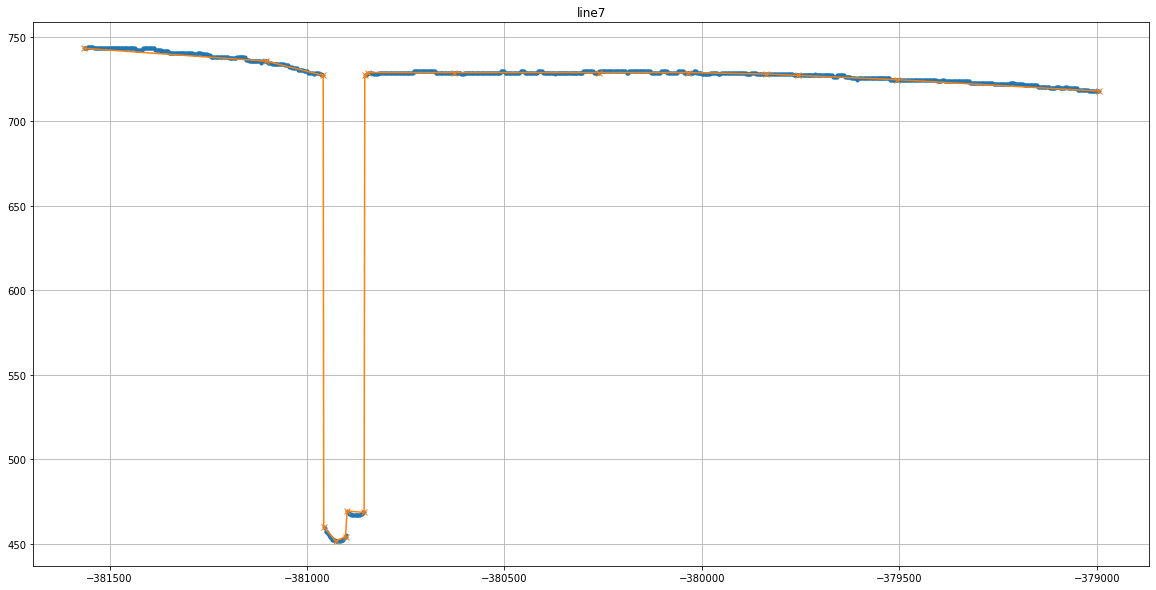

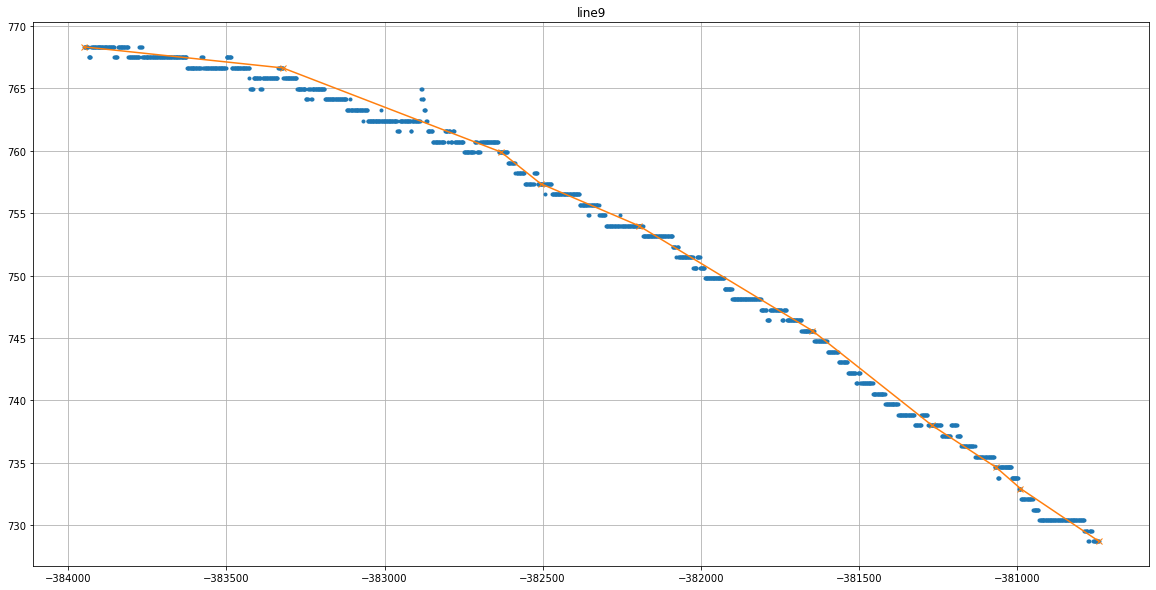

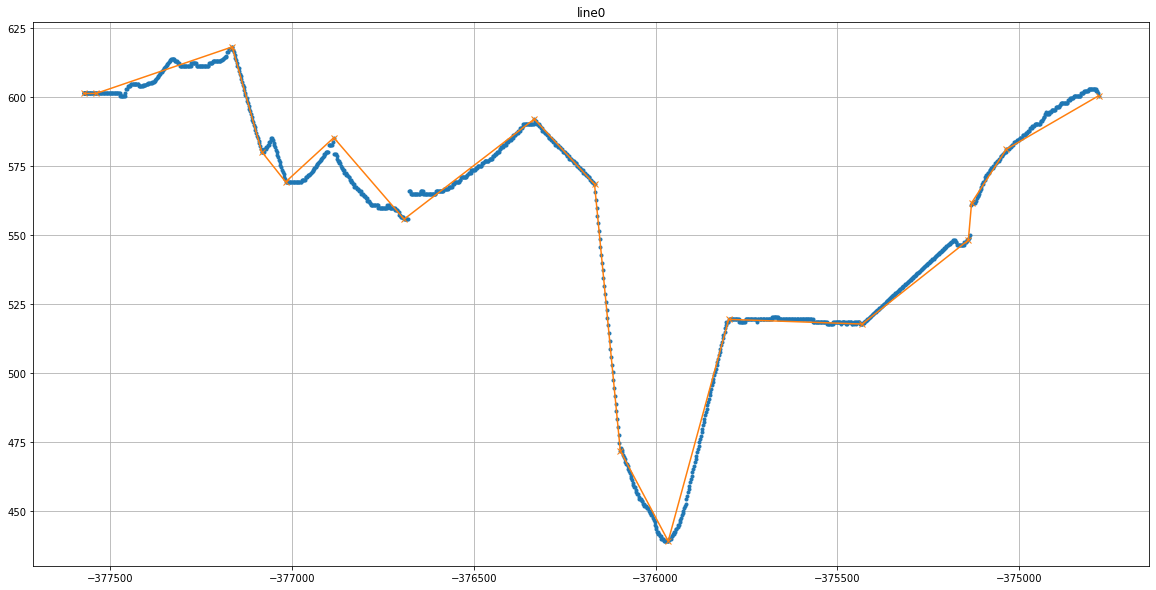

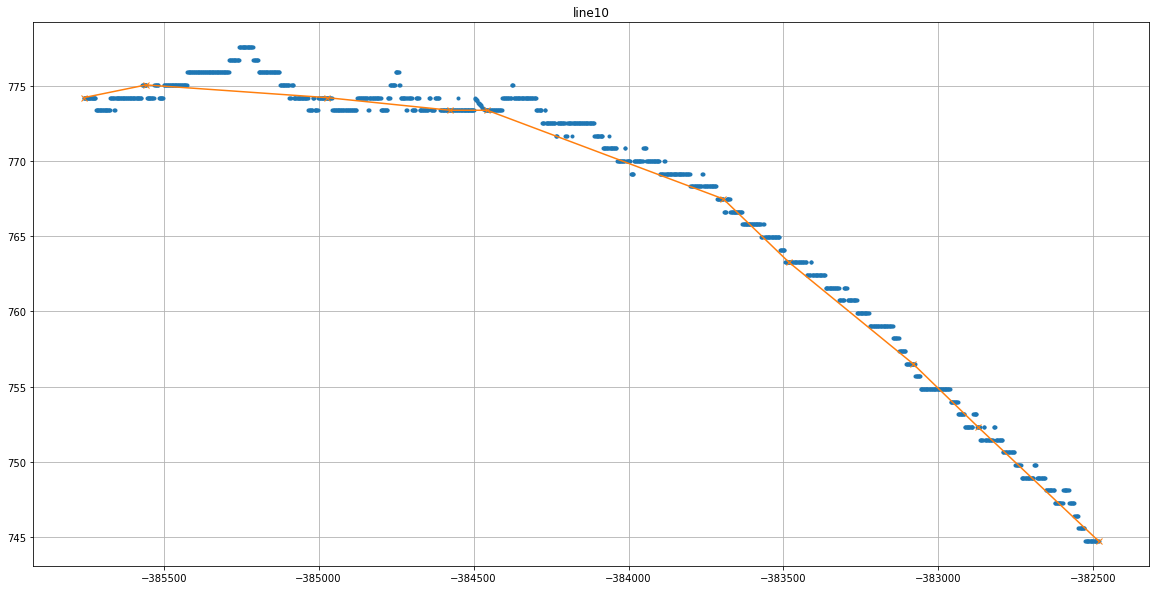

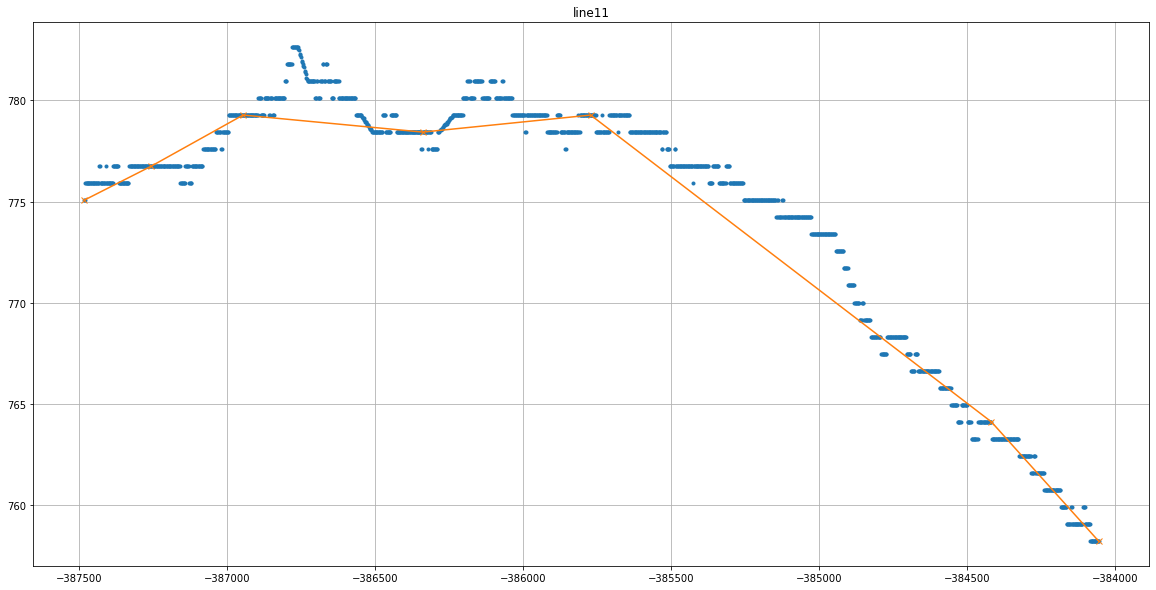

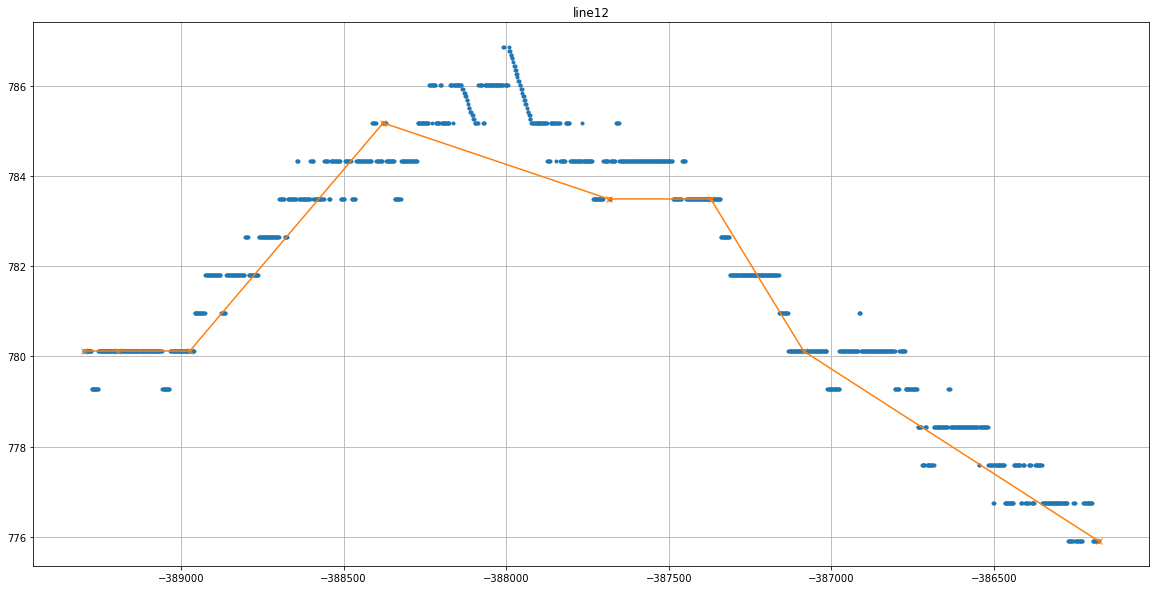

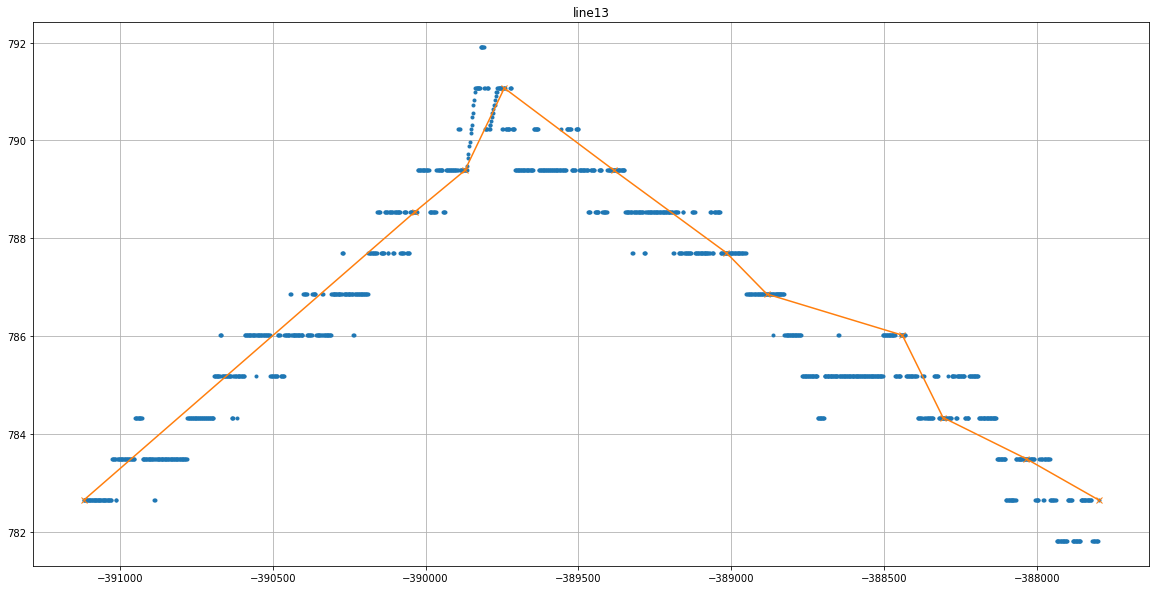

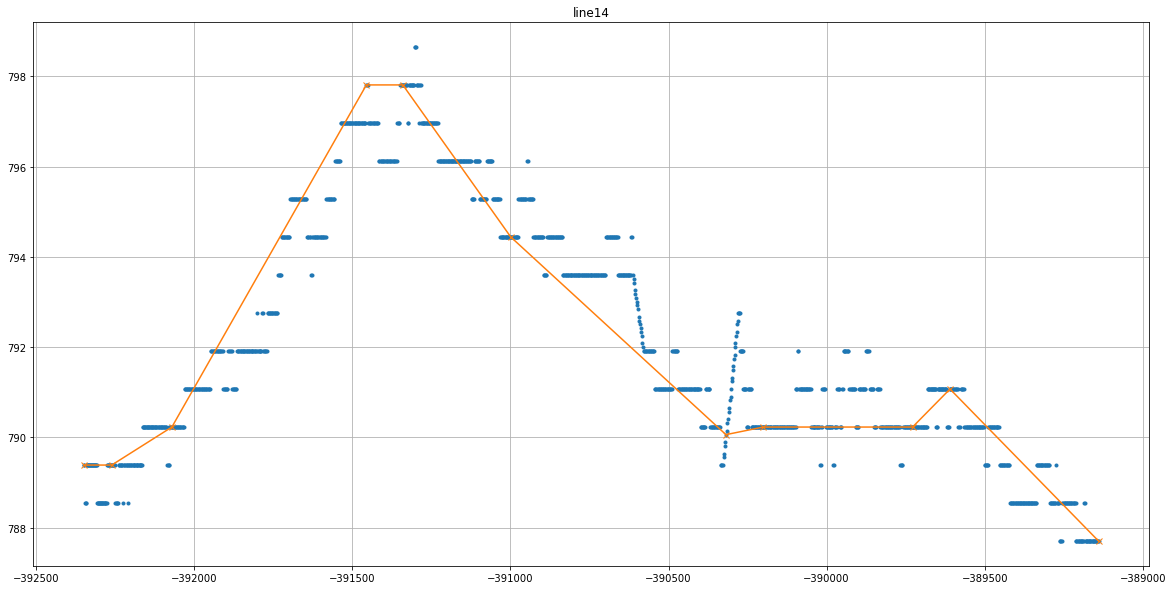

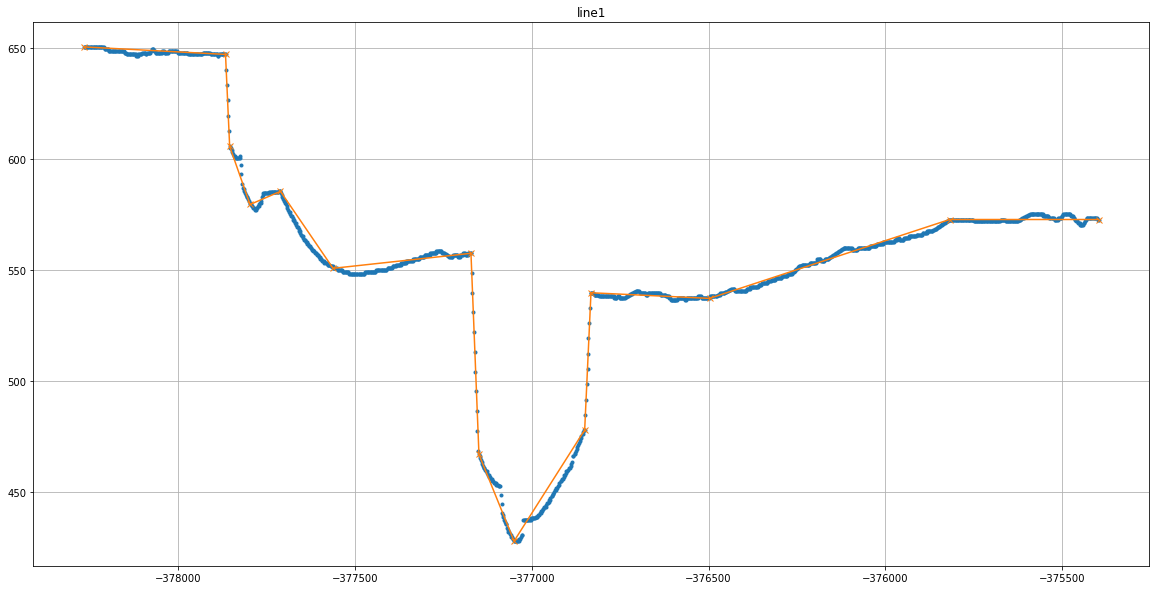

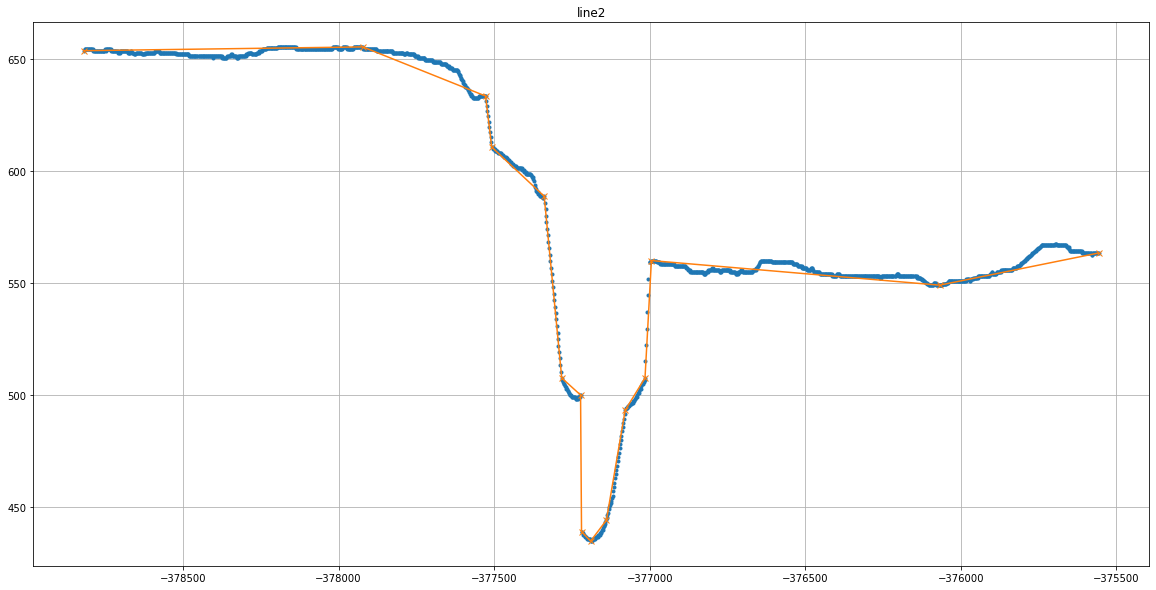

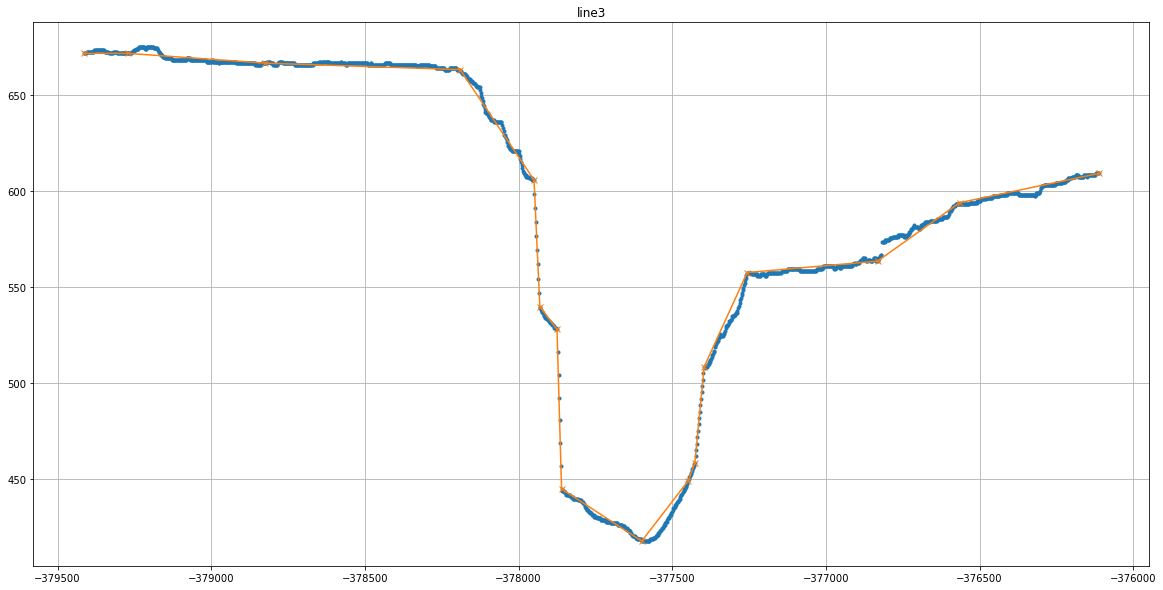

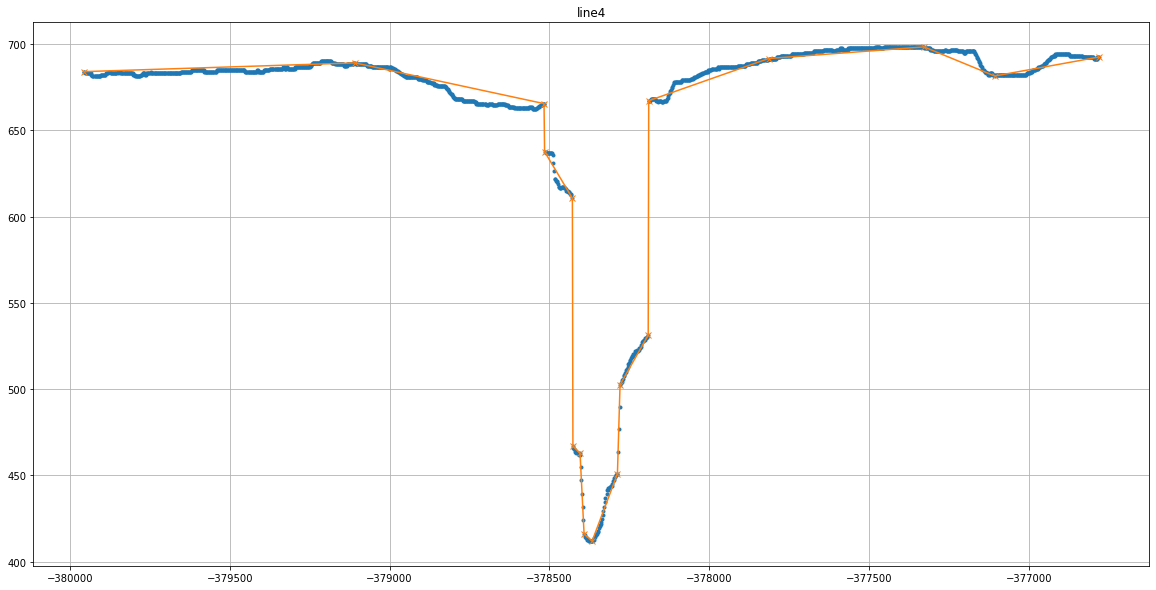

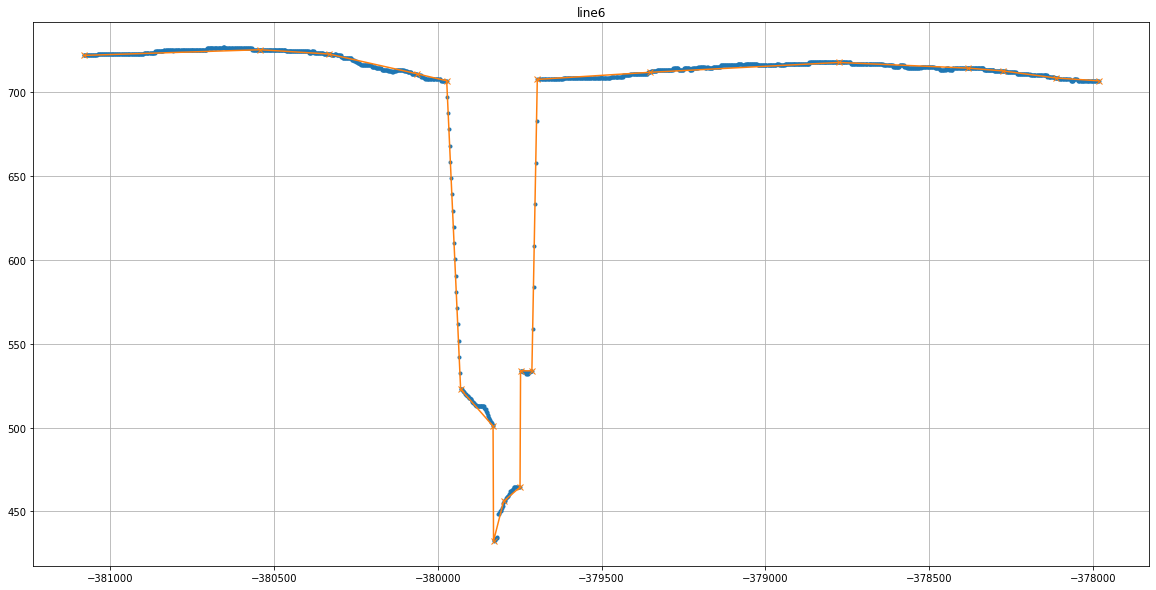

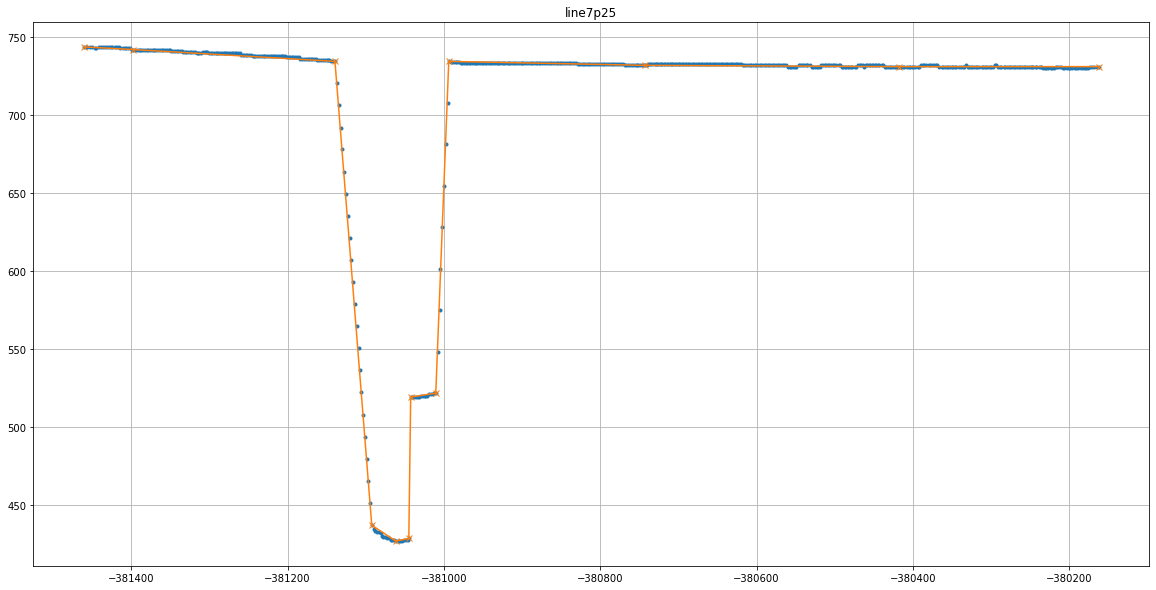

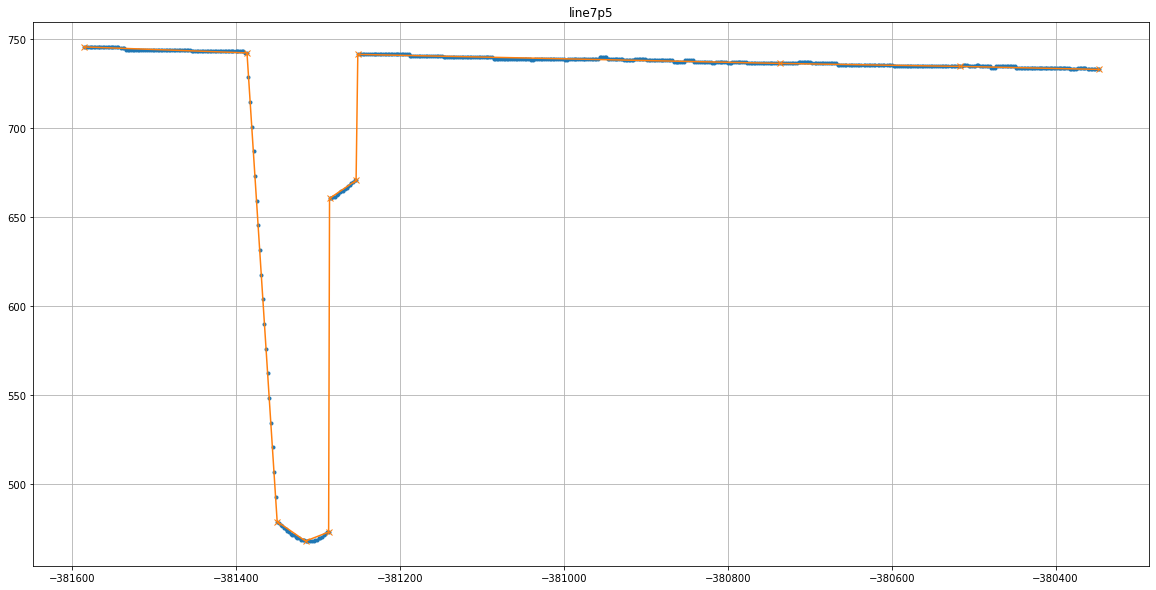

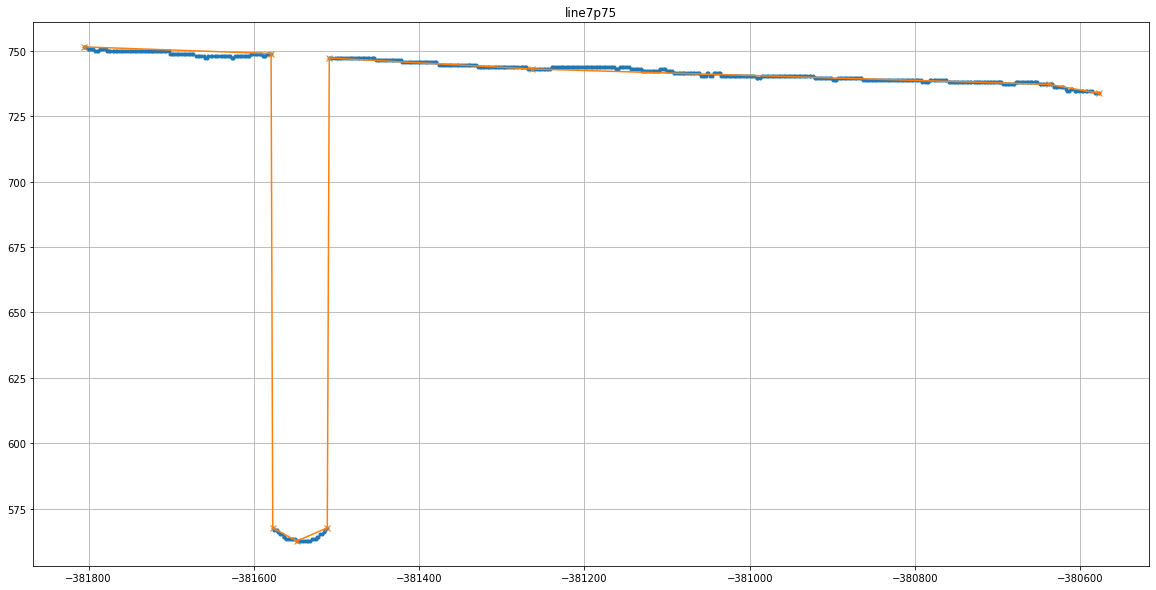

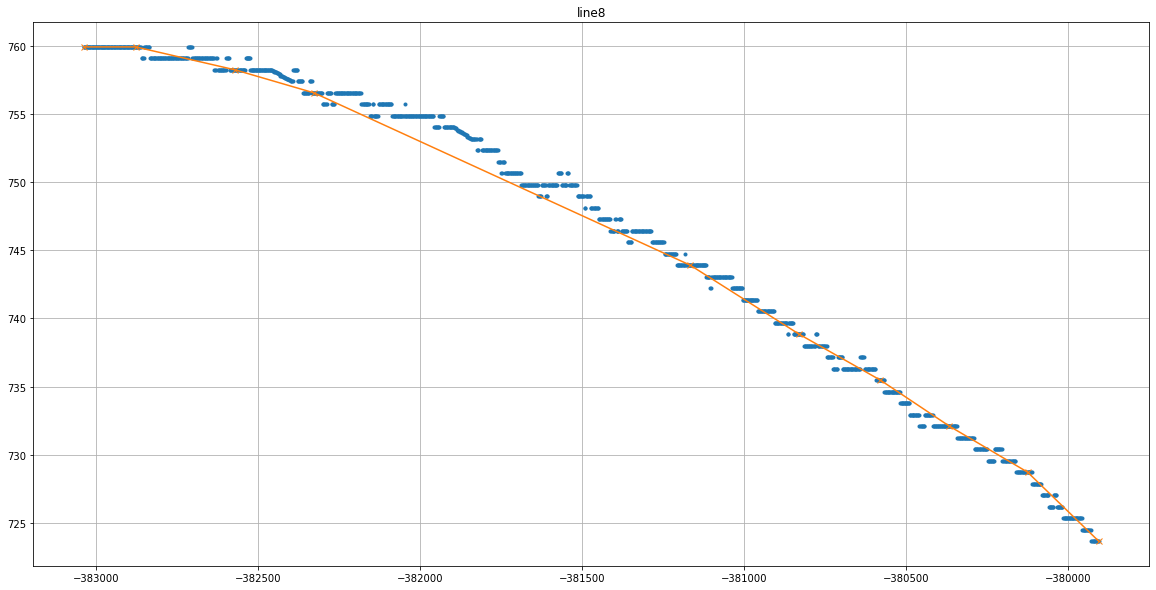

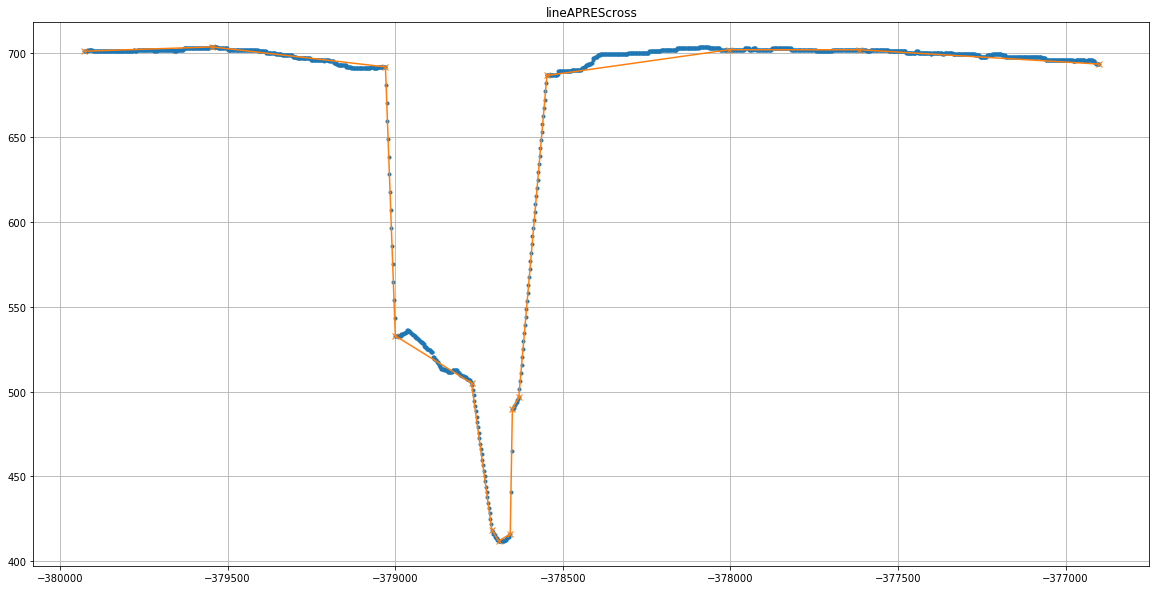

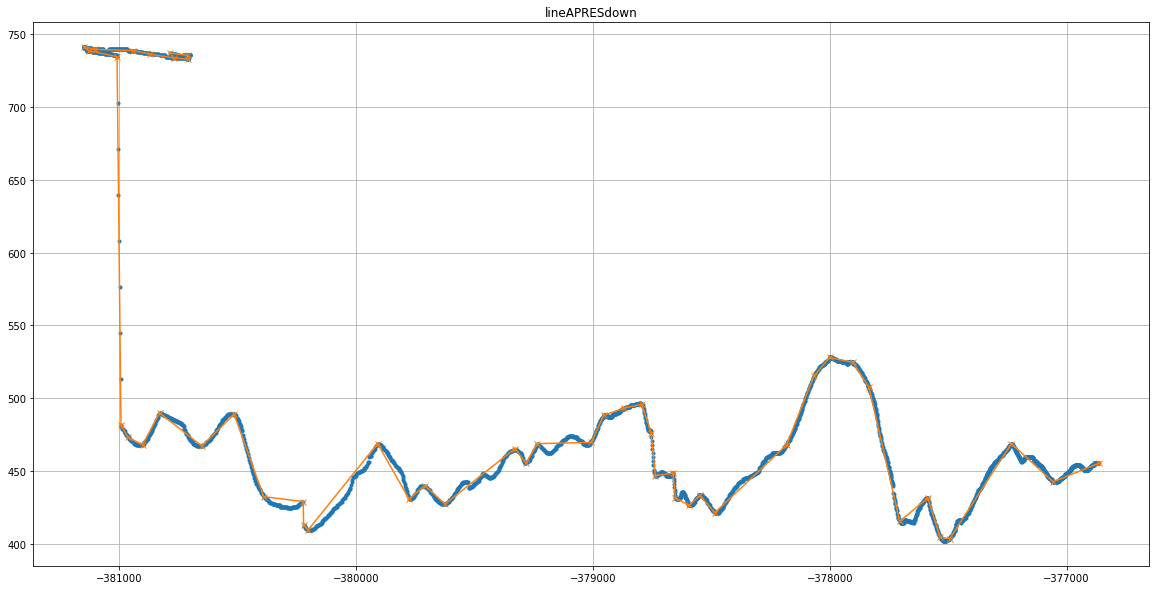

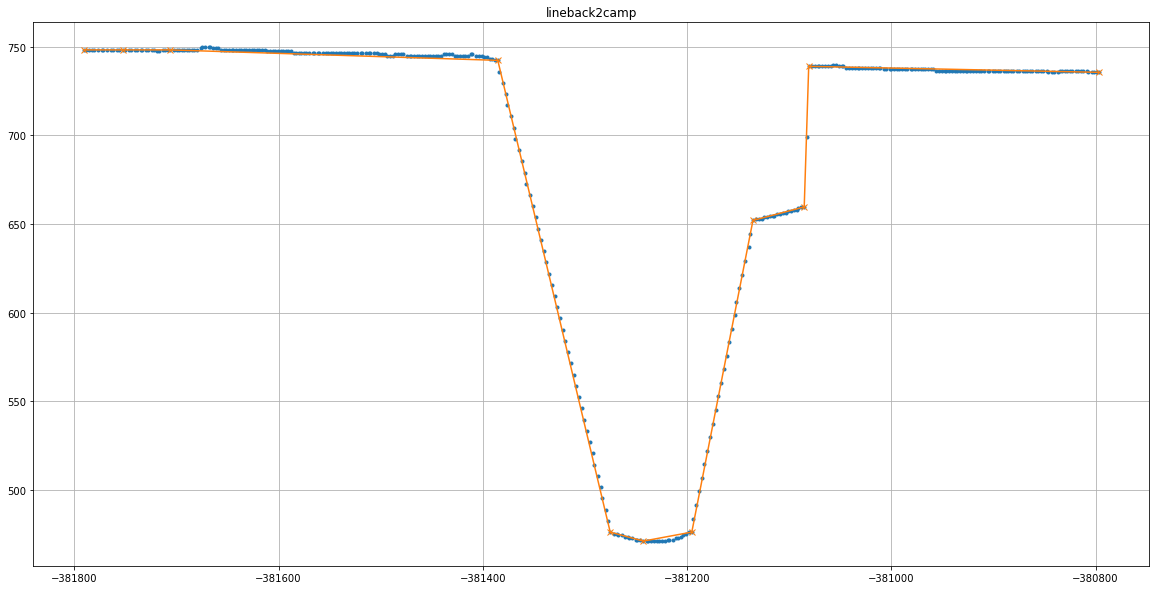

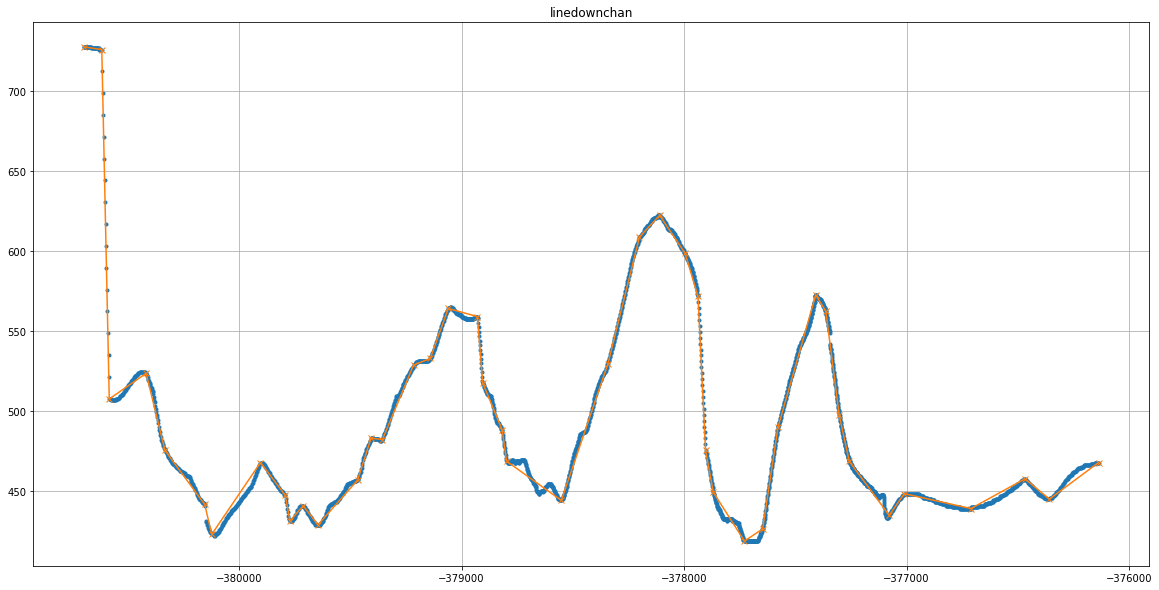

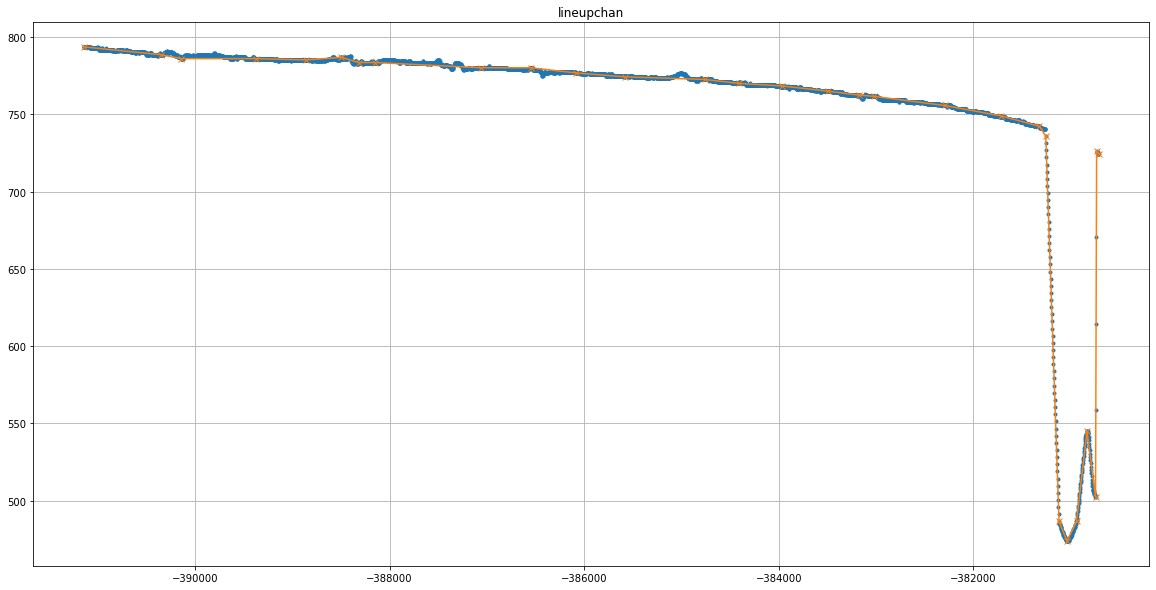

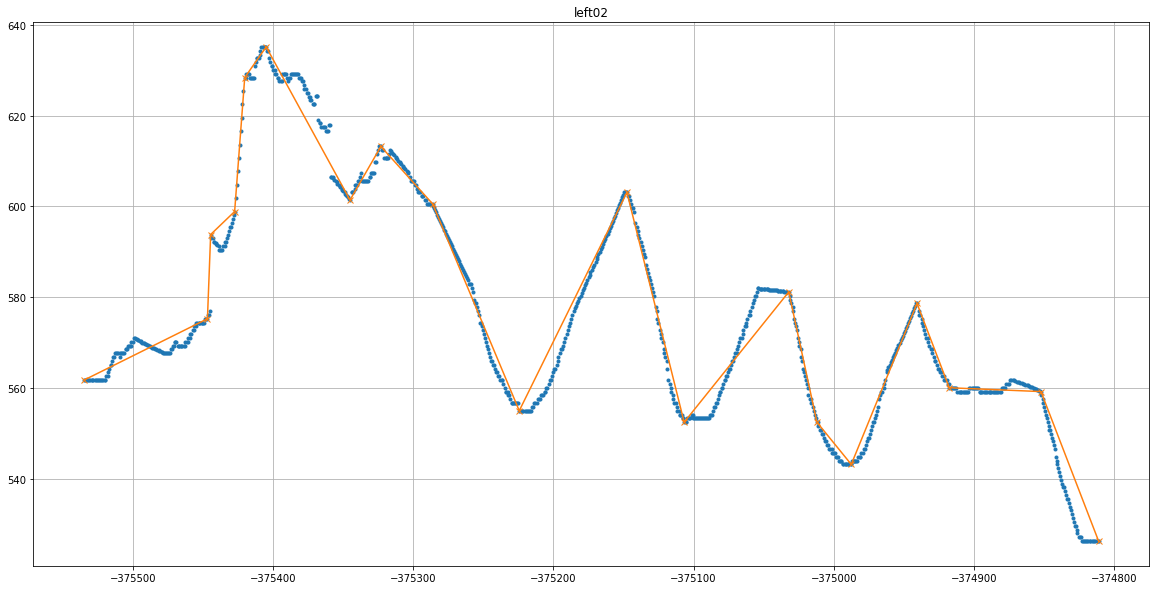

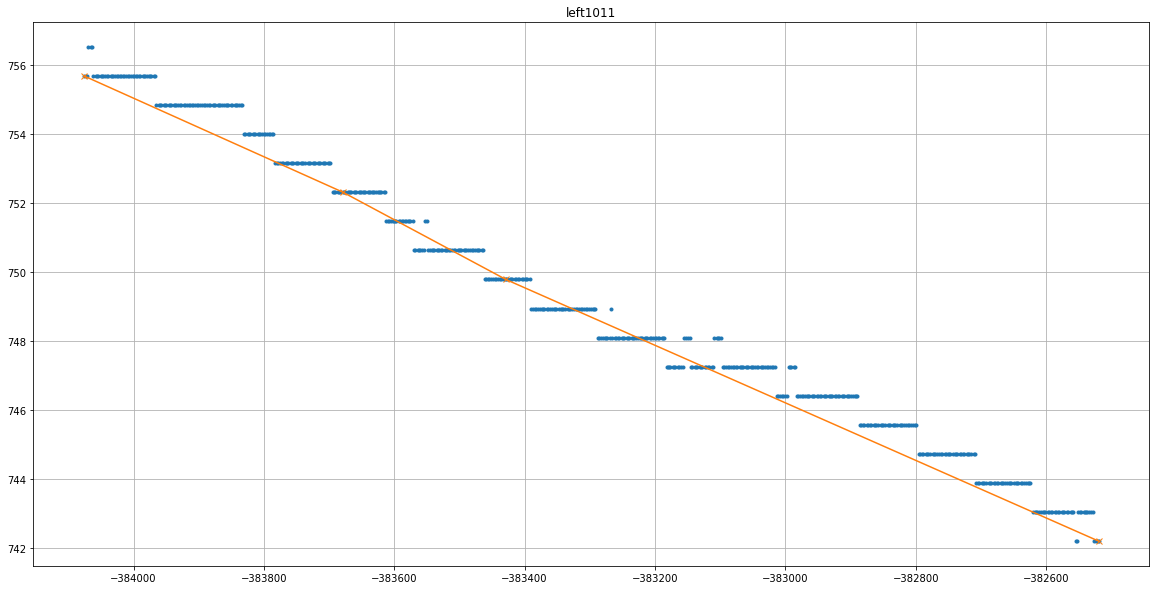

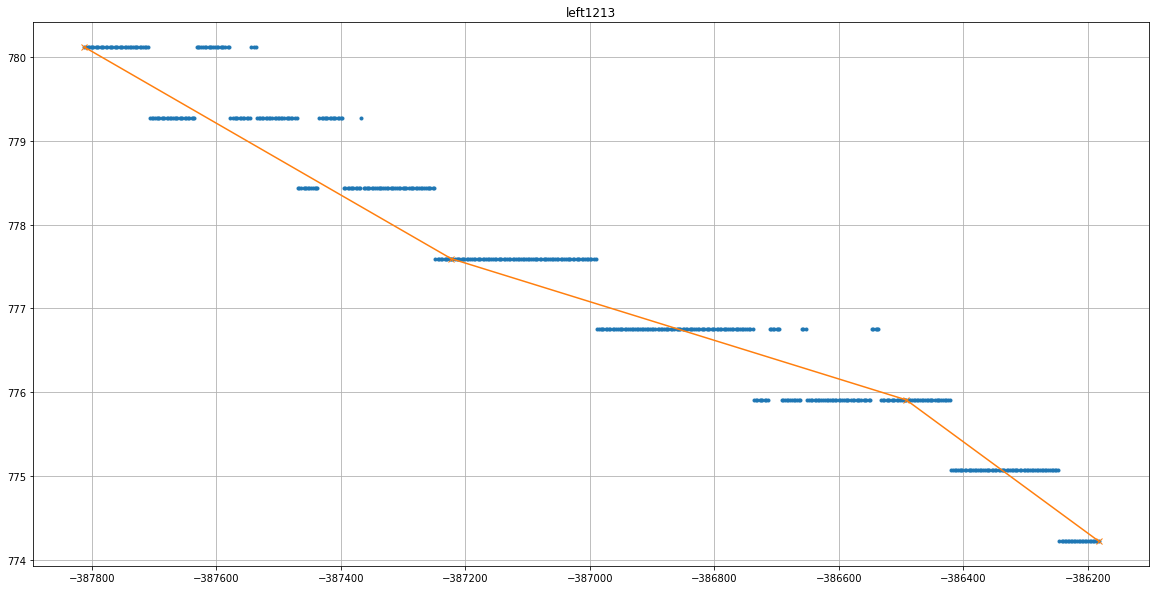

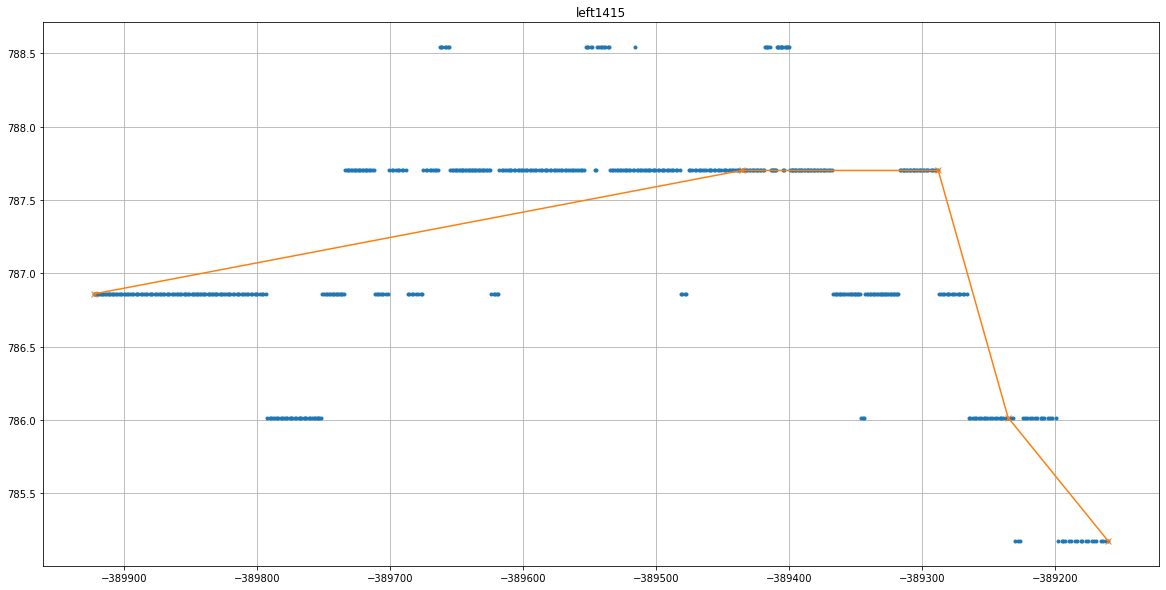

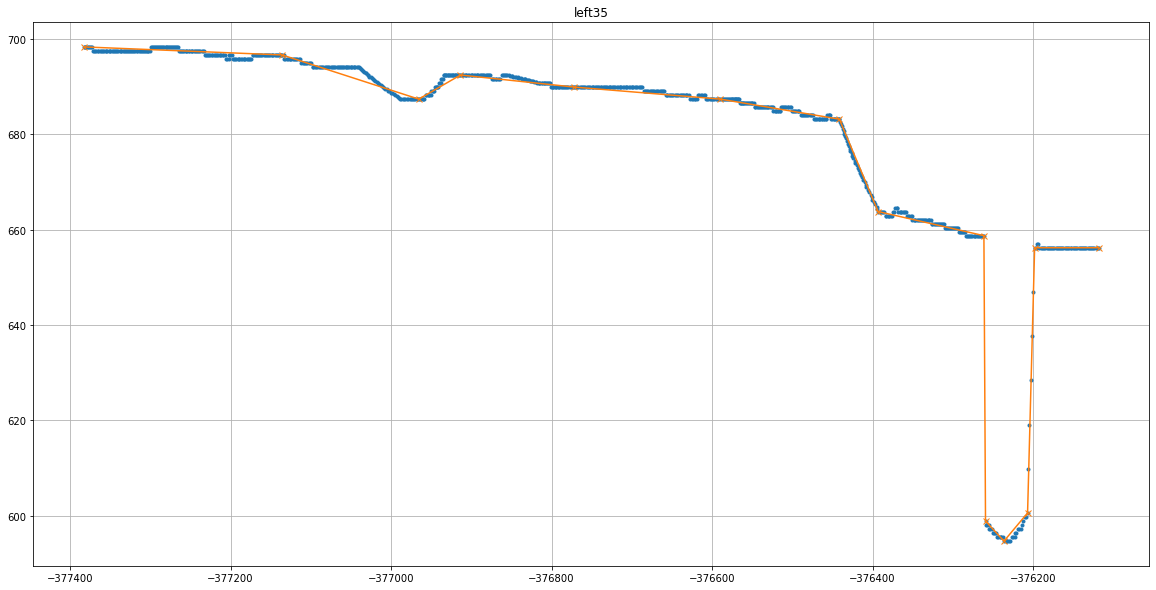

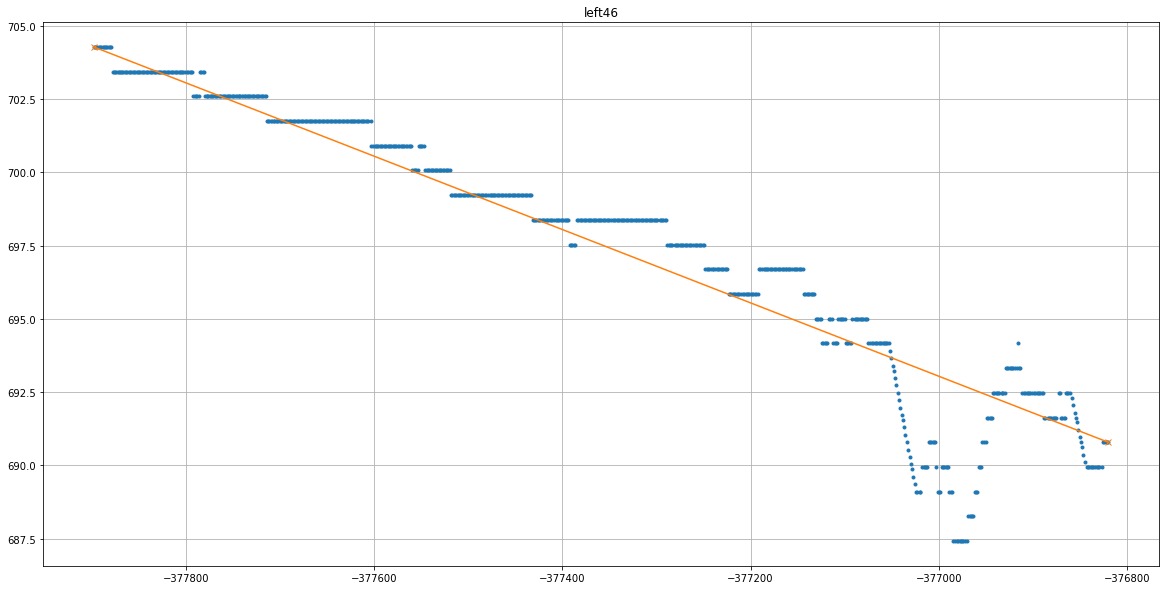

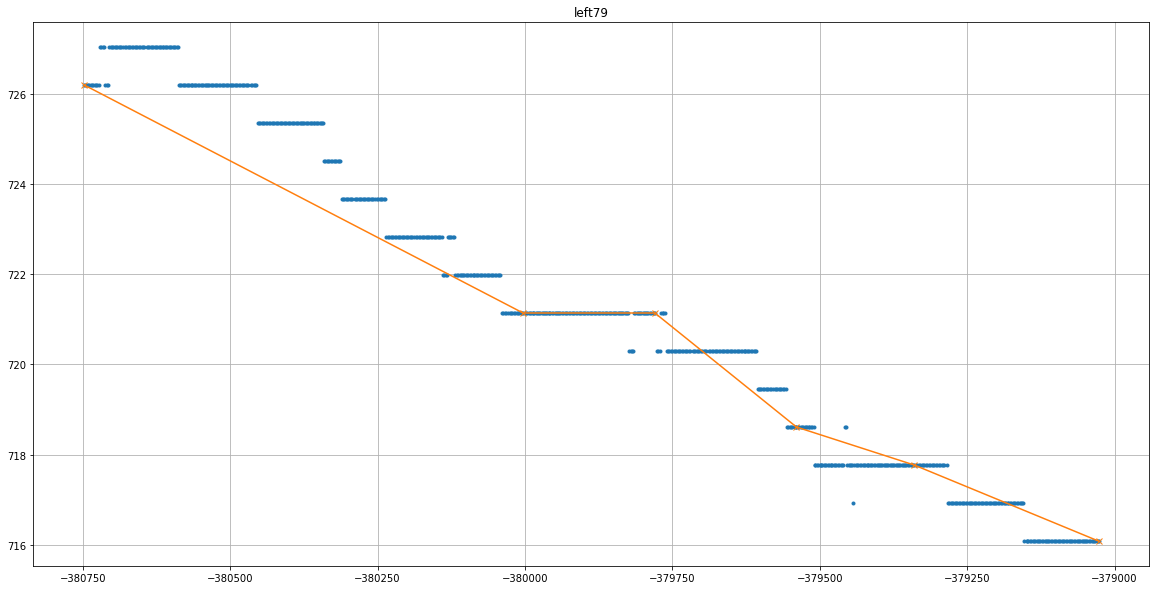

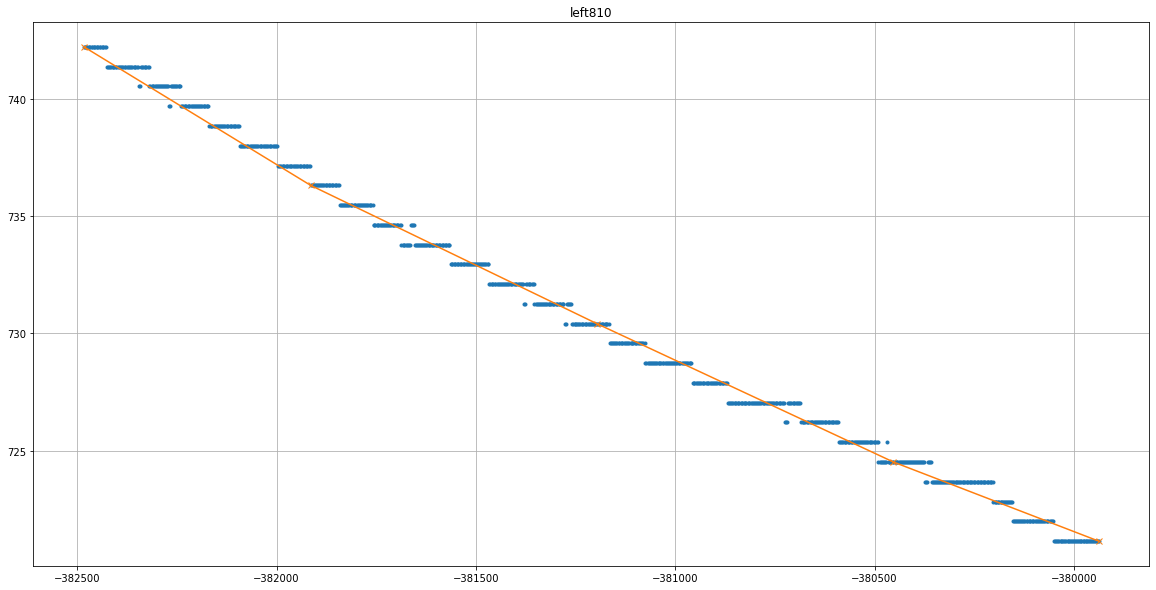

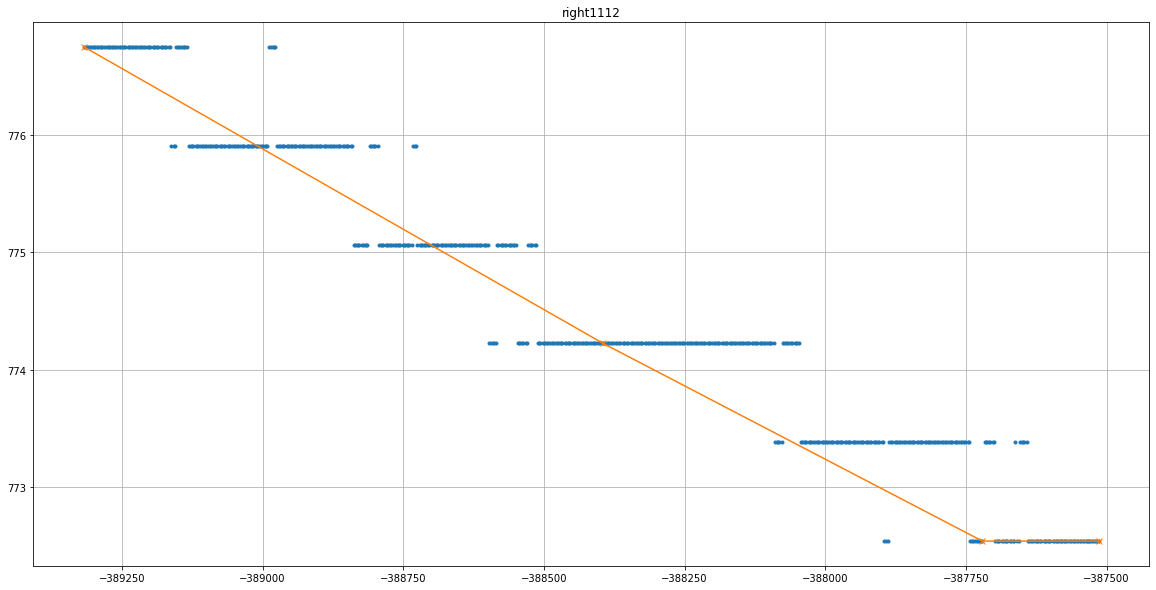

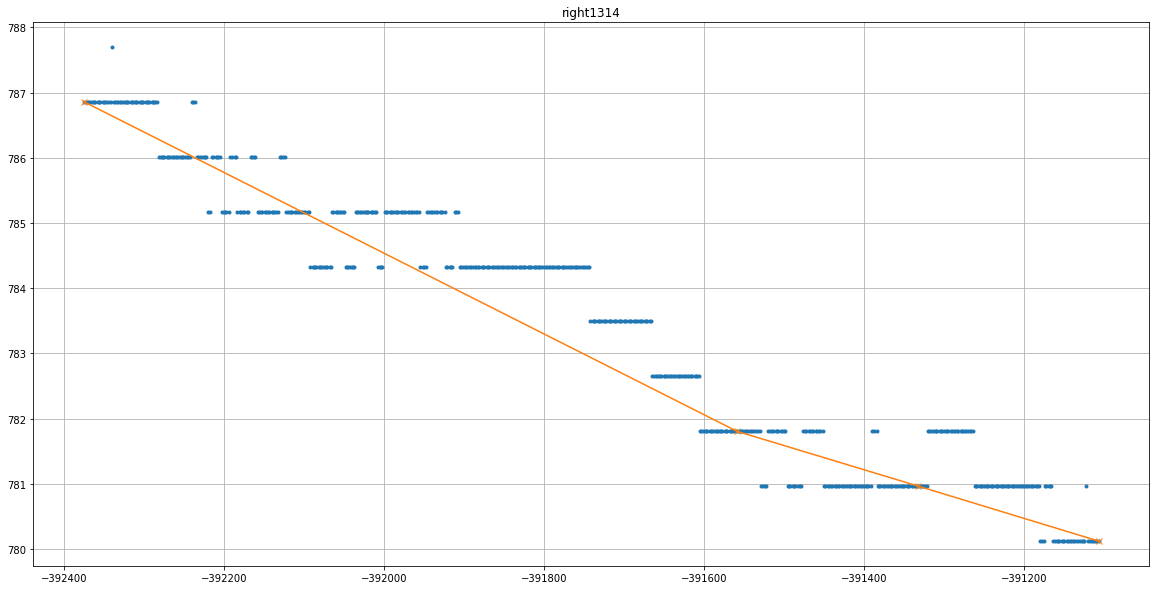

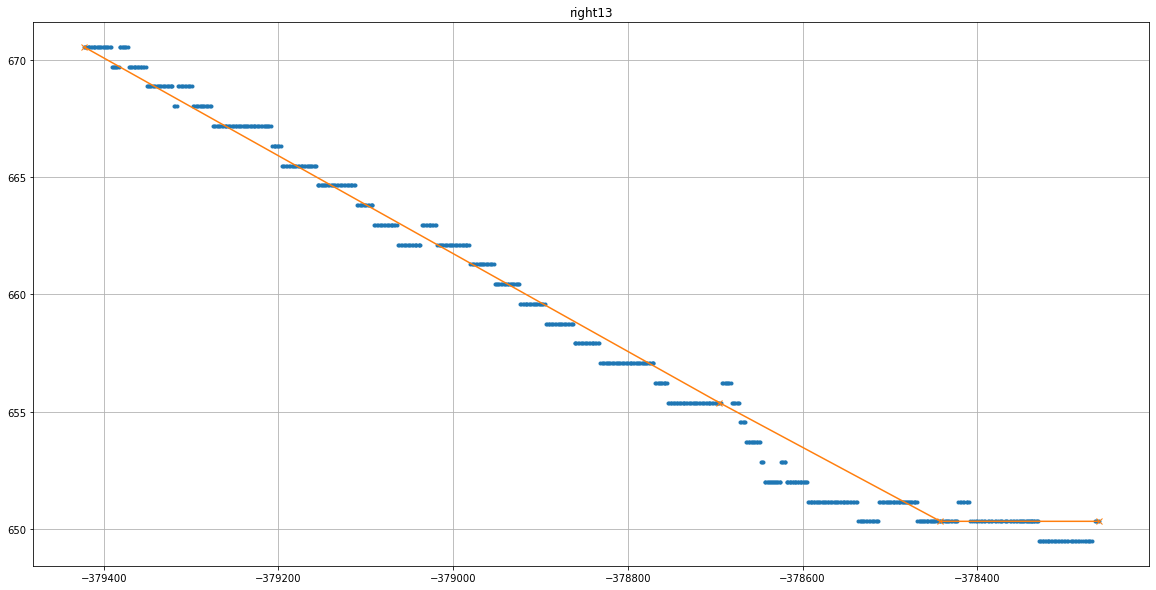

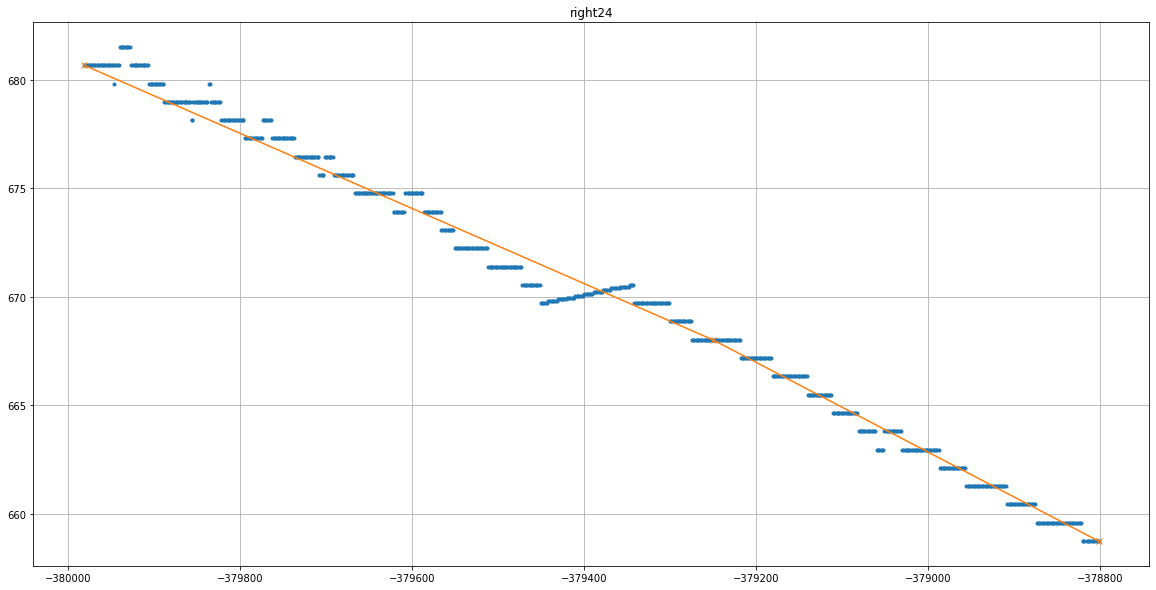

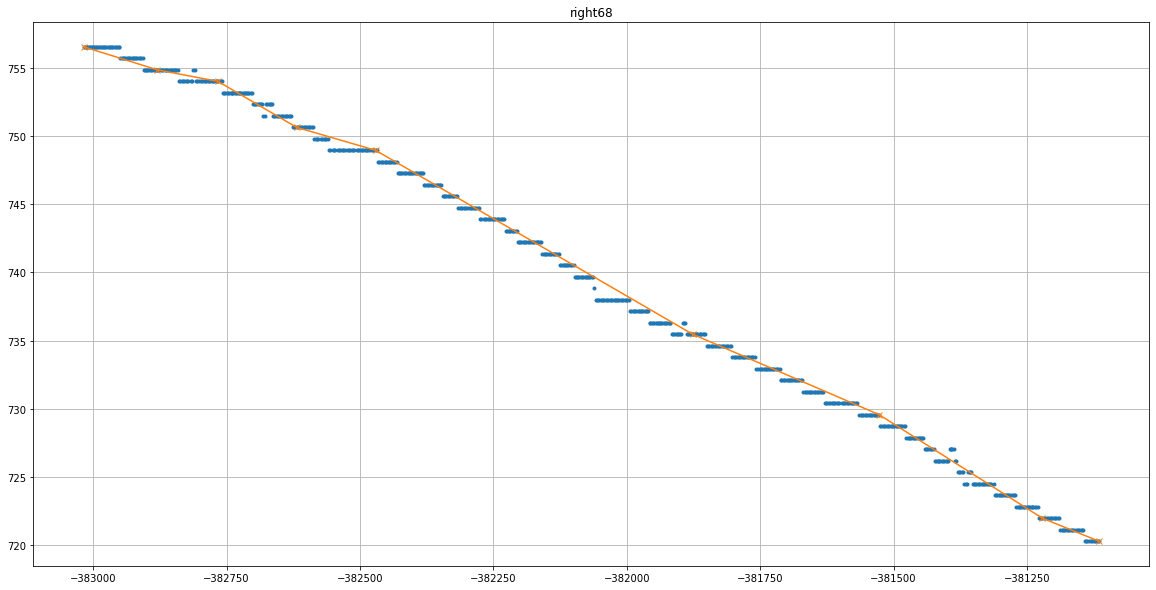

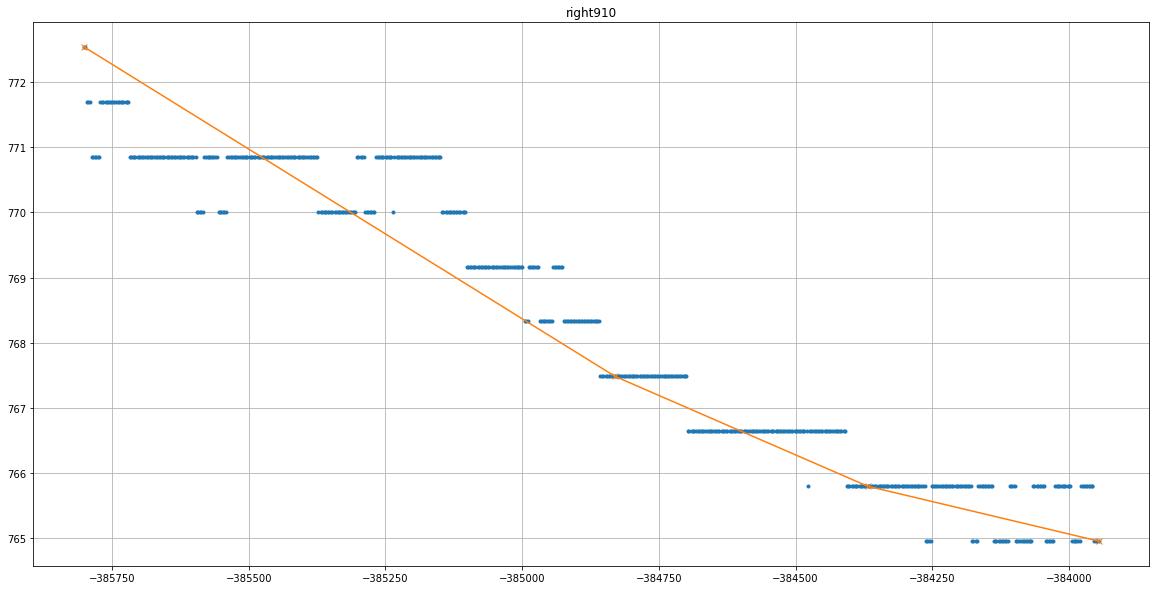

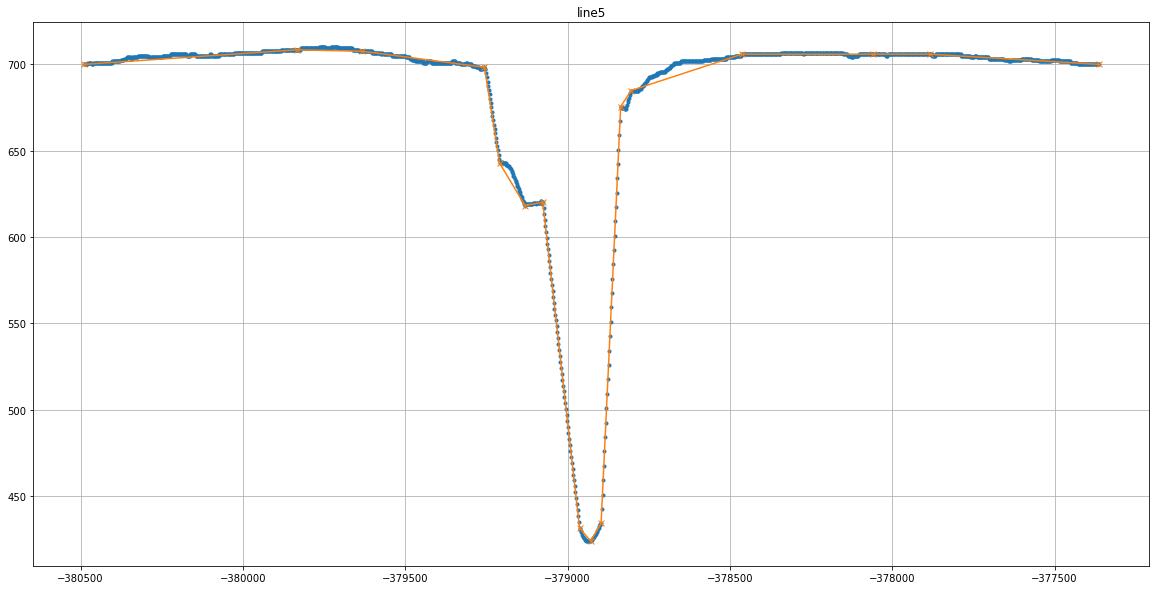

In [27]:
for line_name in ll.keys():
    plot_rdp(line_name,epsilon=10)

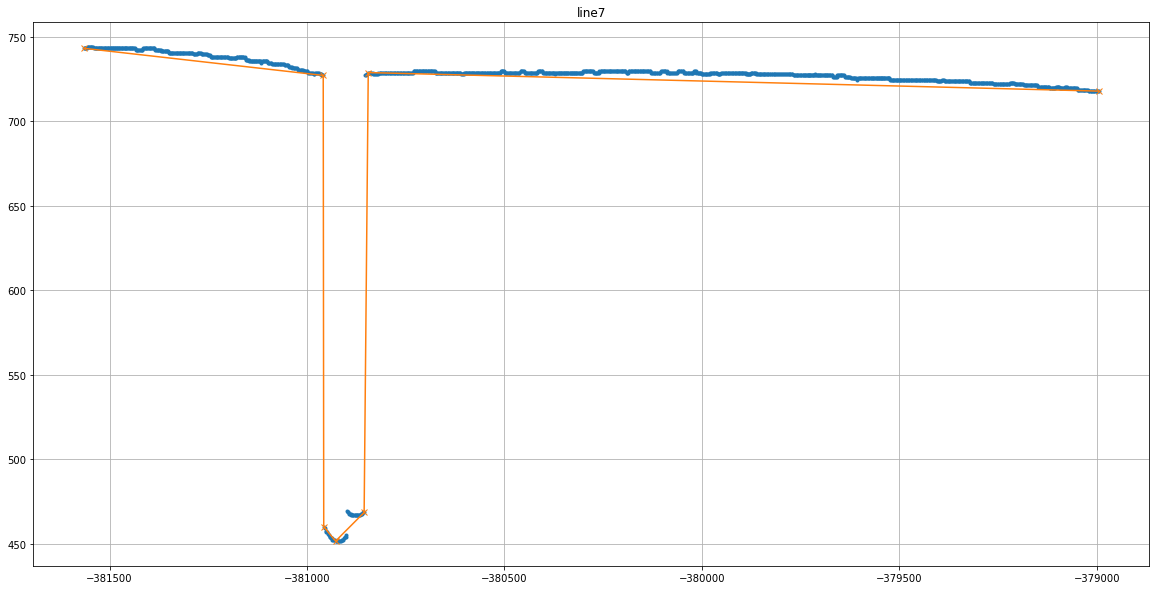

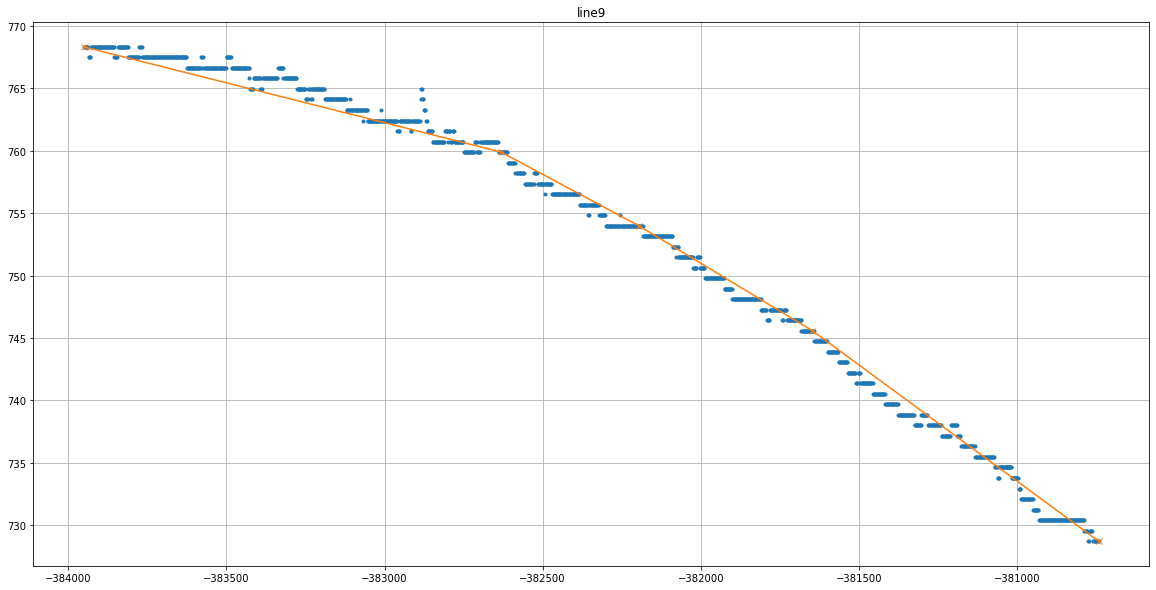

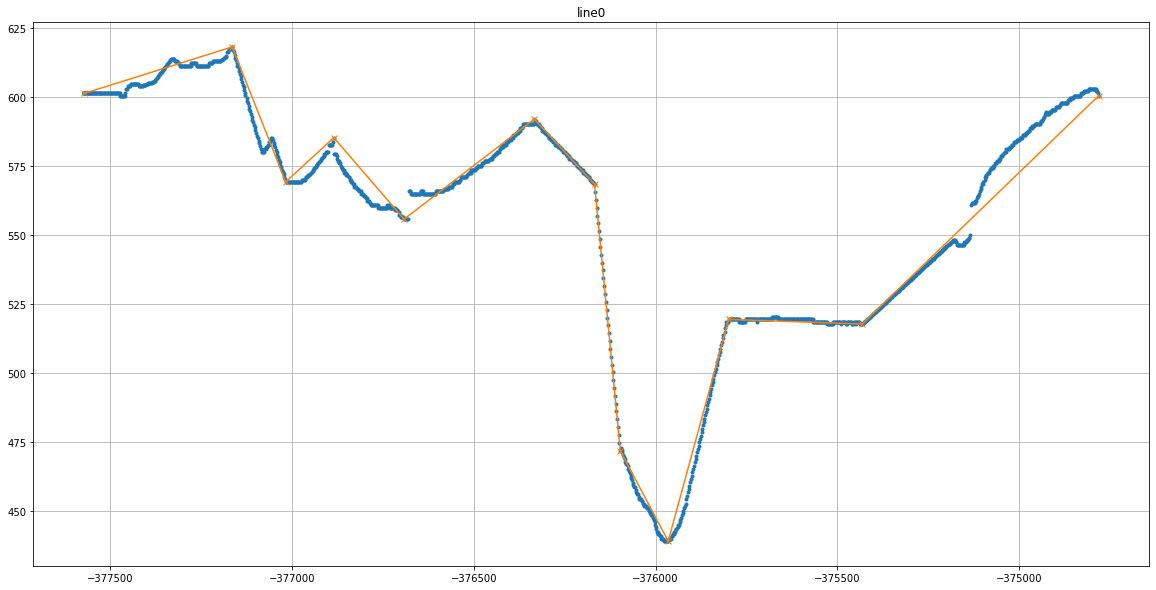

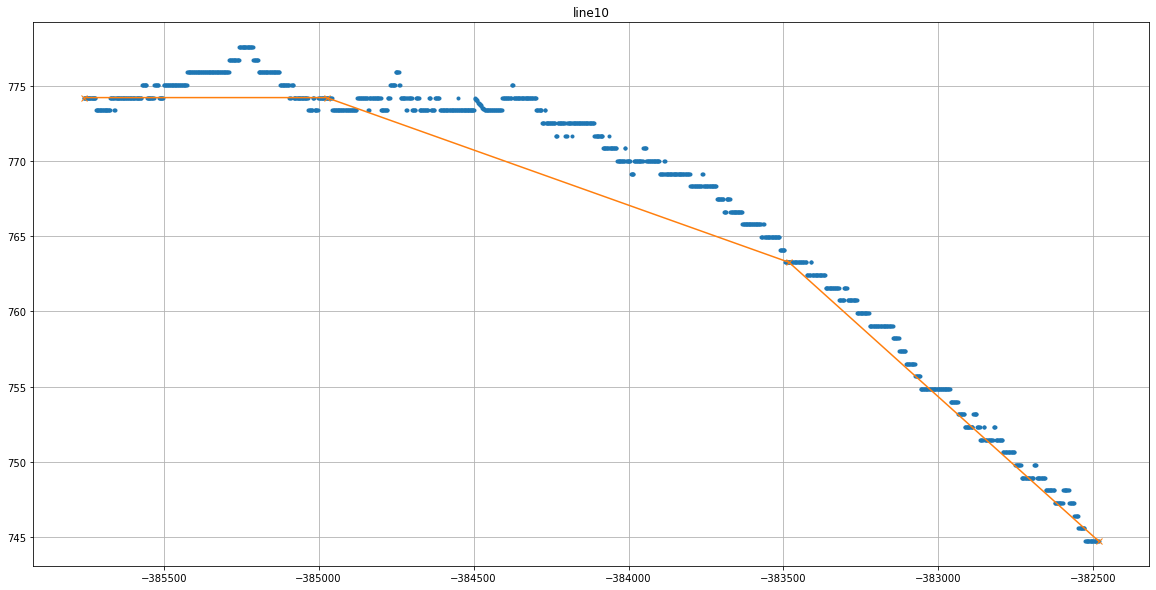

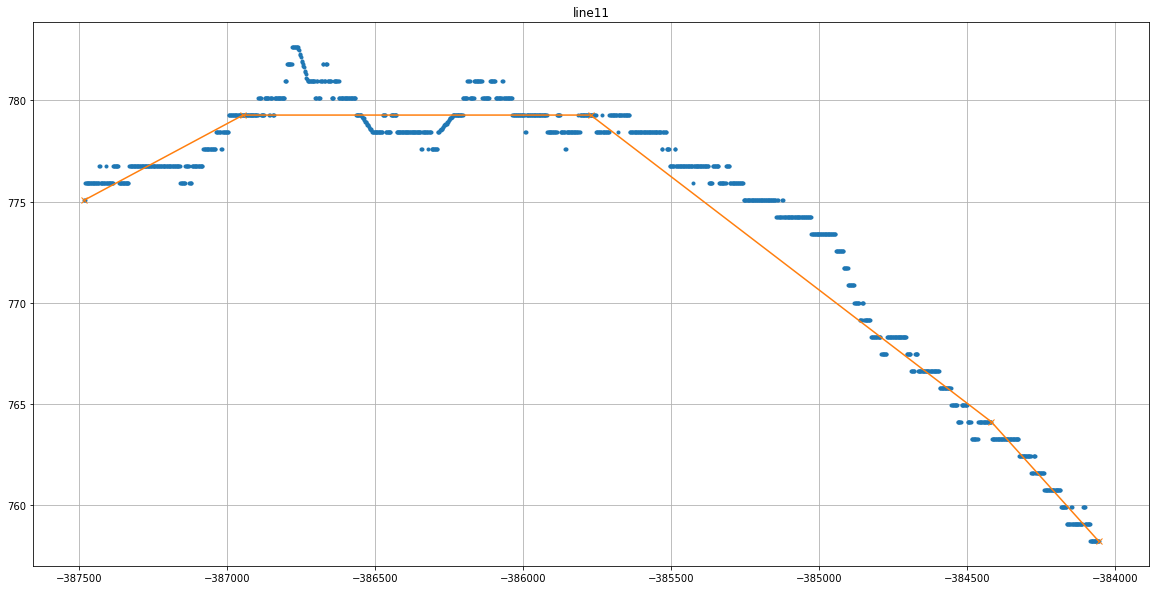

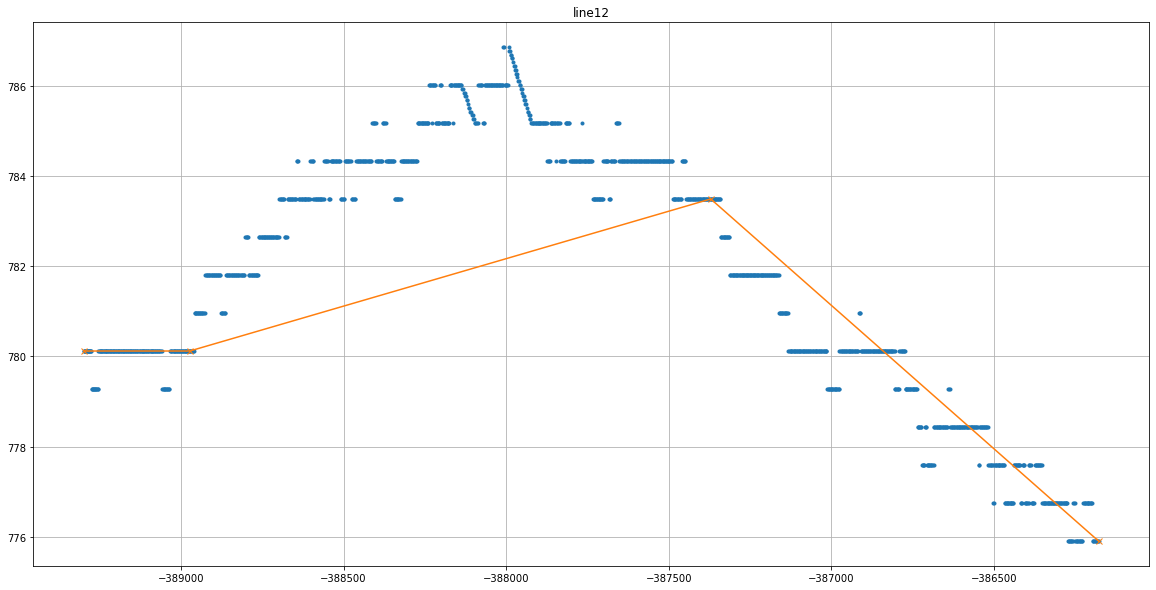

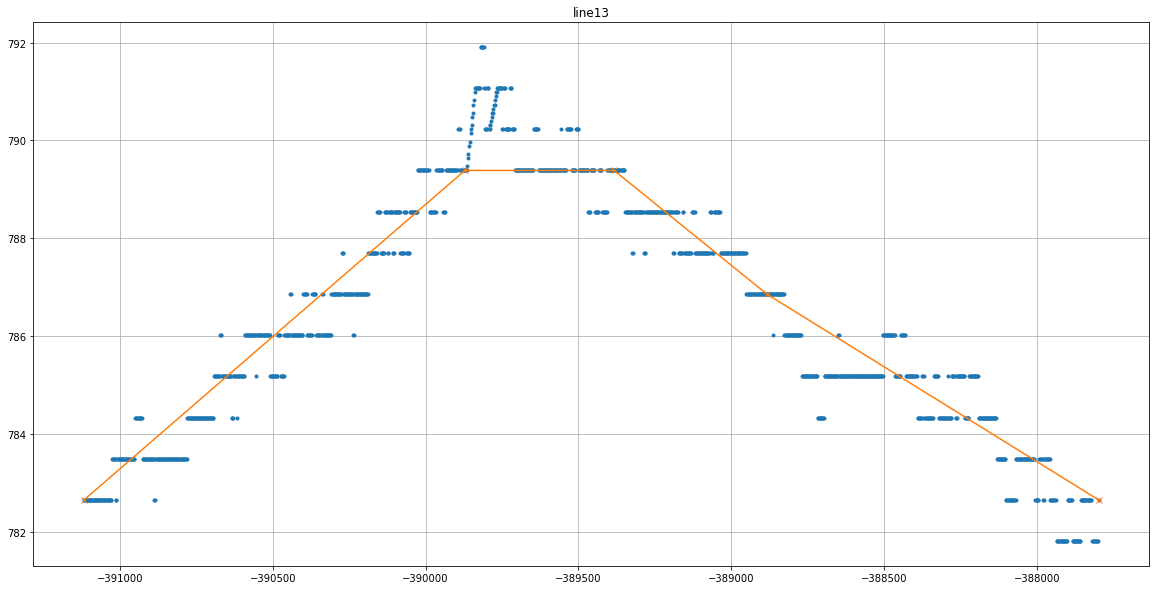

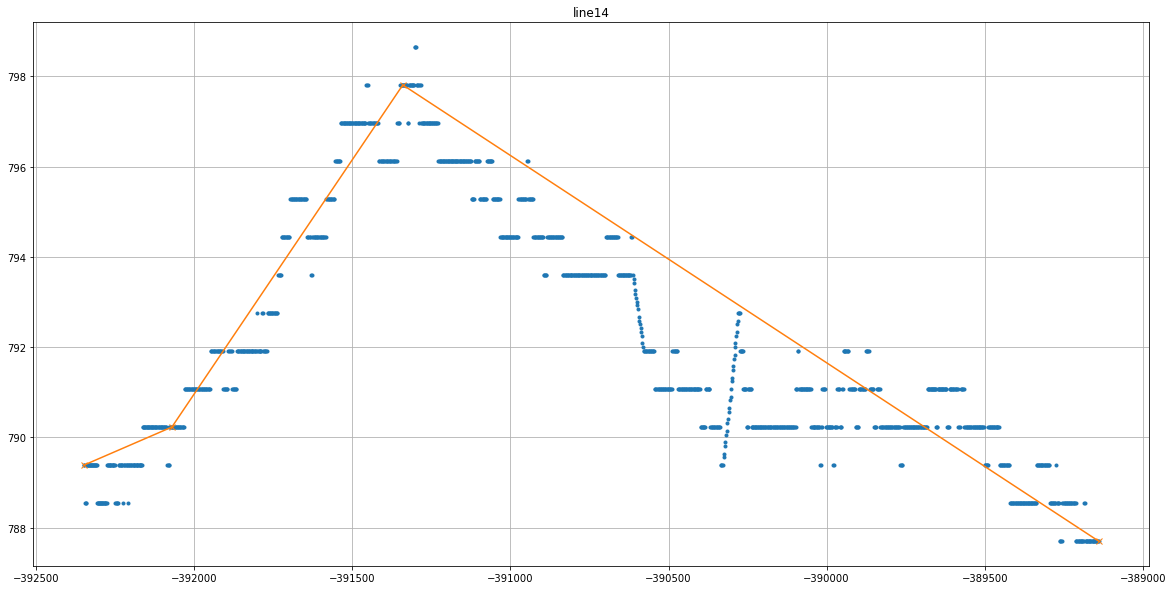

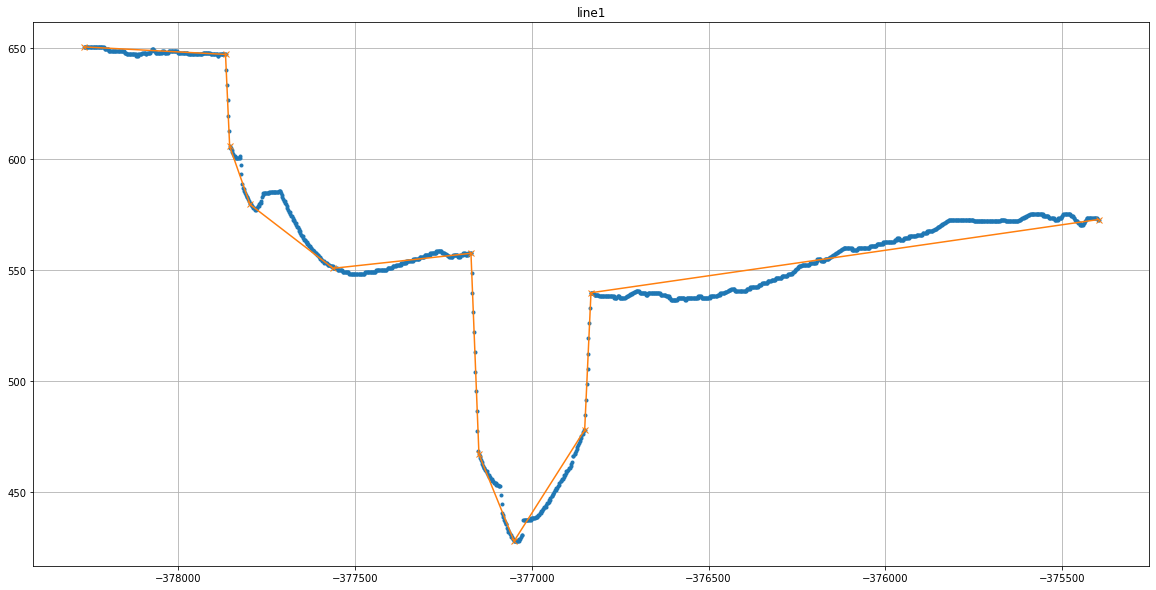

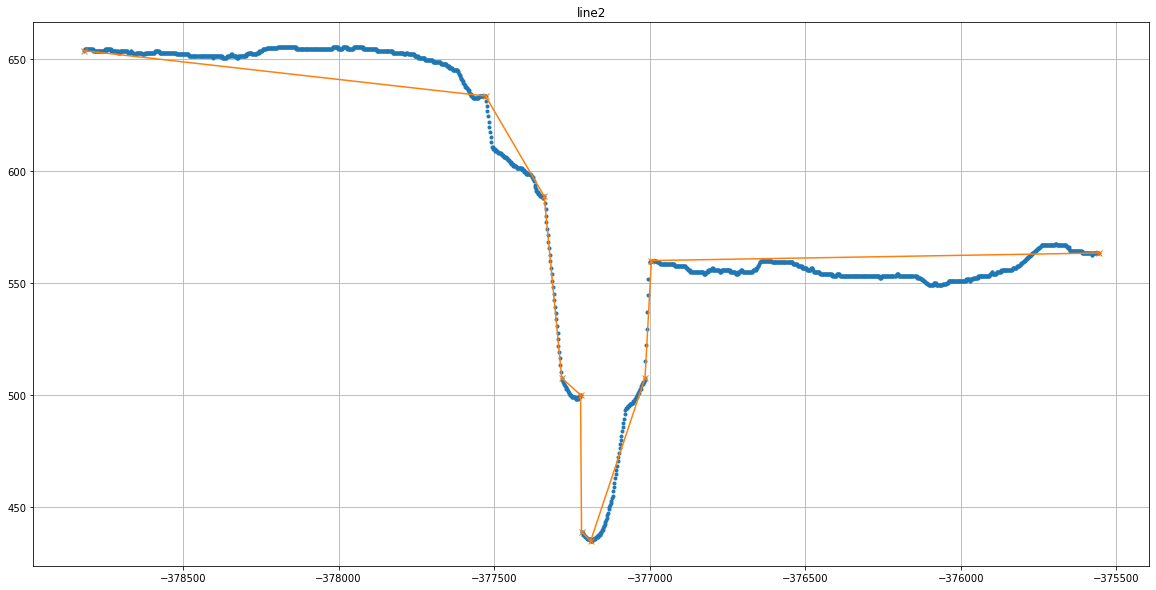

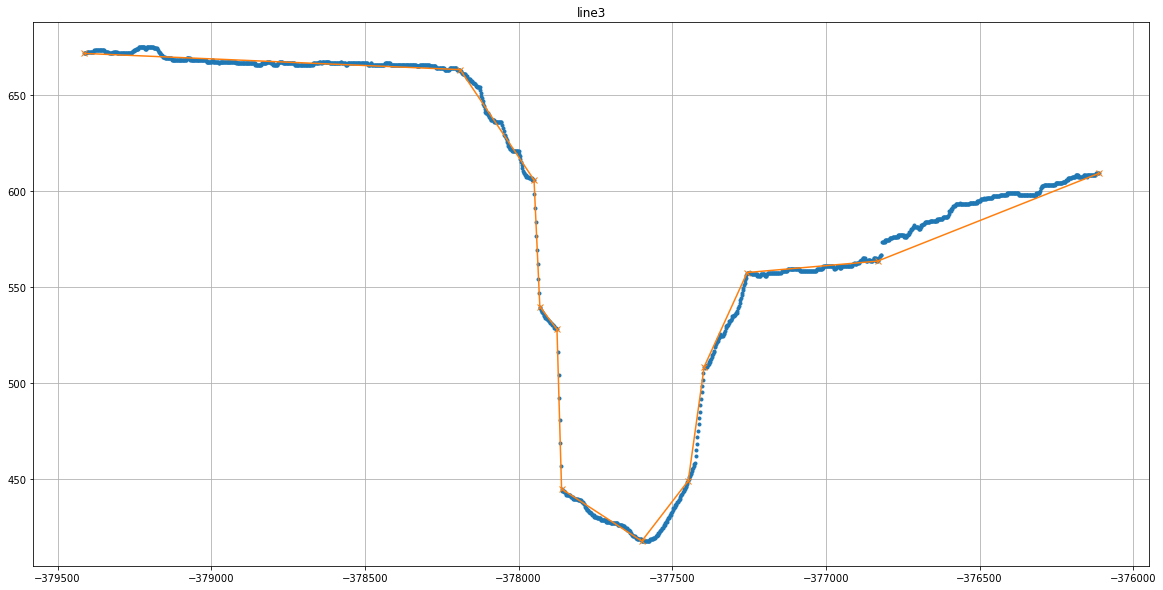

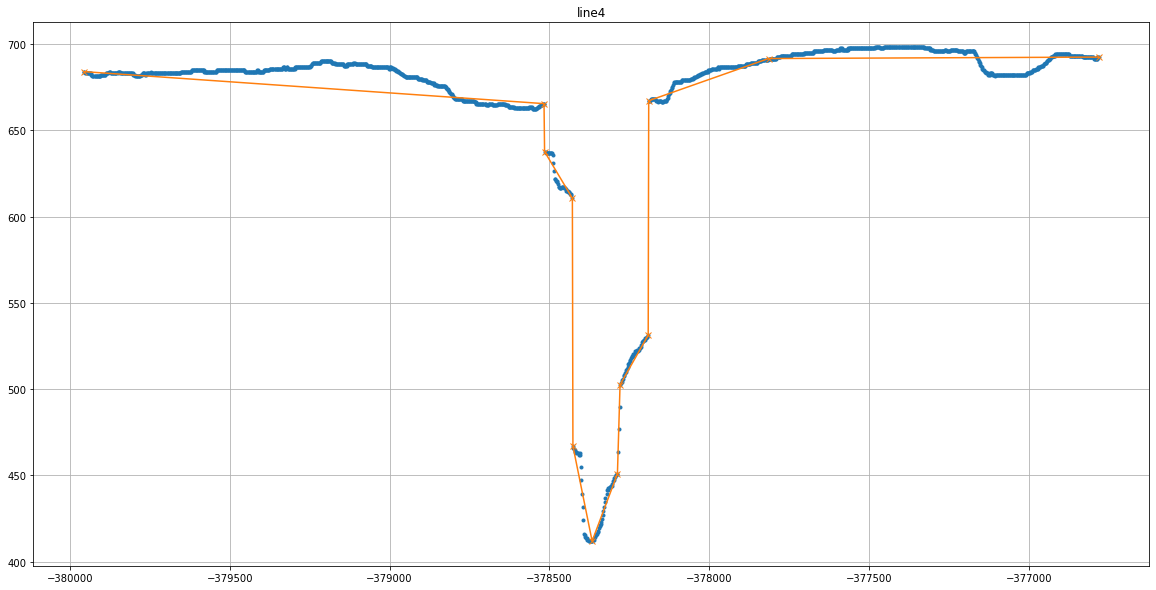

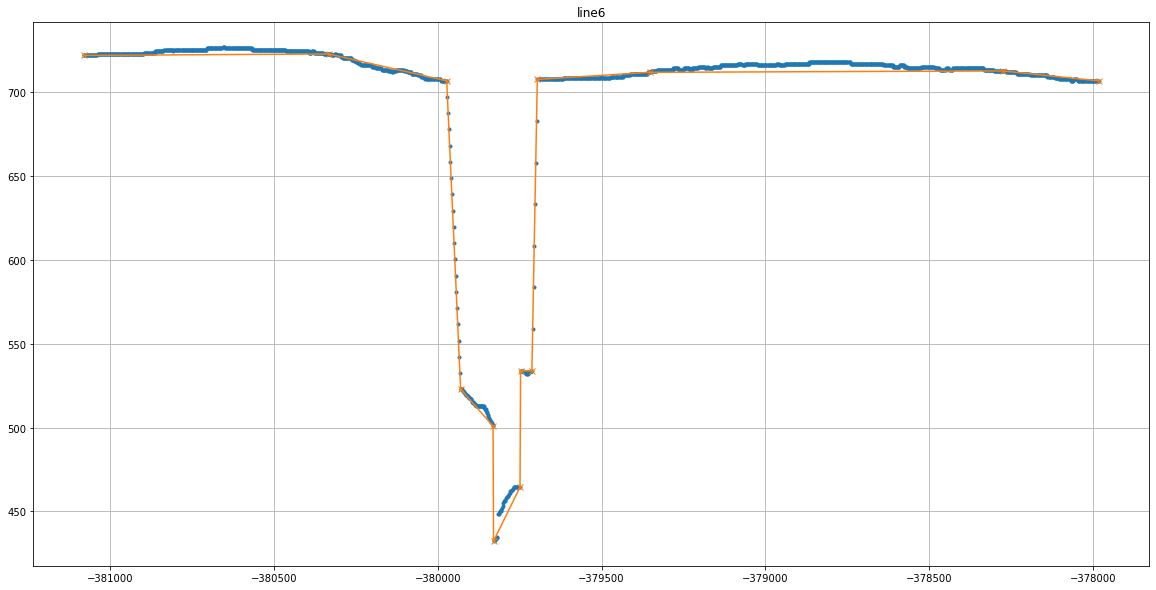

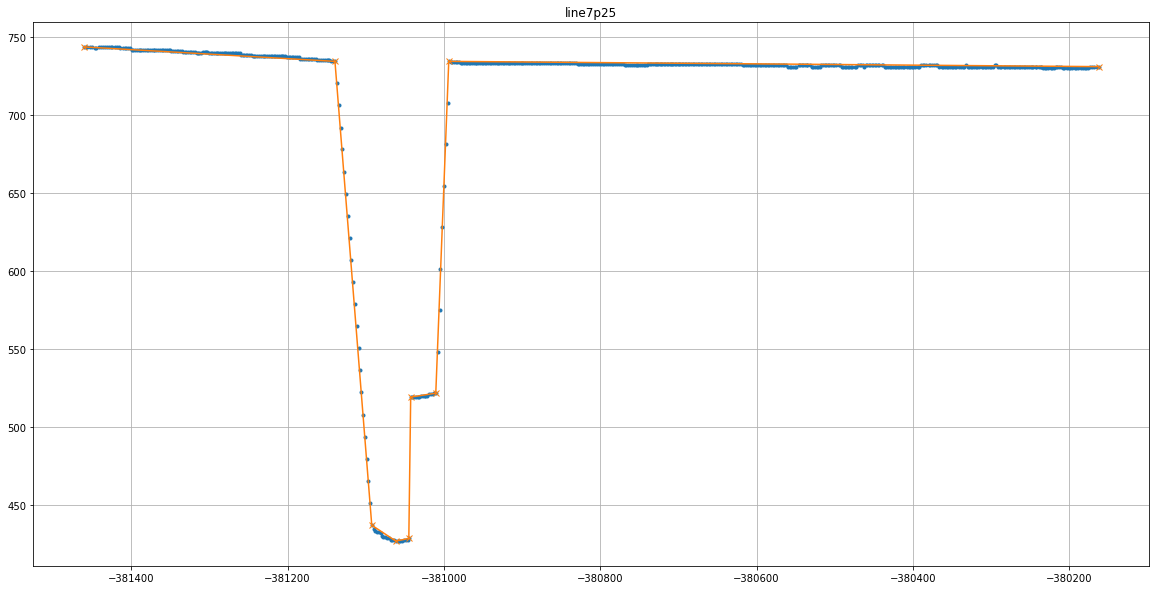

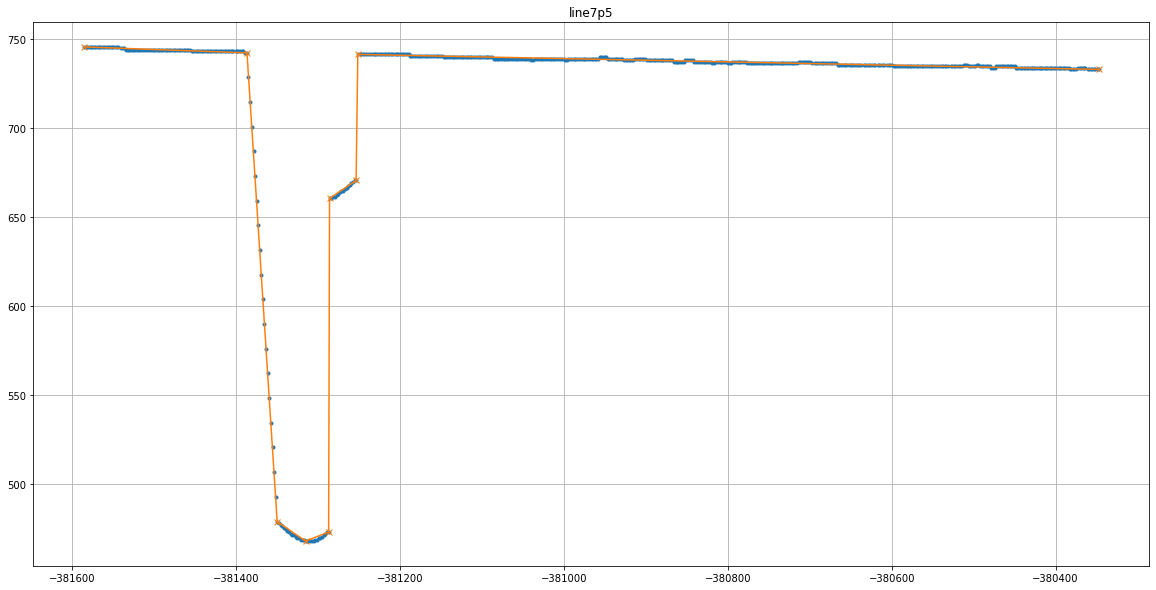

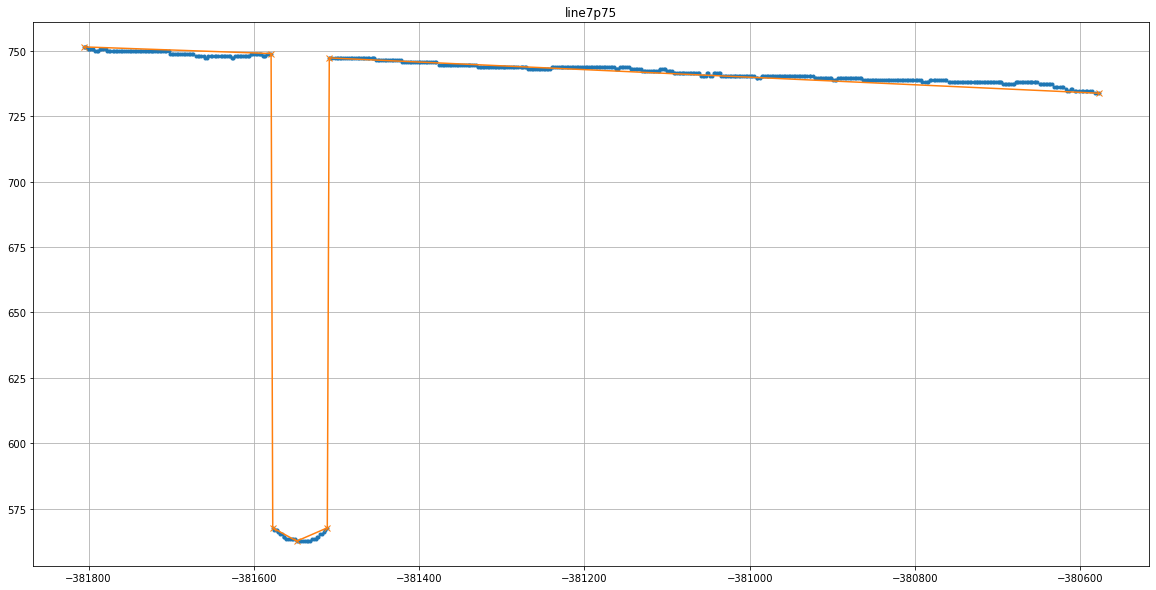

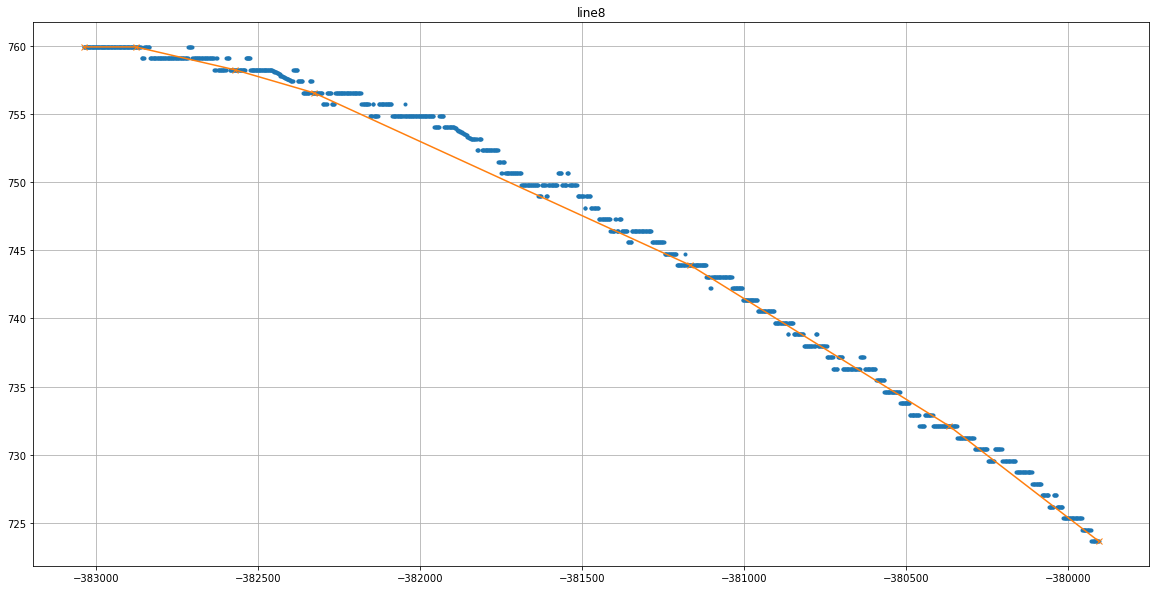

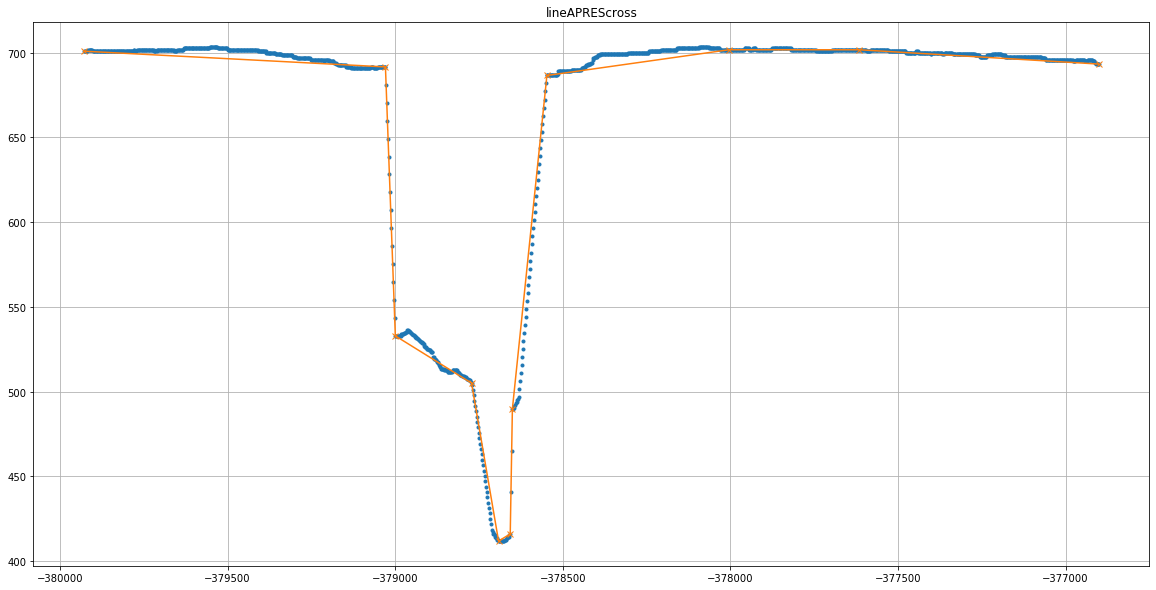

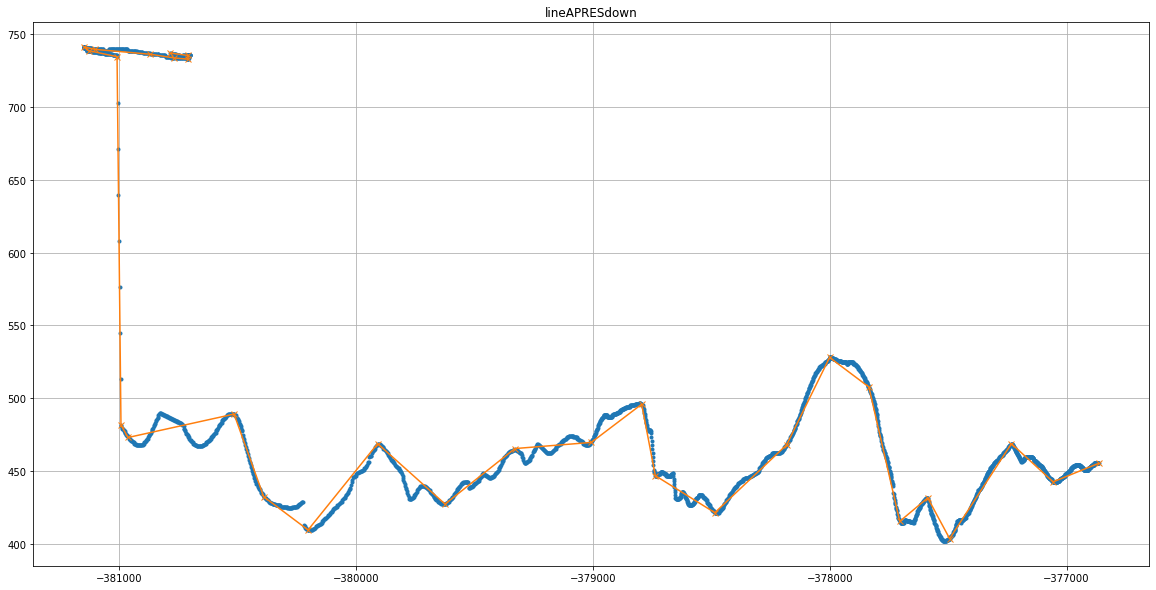

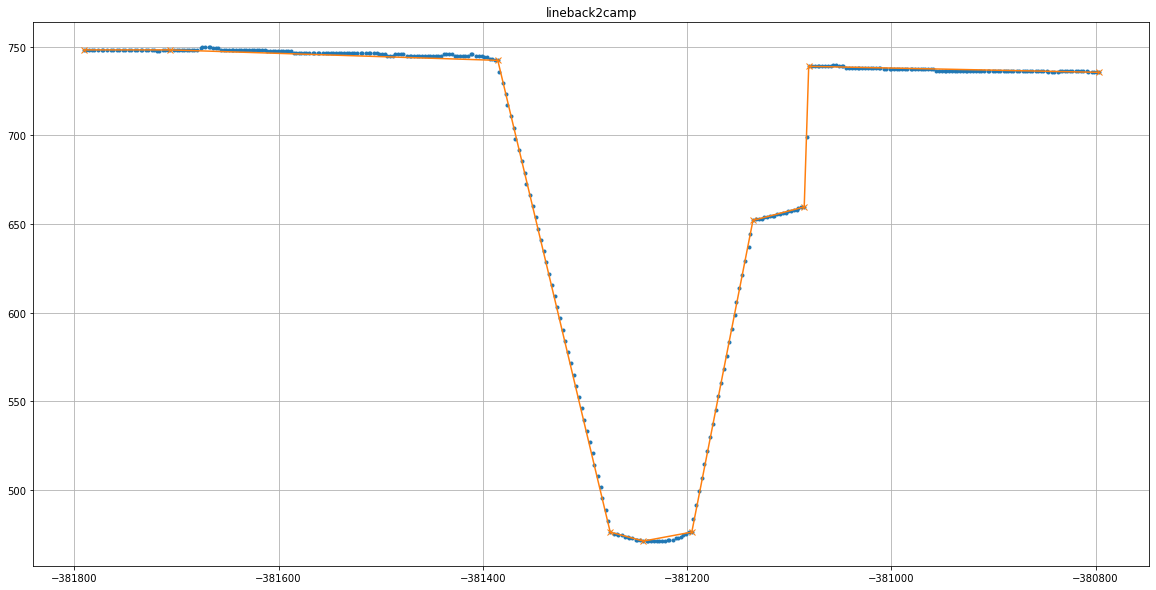

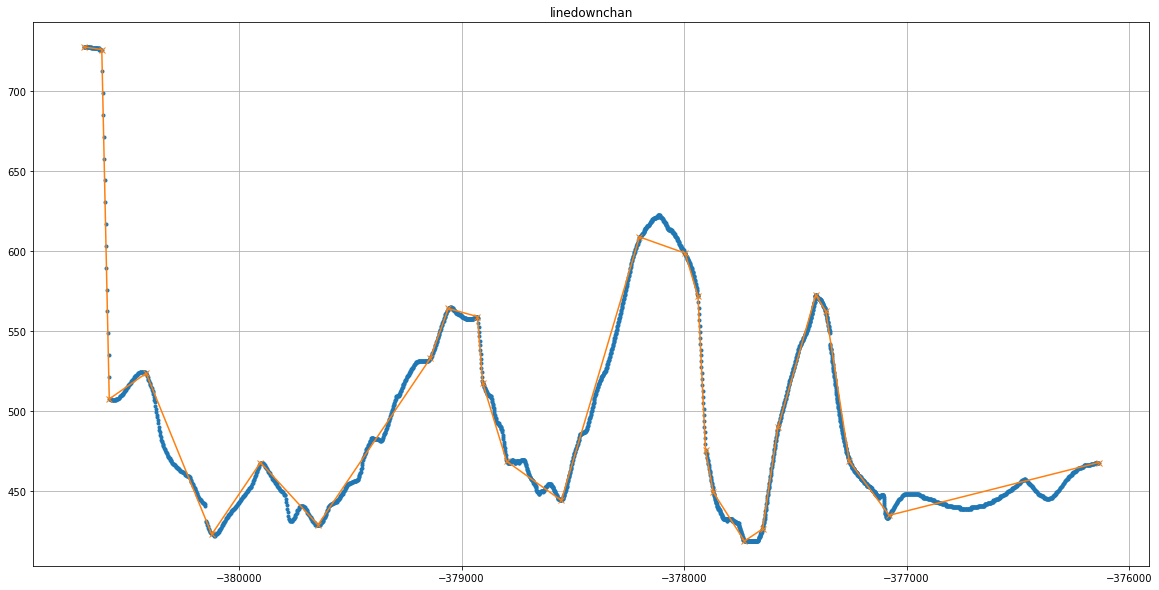

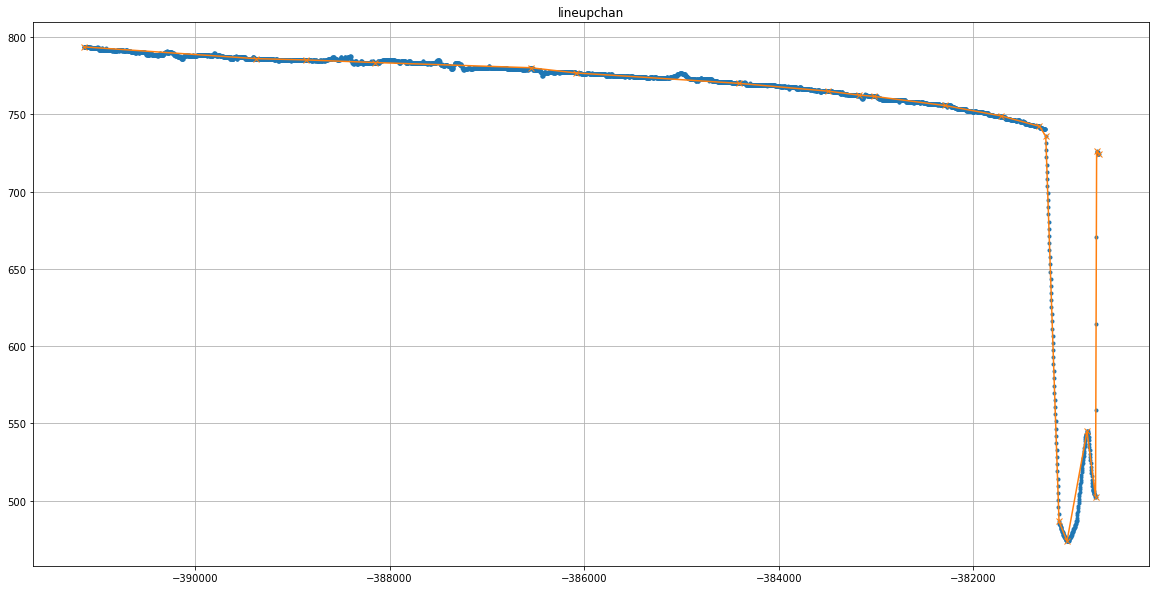

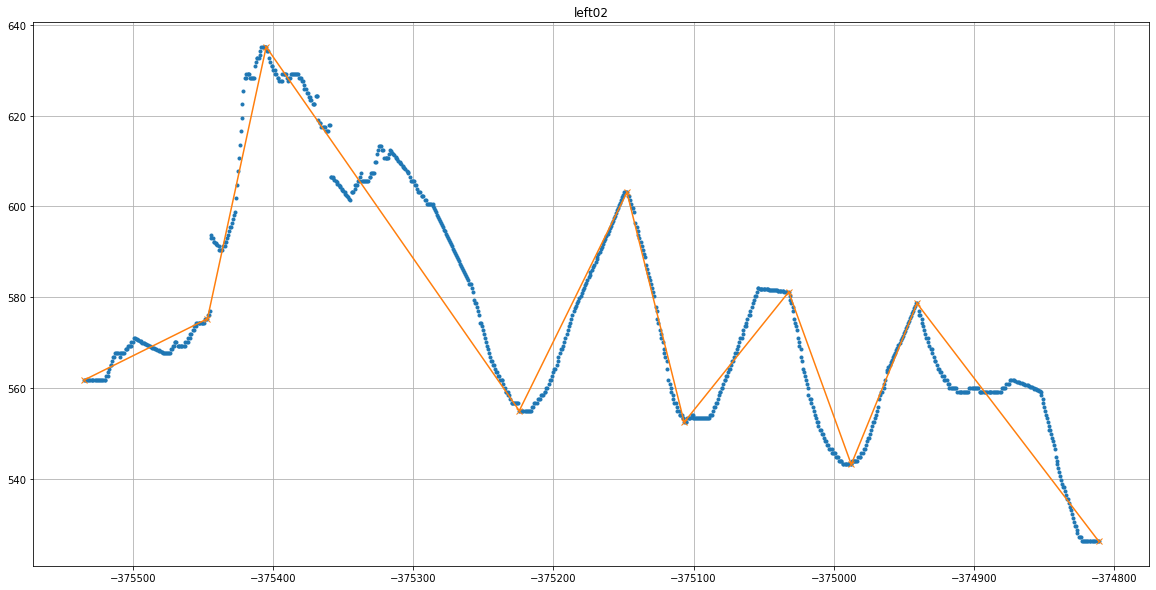

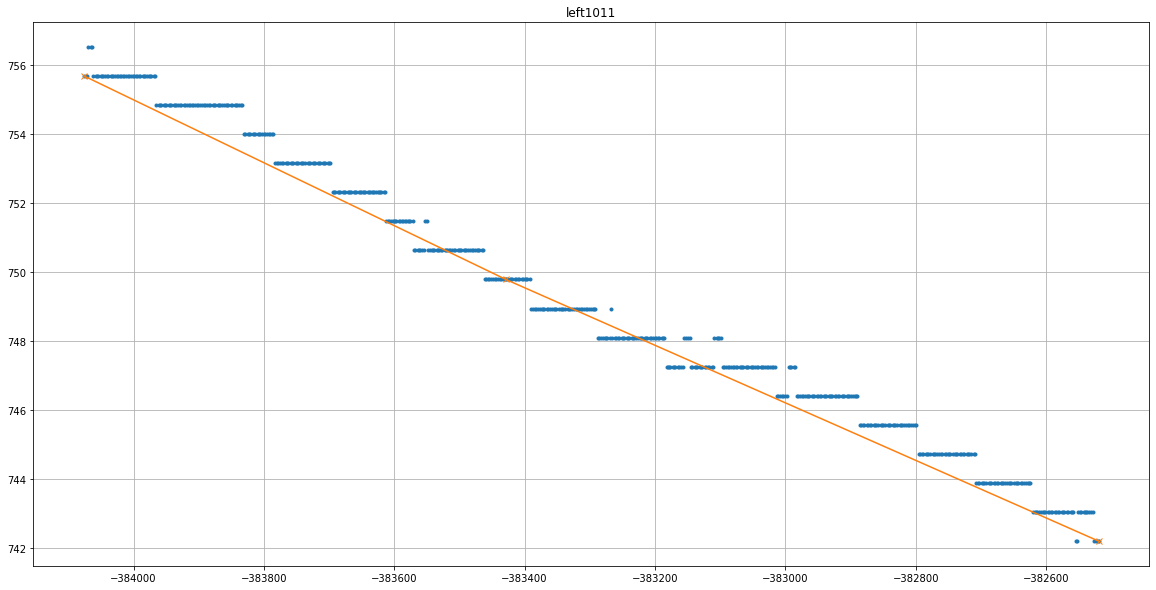

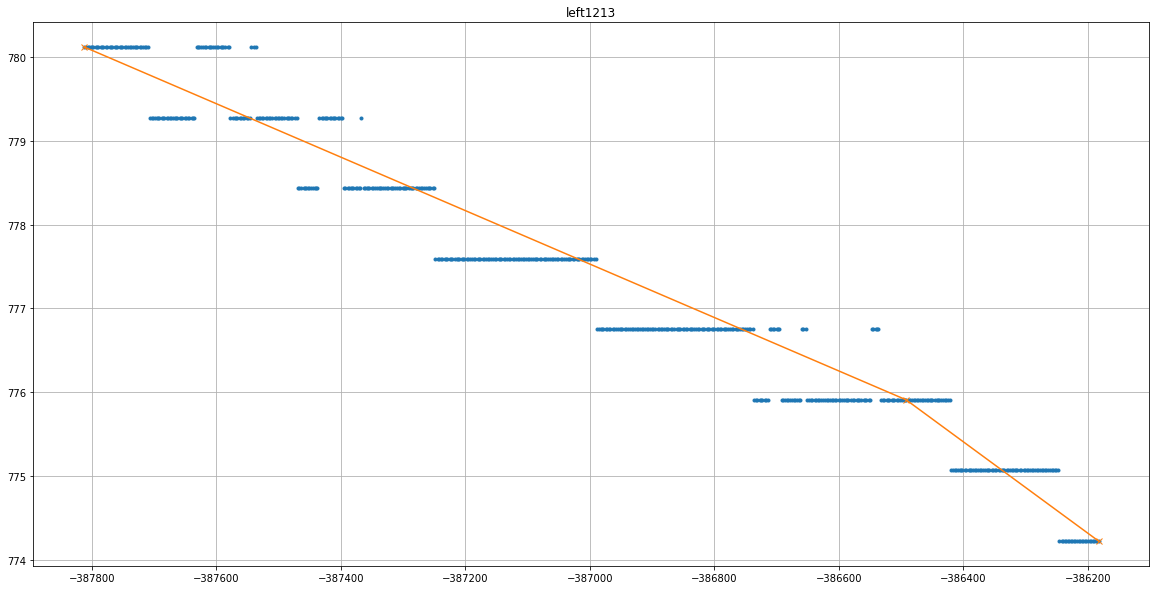

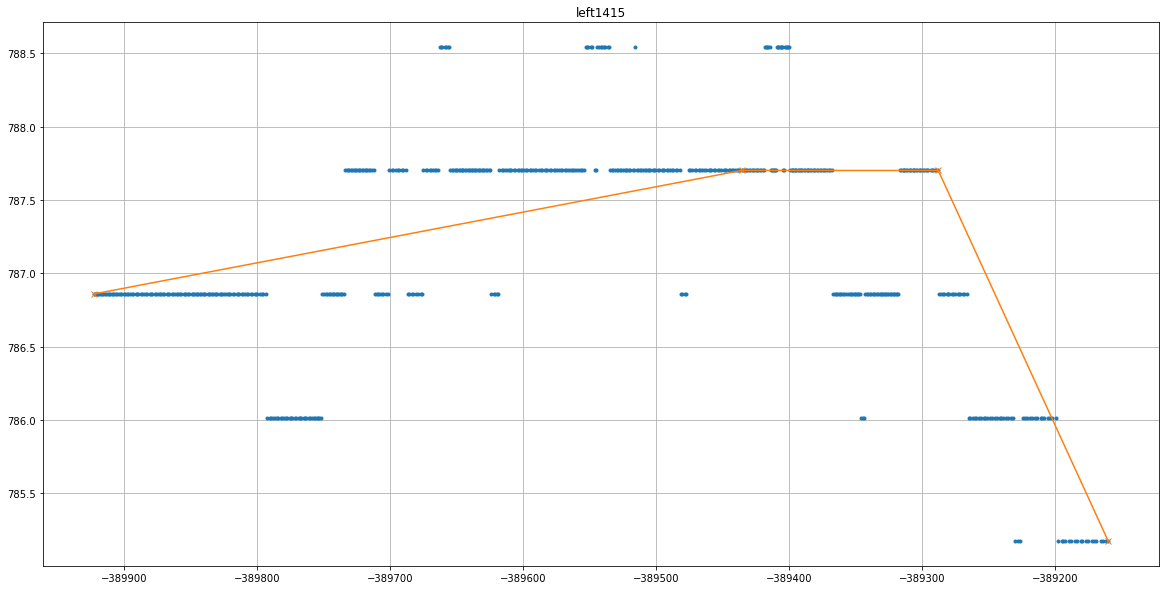

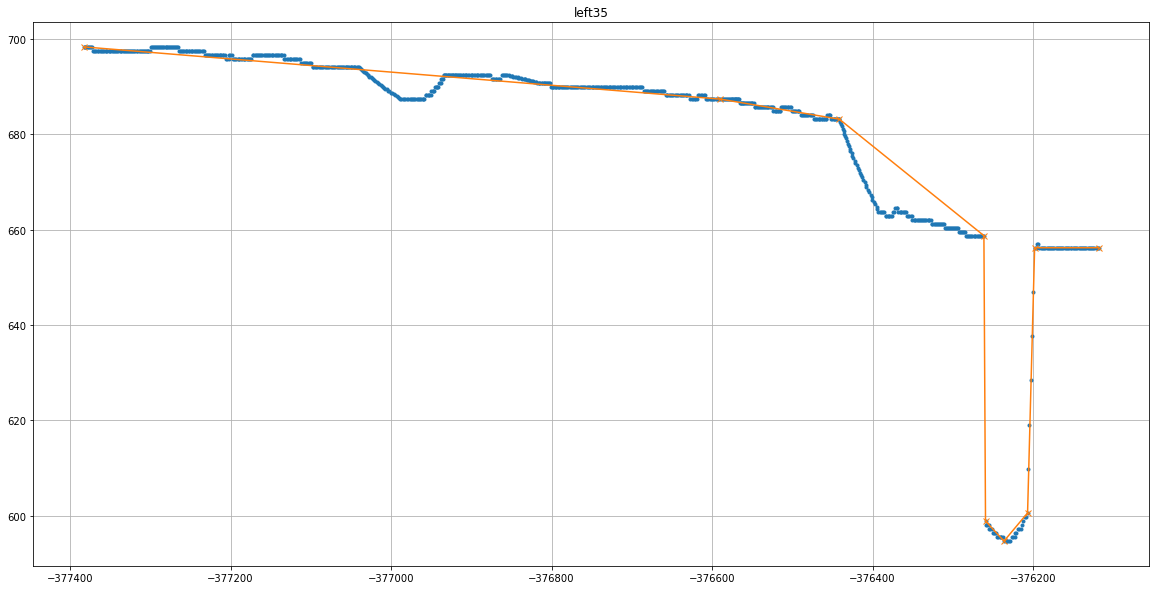

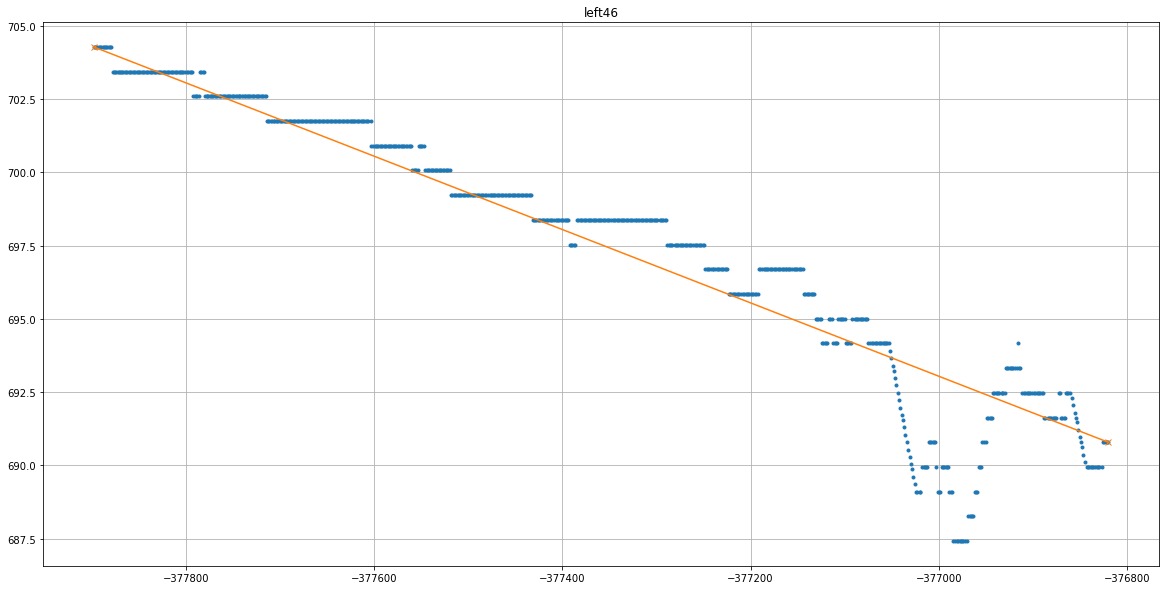

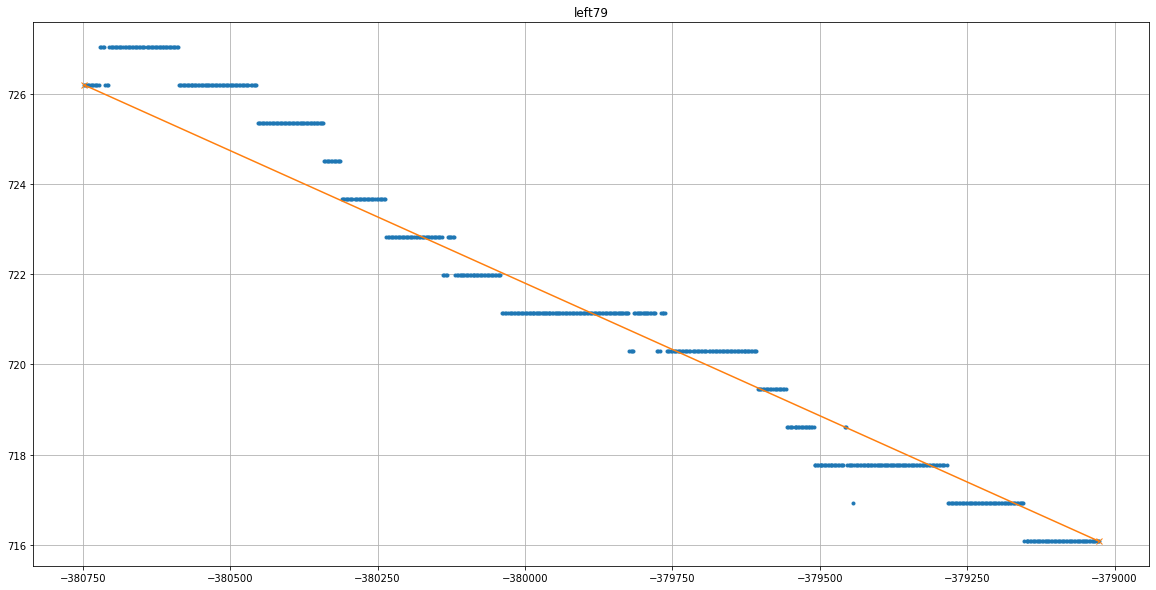

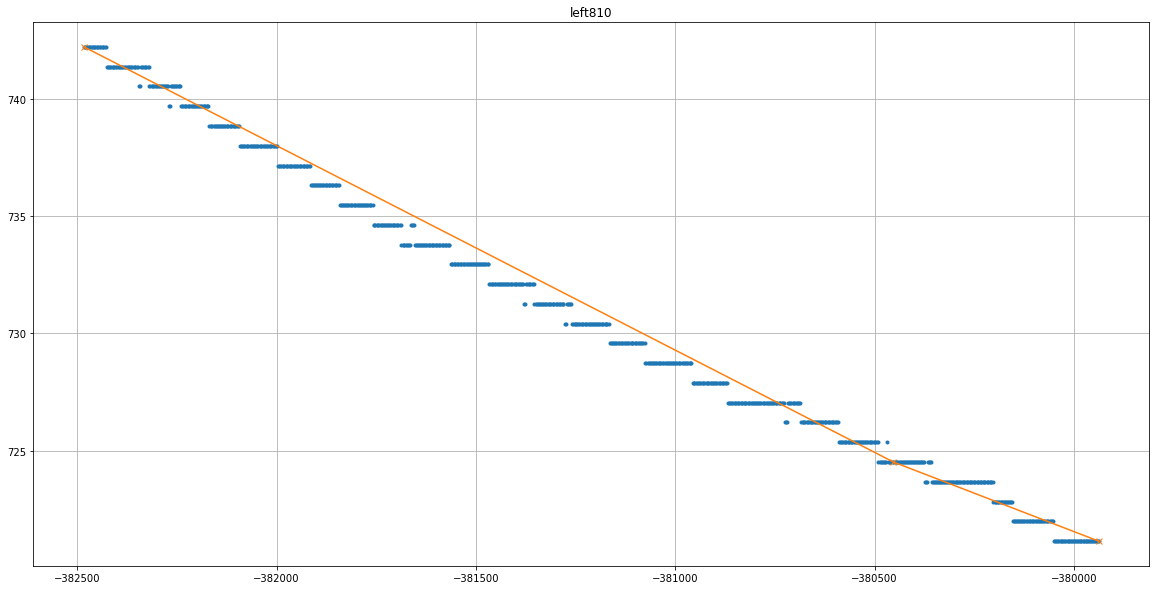

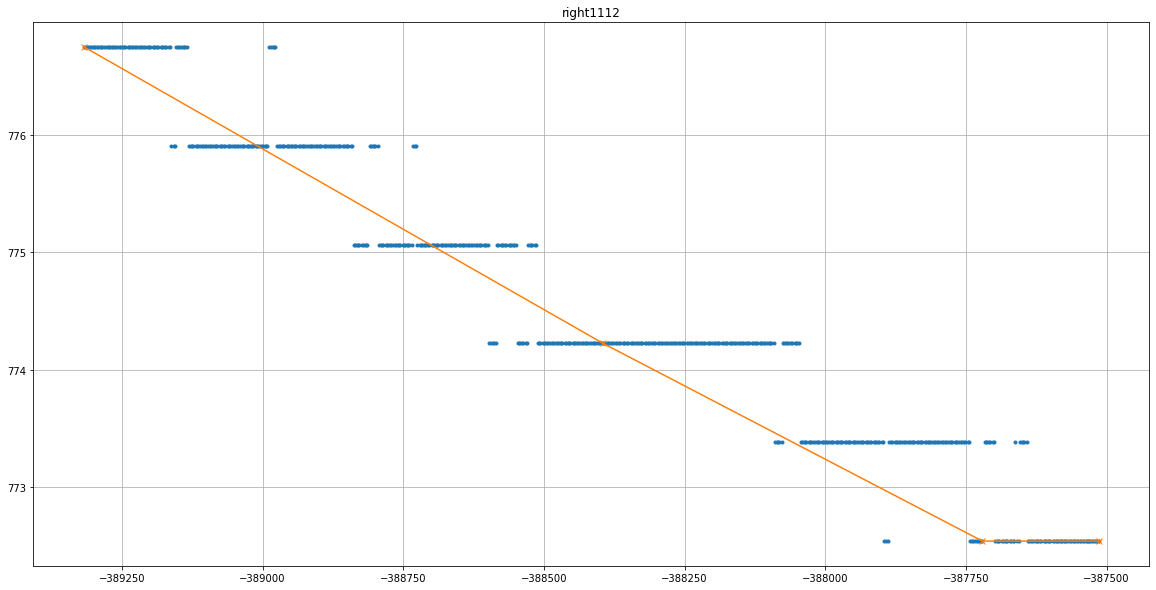

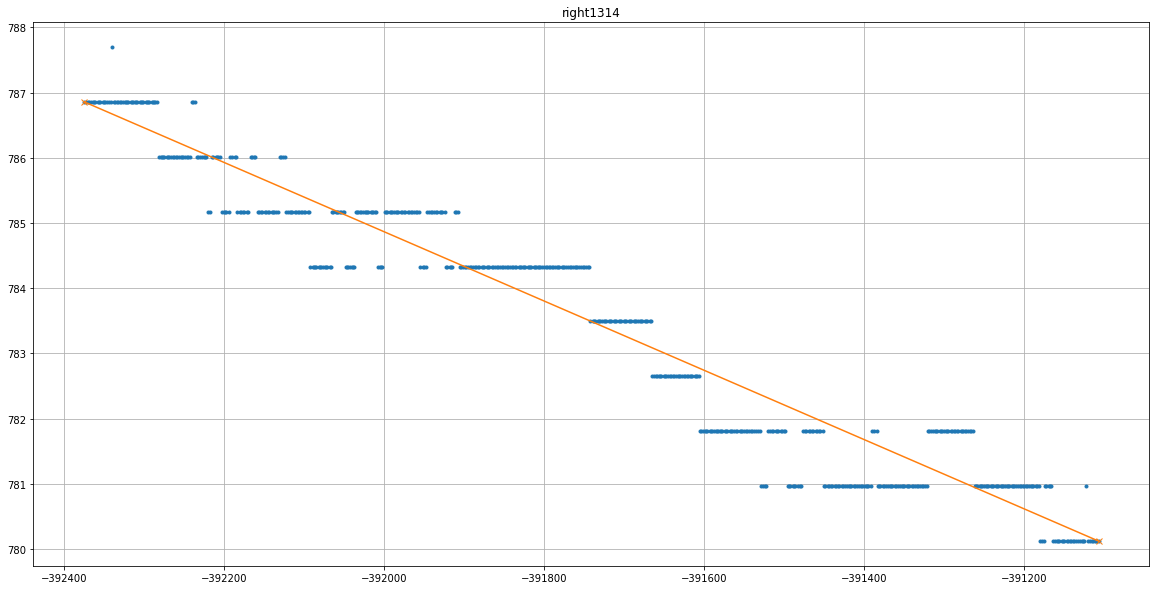

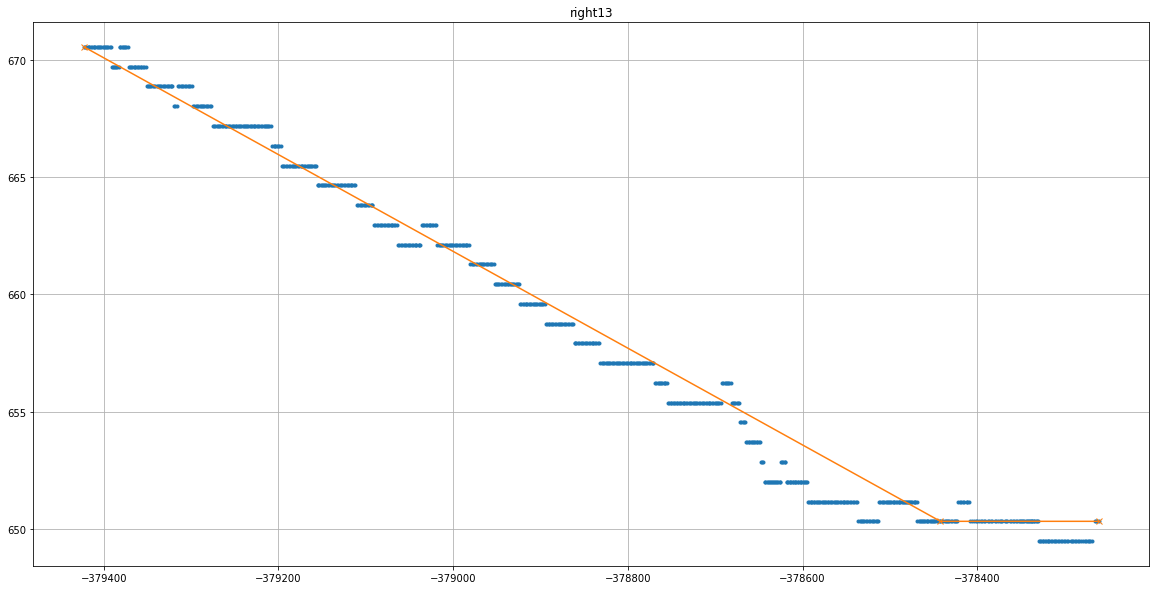

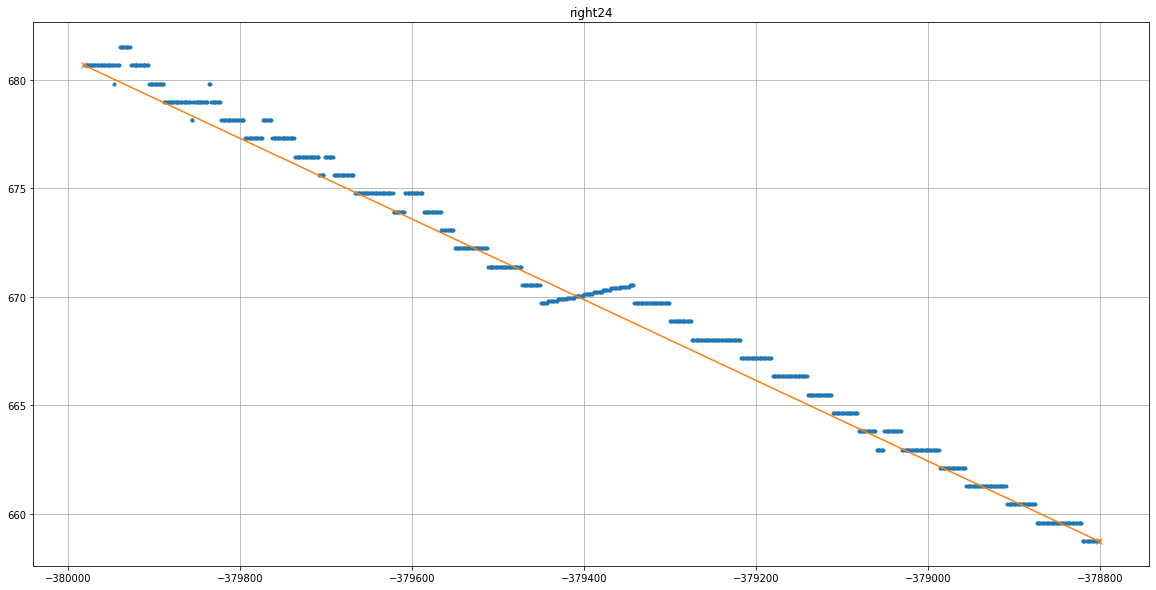

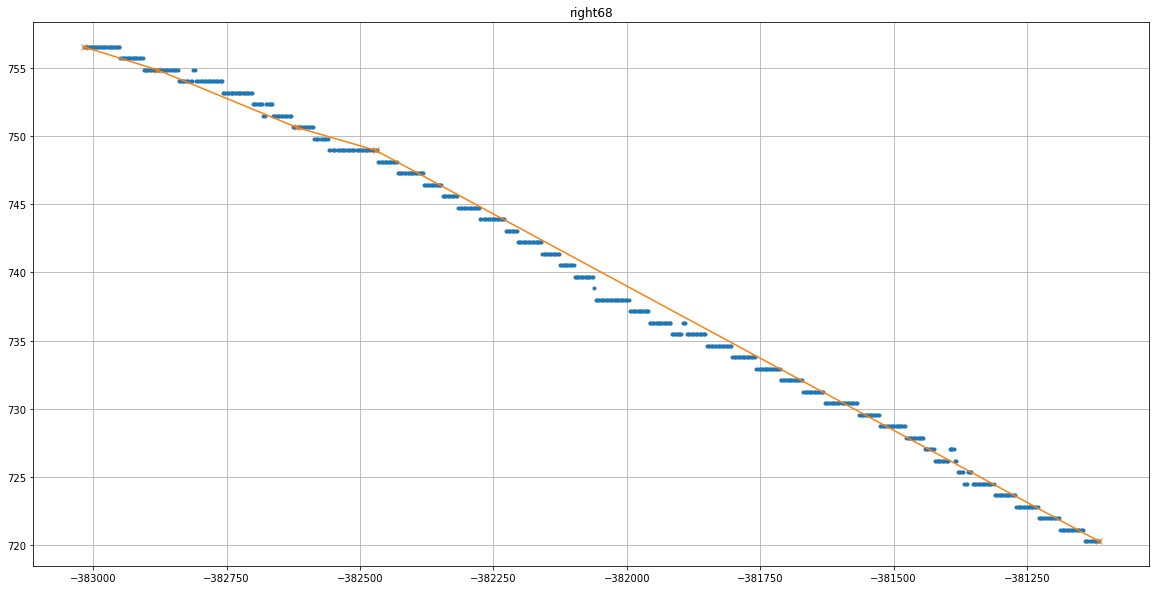

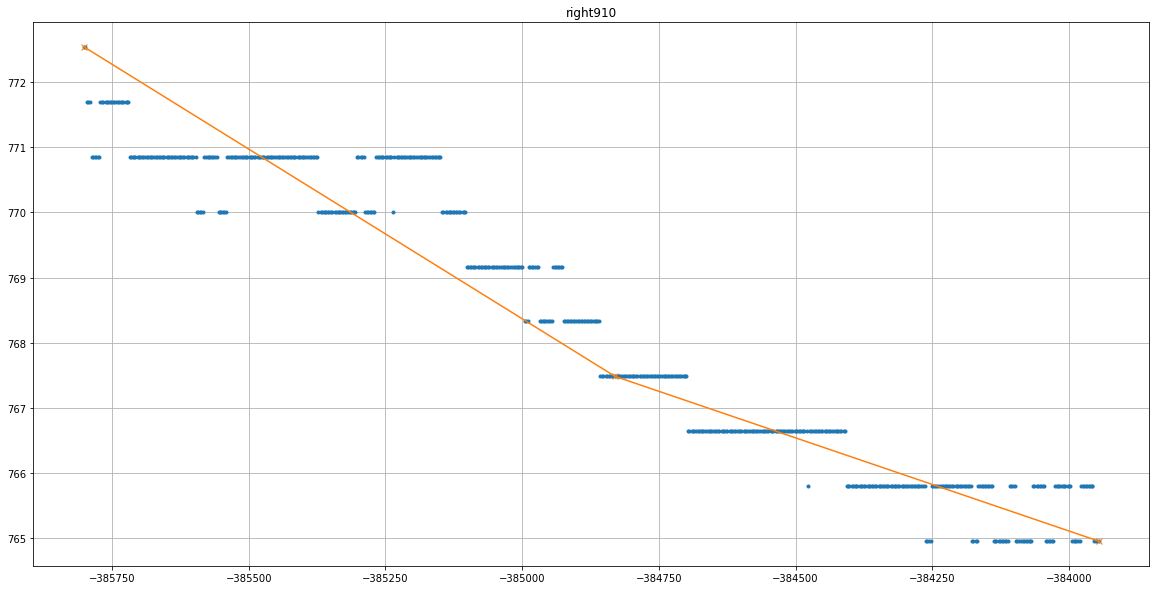

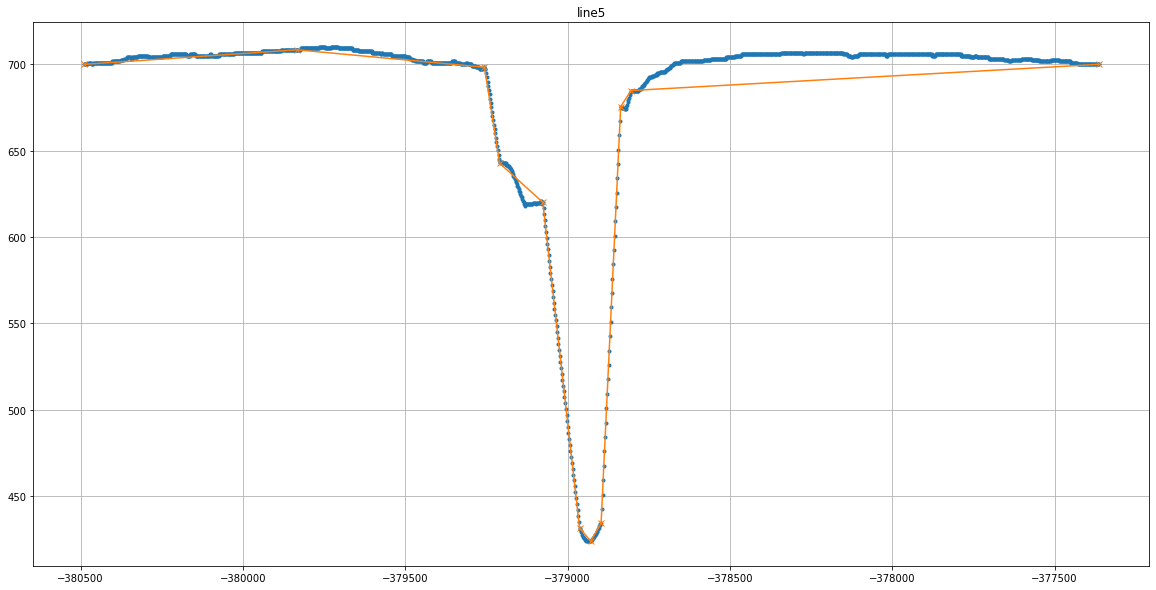

In [28]:
for line_name in ll.keys():
    plot_rdp(line_name,epsilon=20)

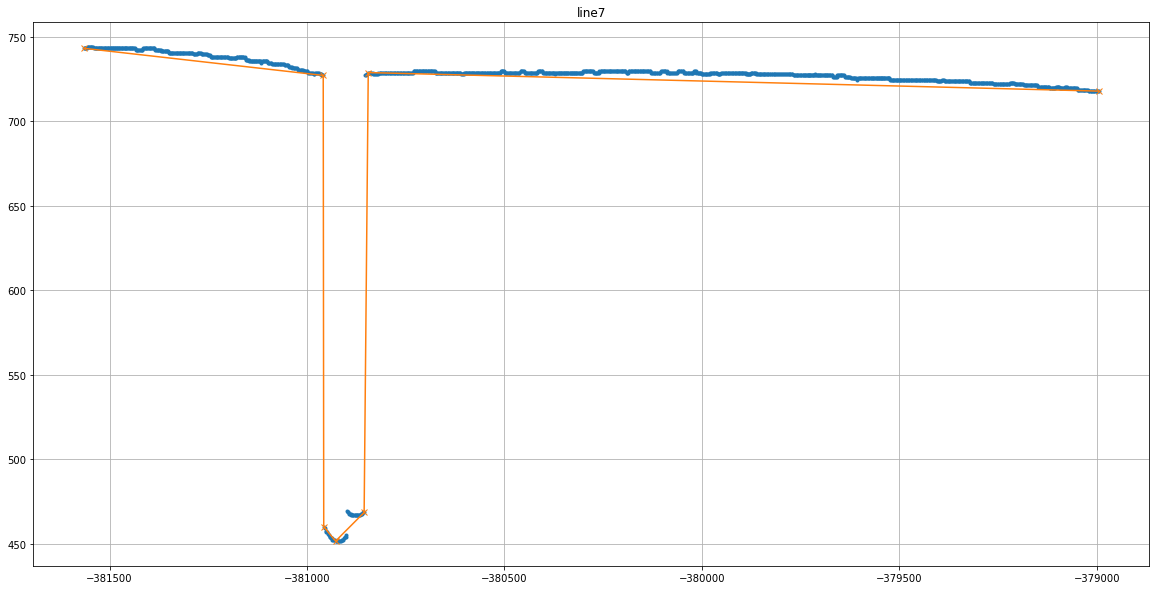

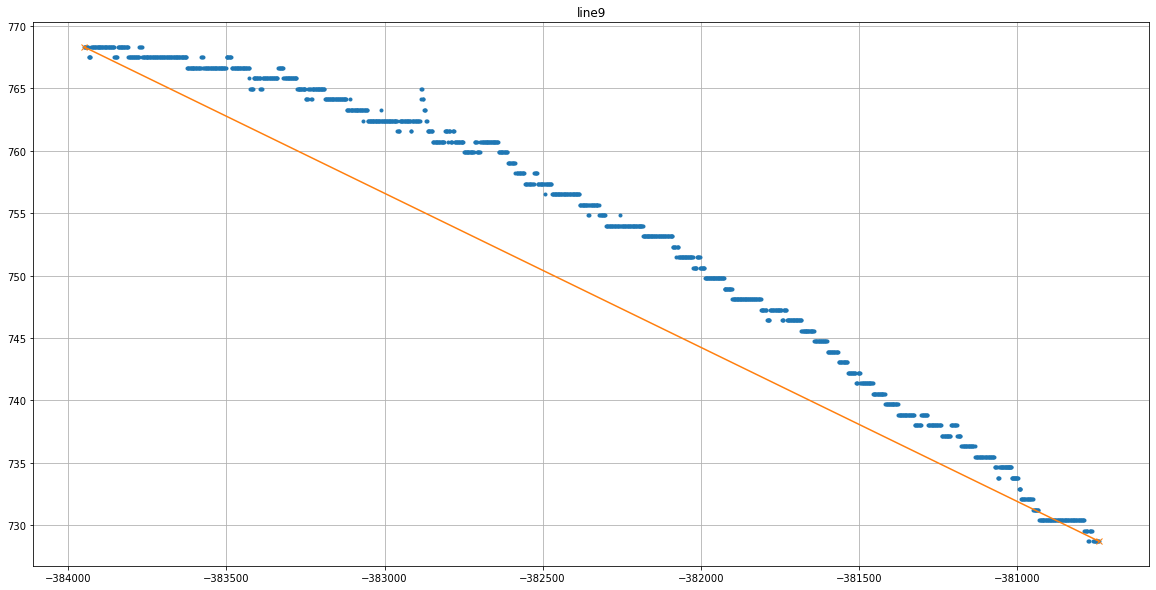

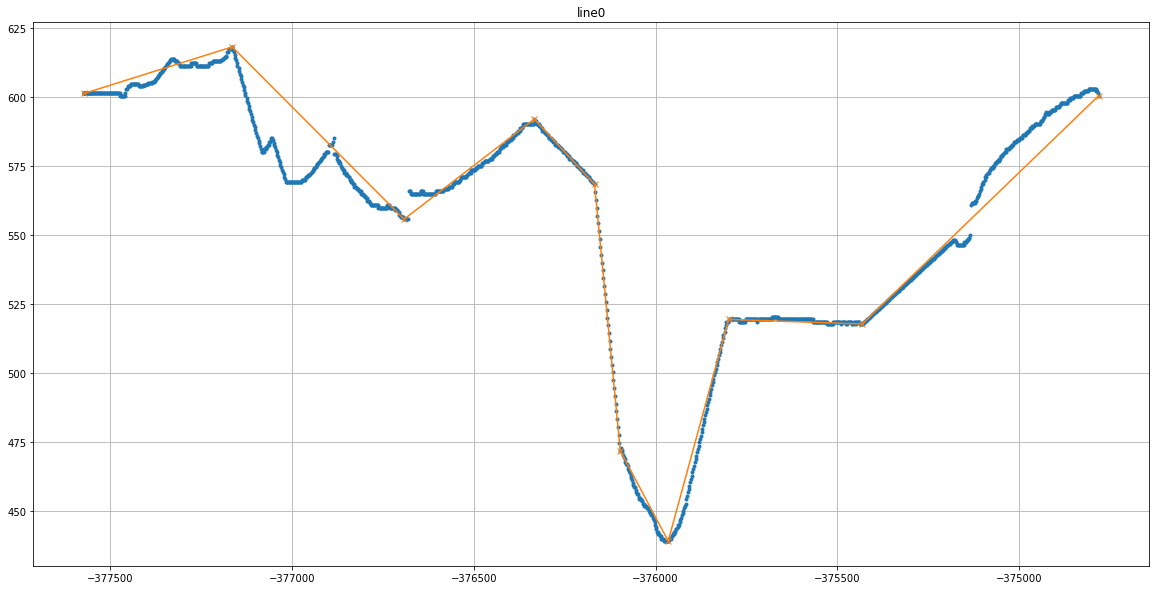

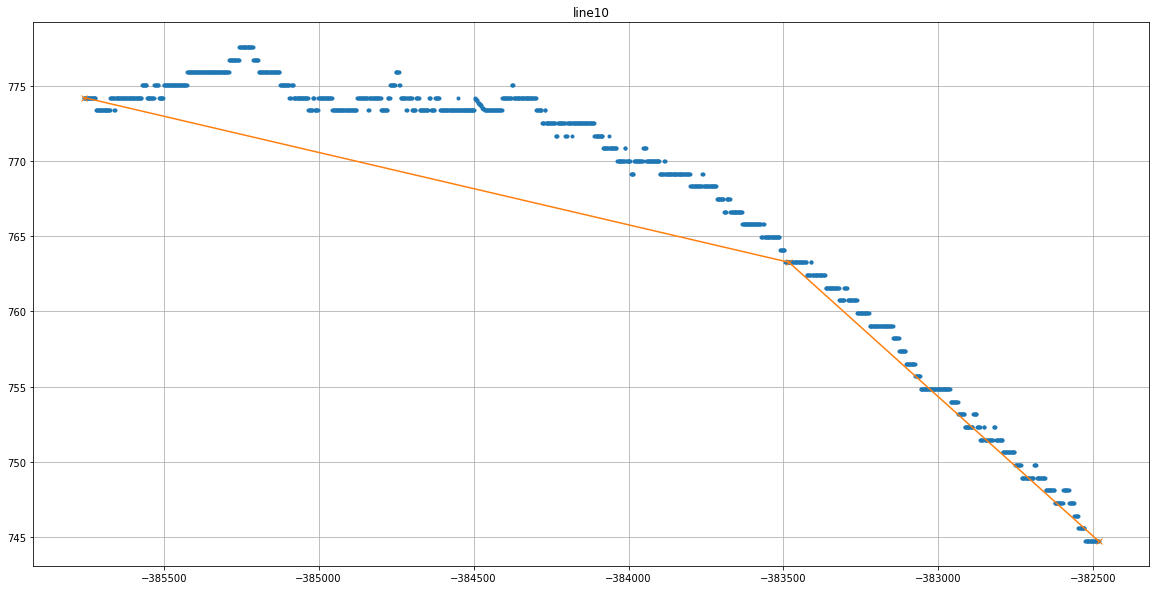

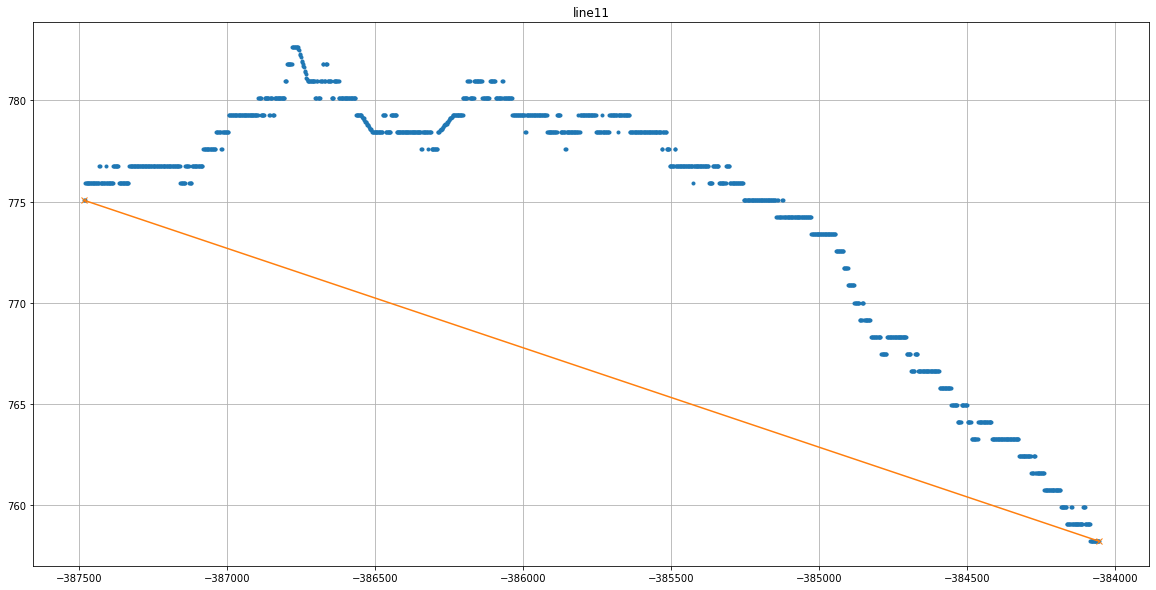

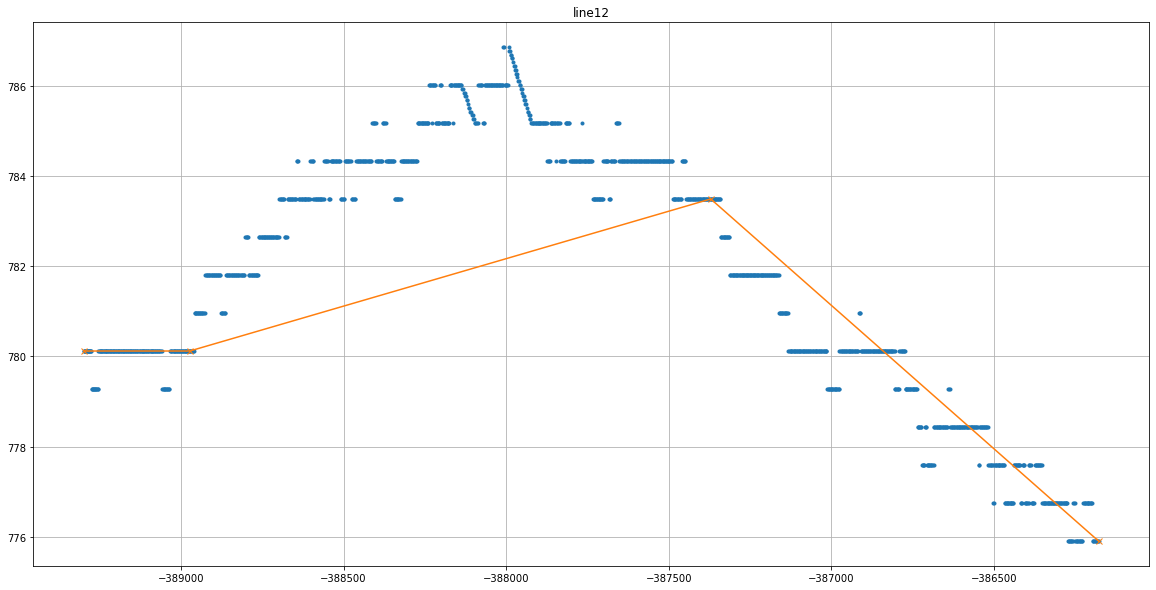

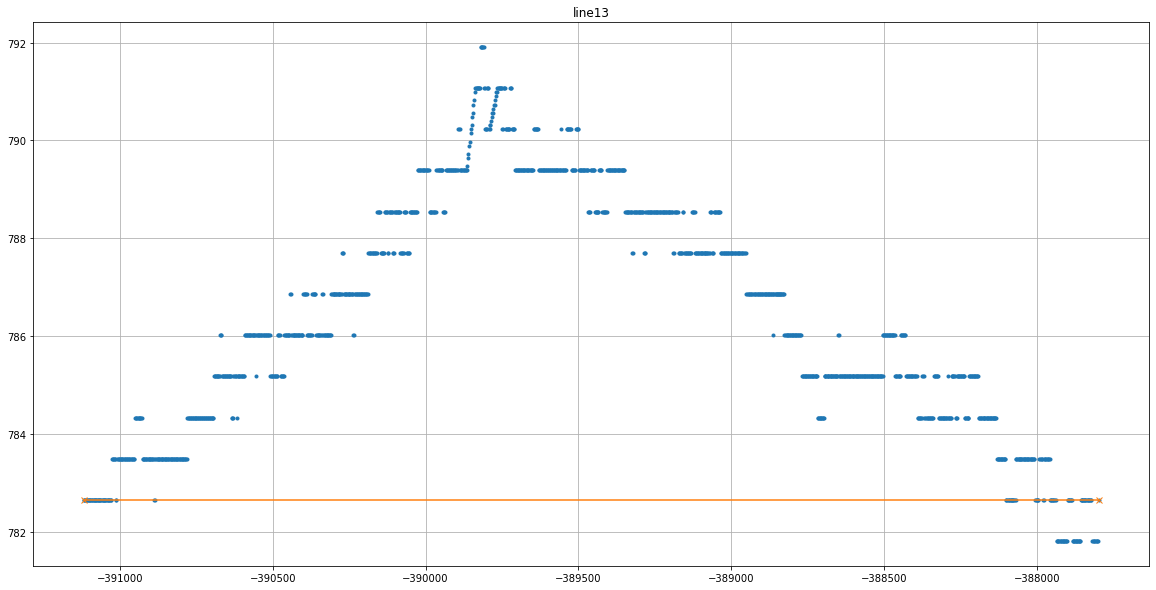

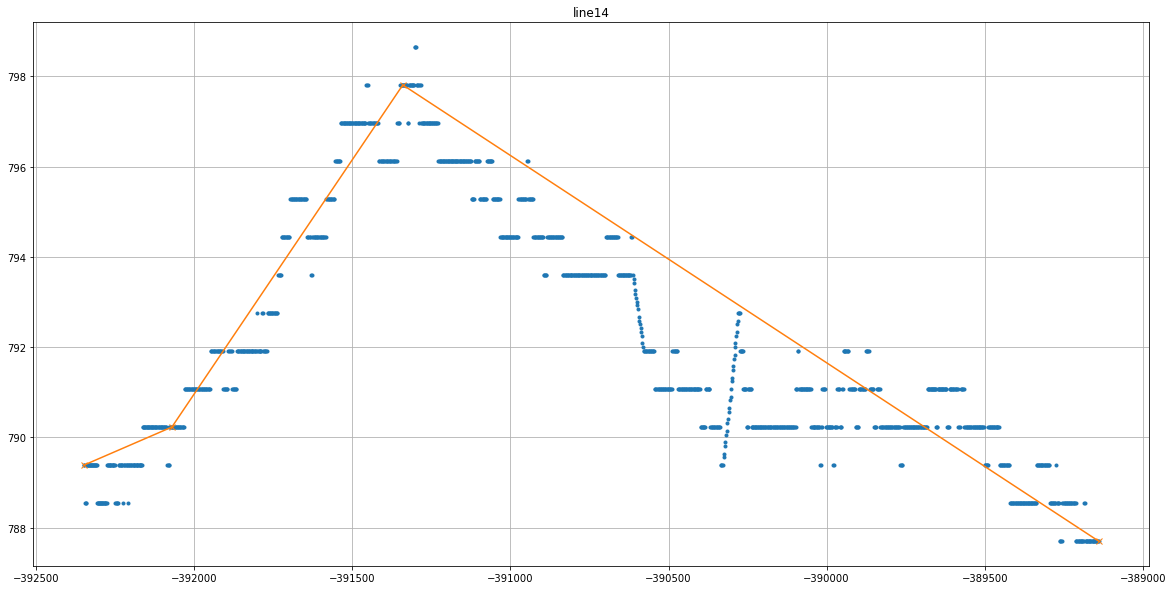

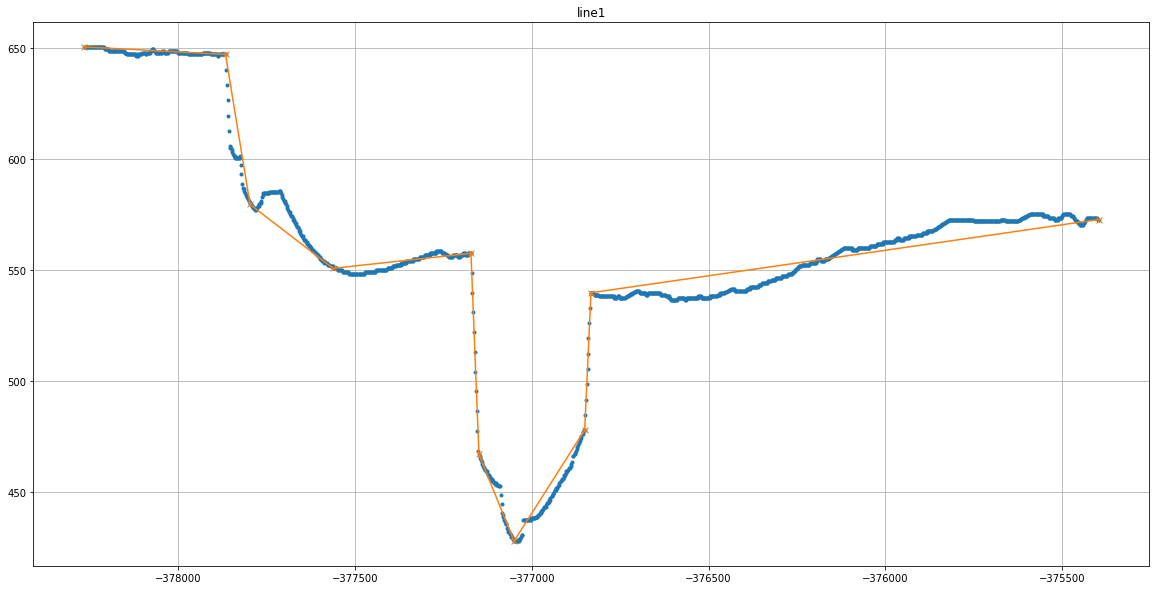

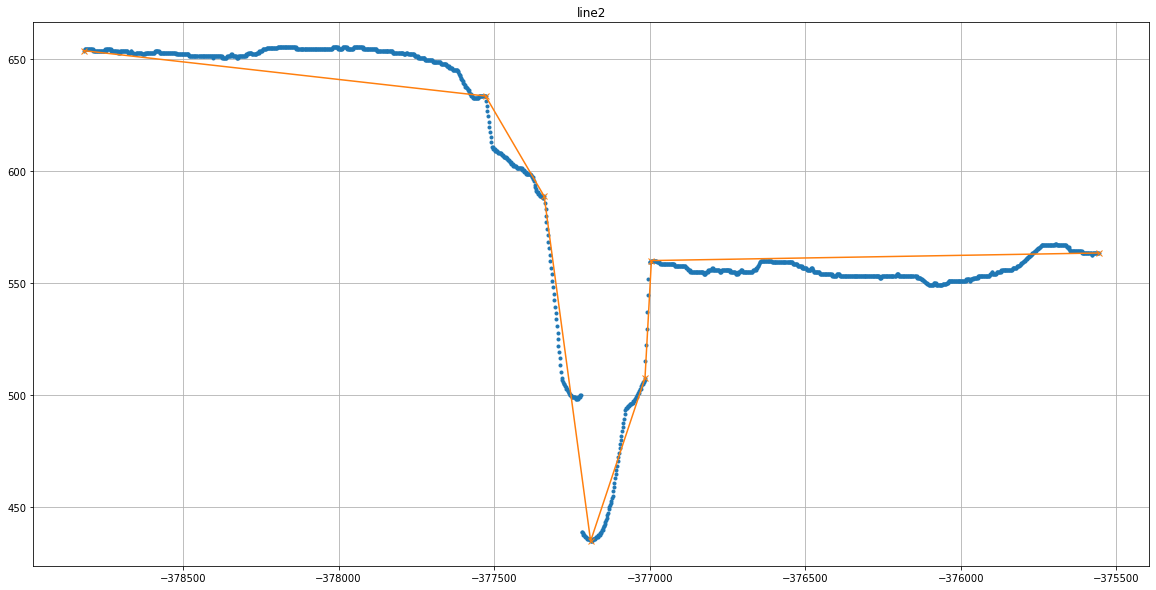

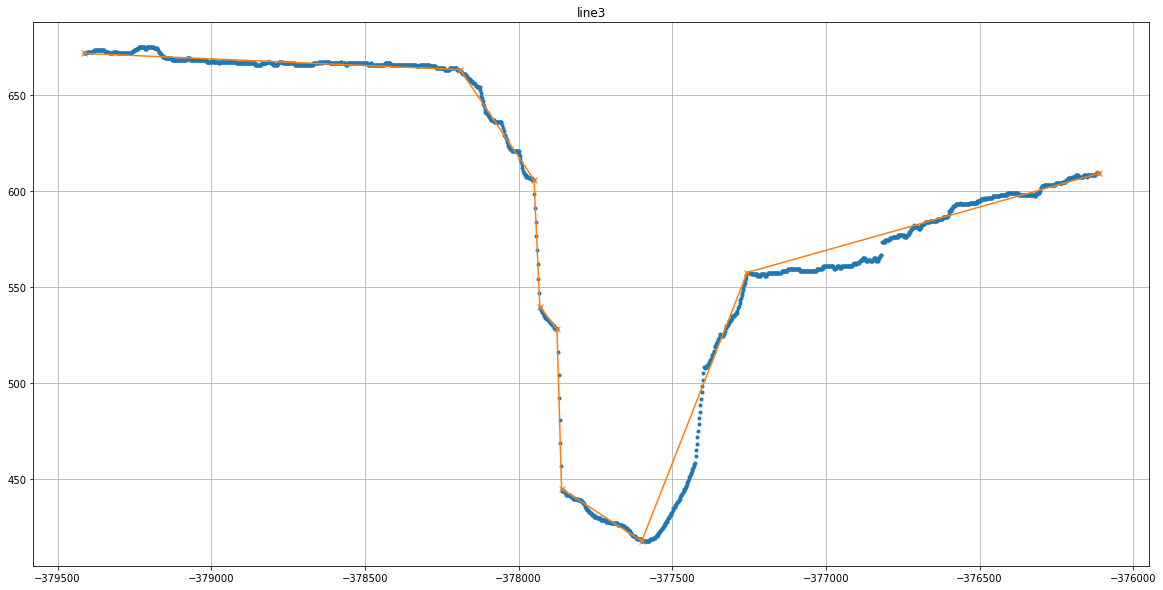

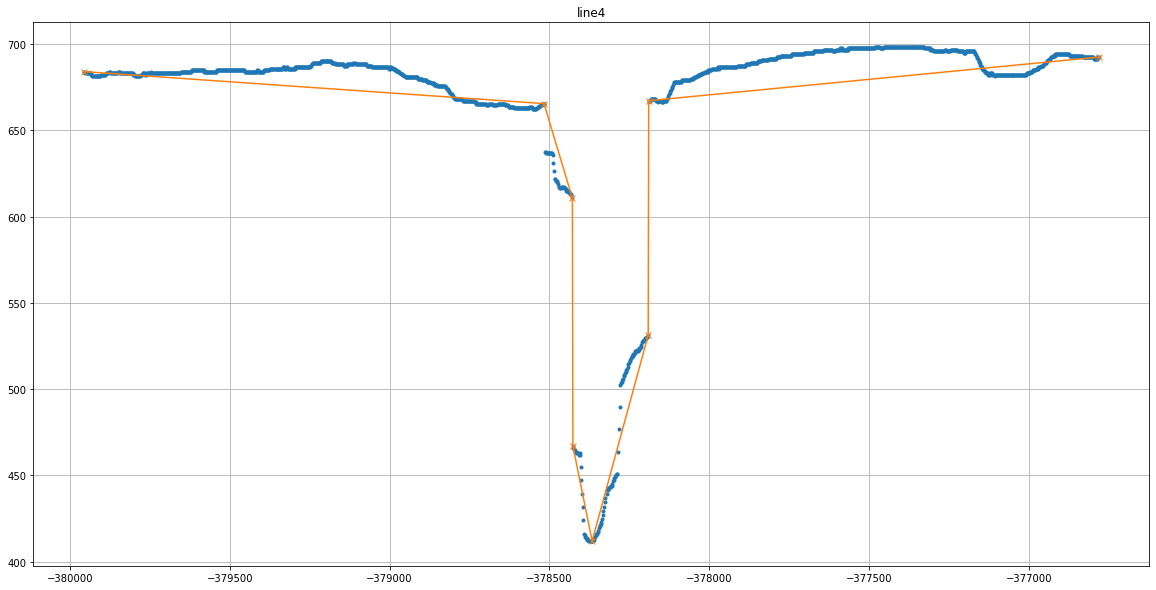

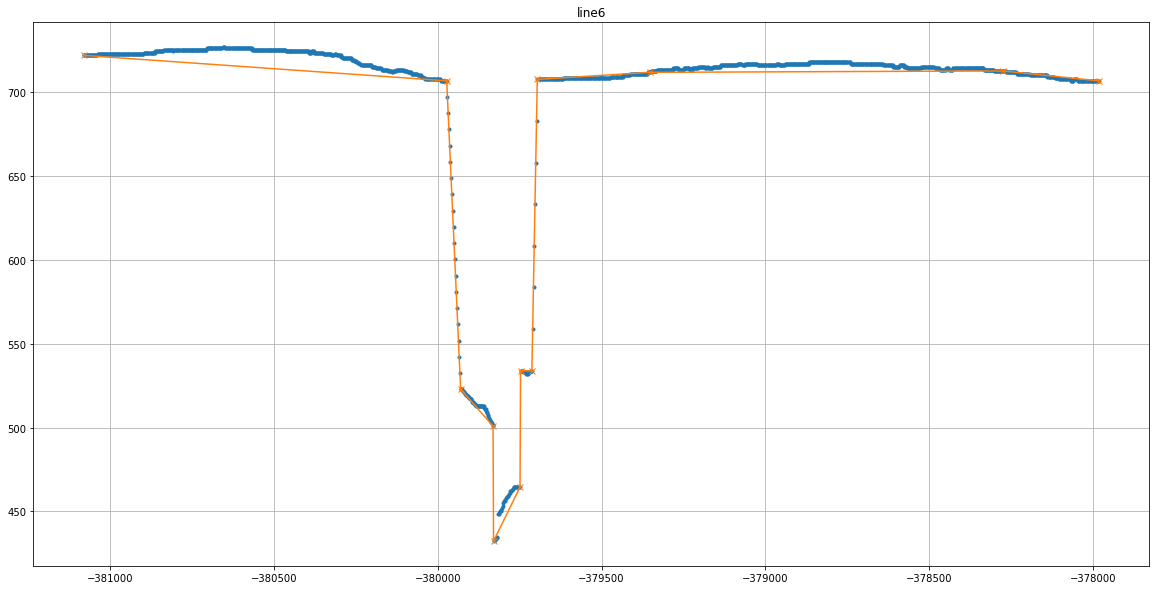

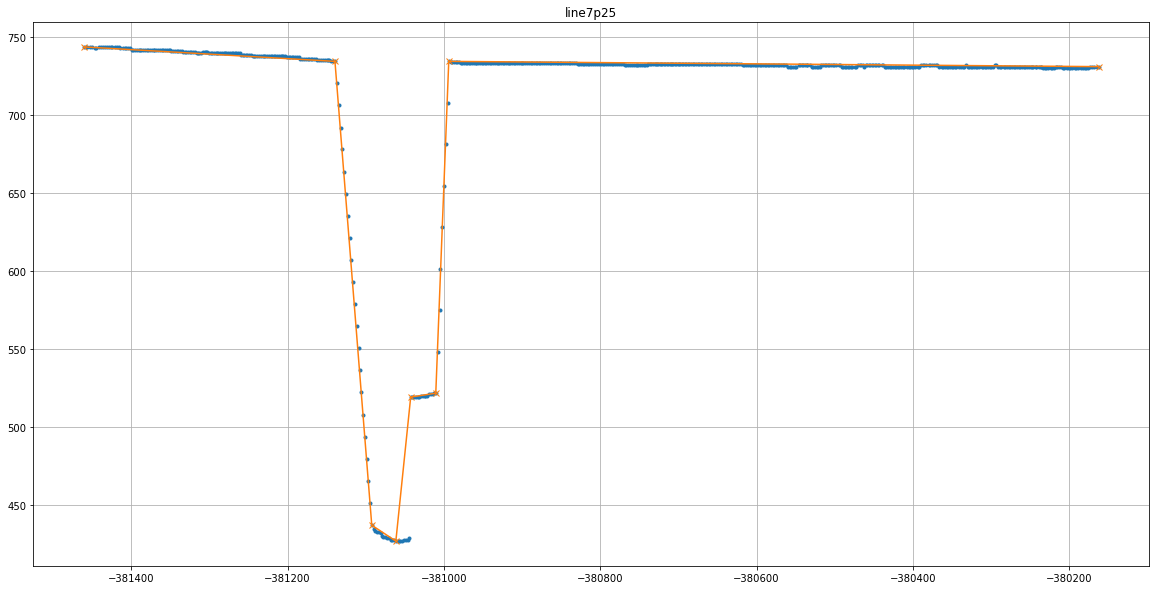

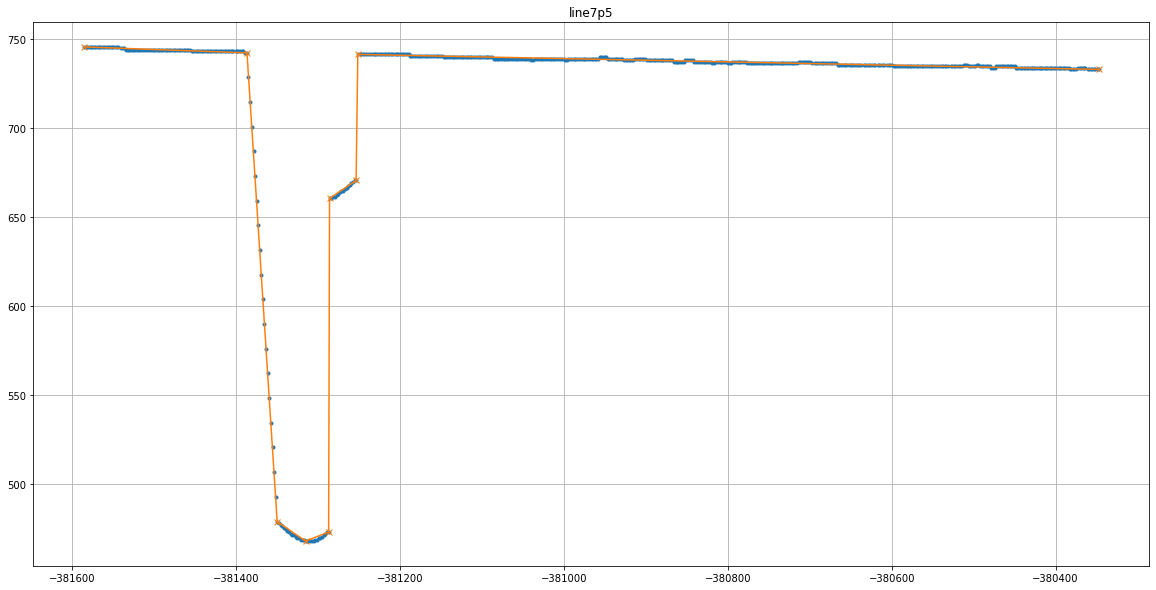

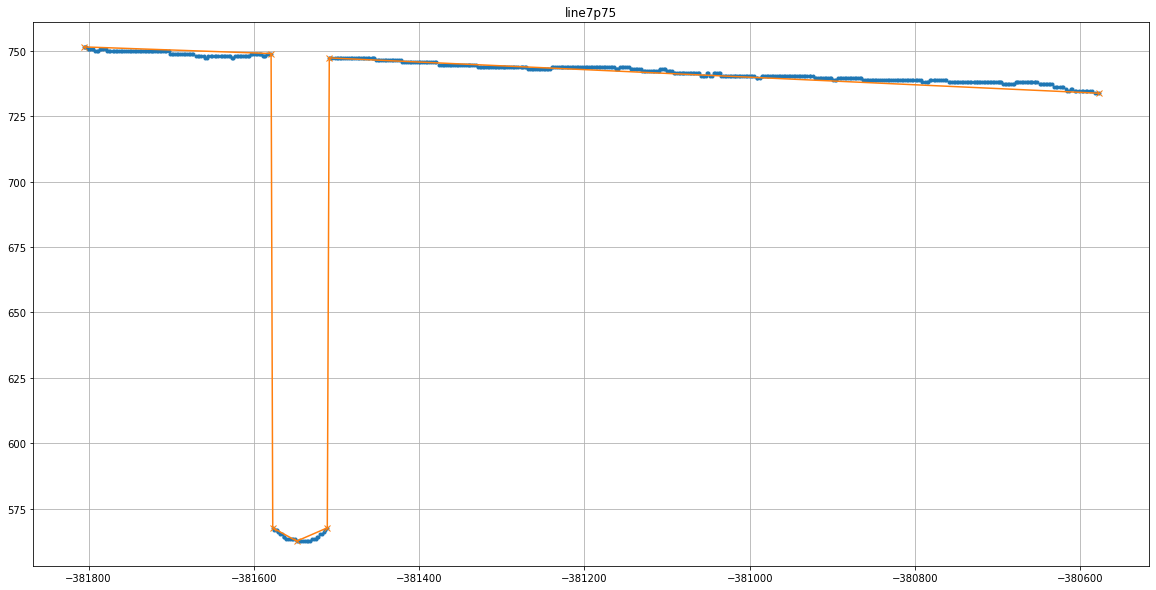

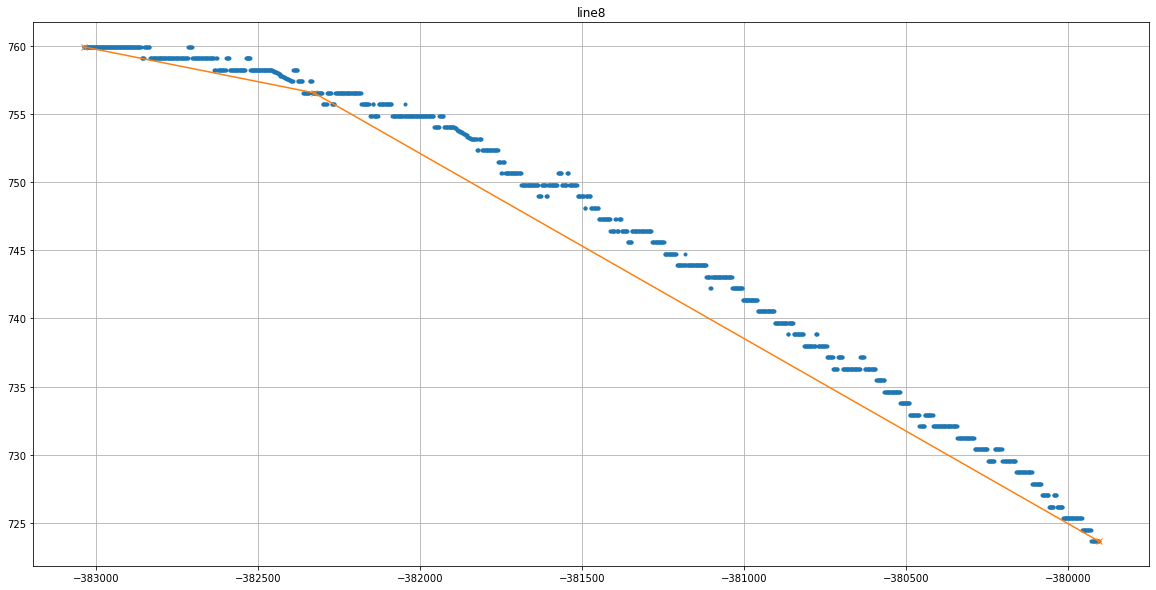

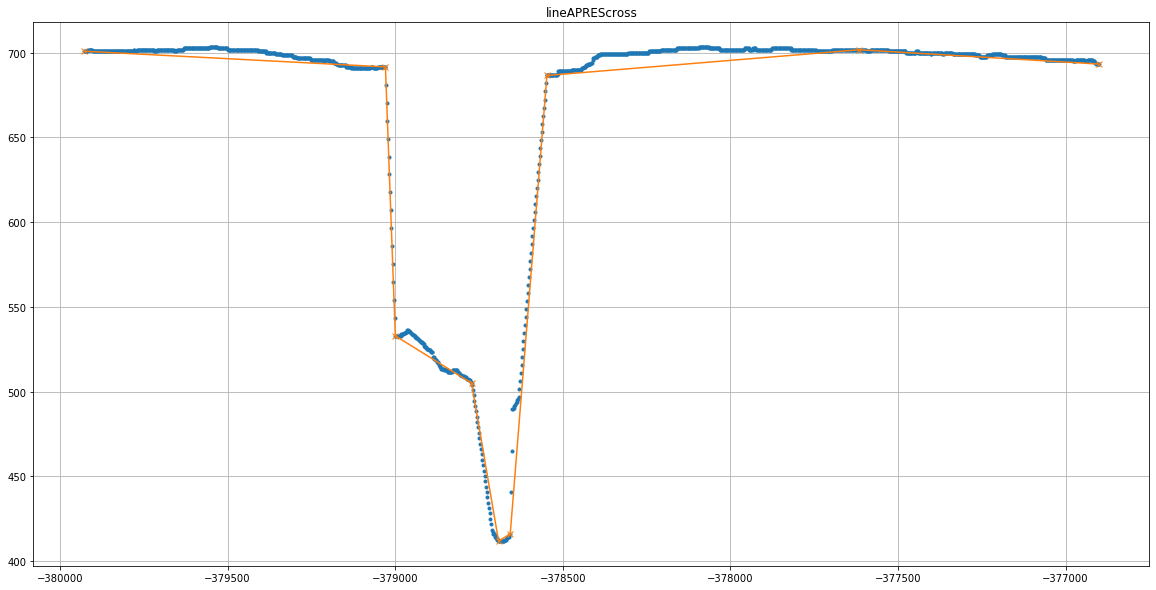

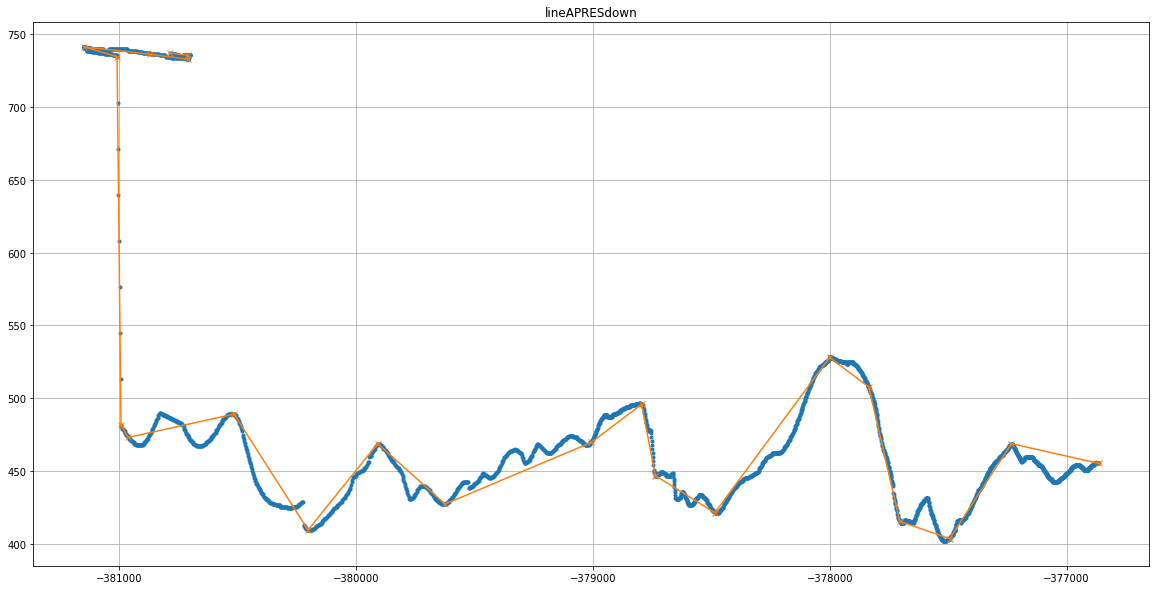

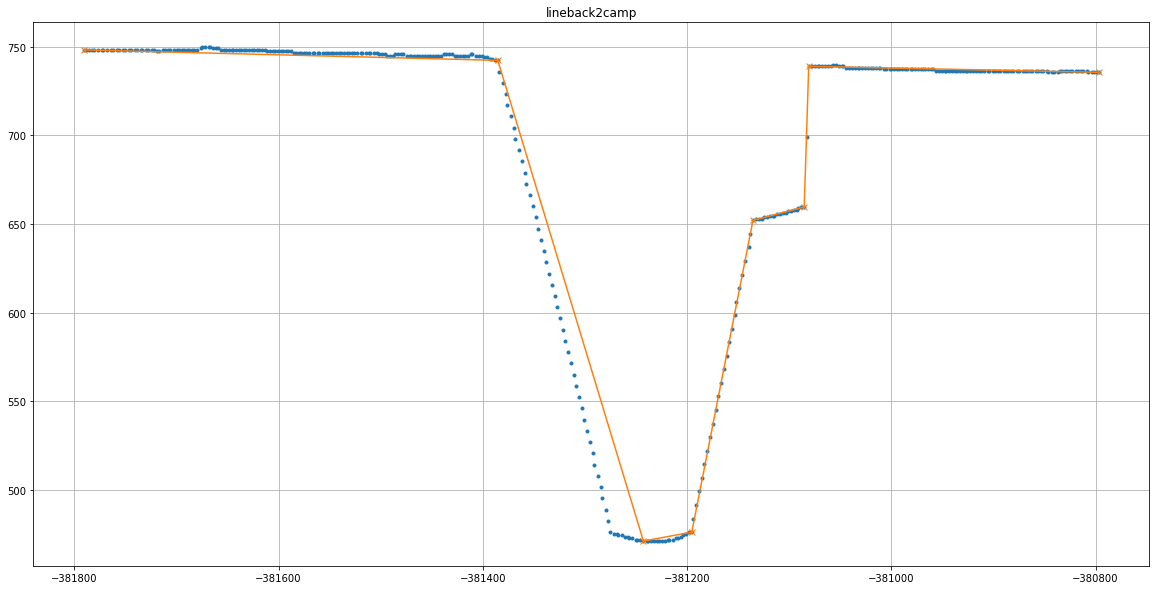

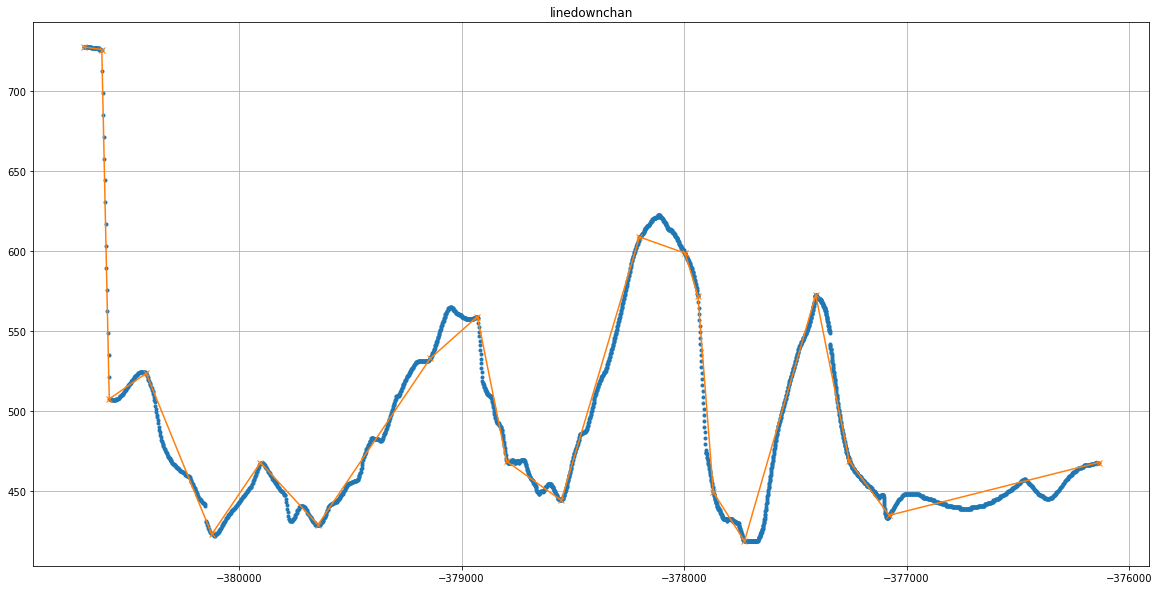

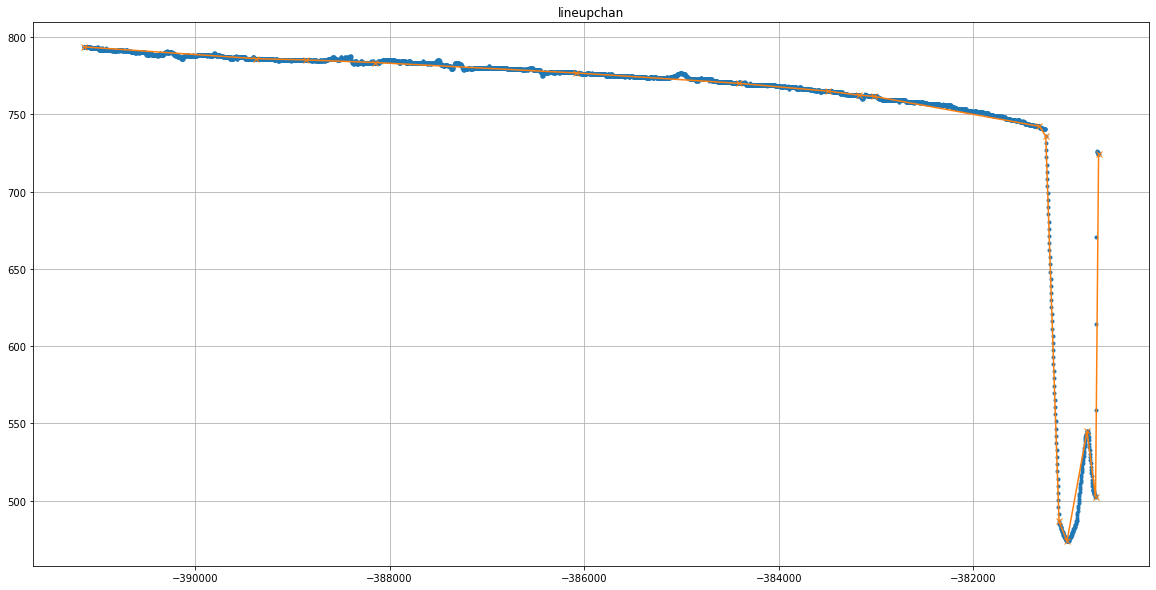

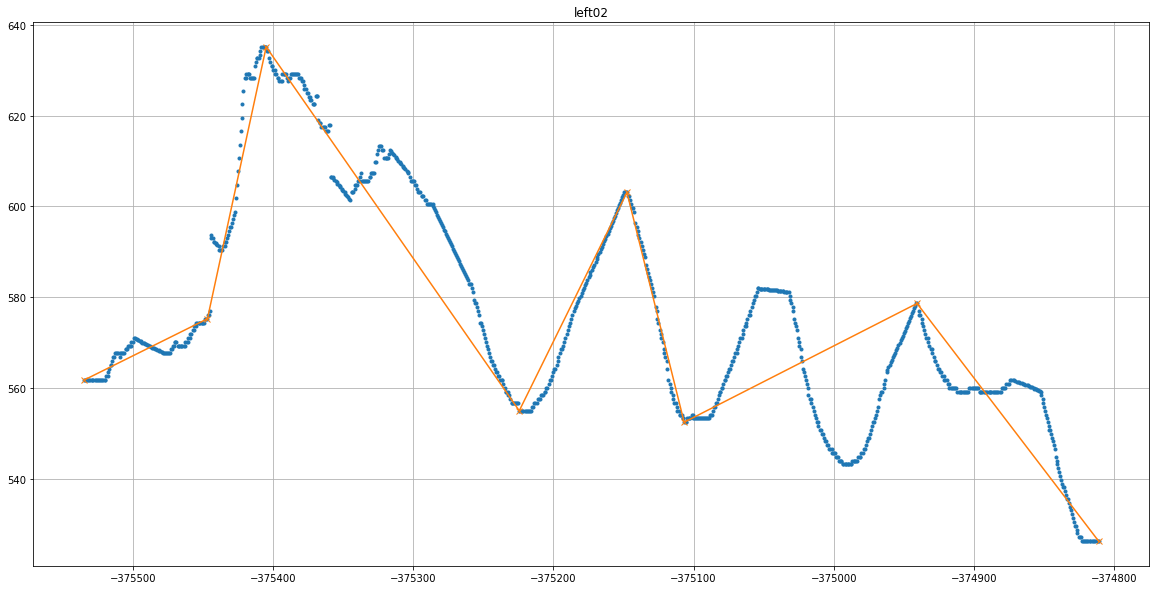

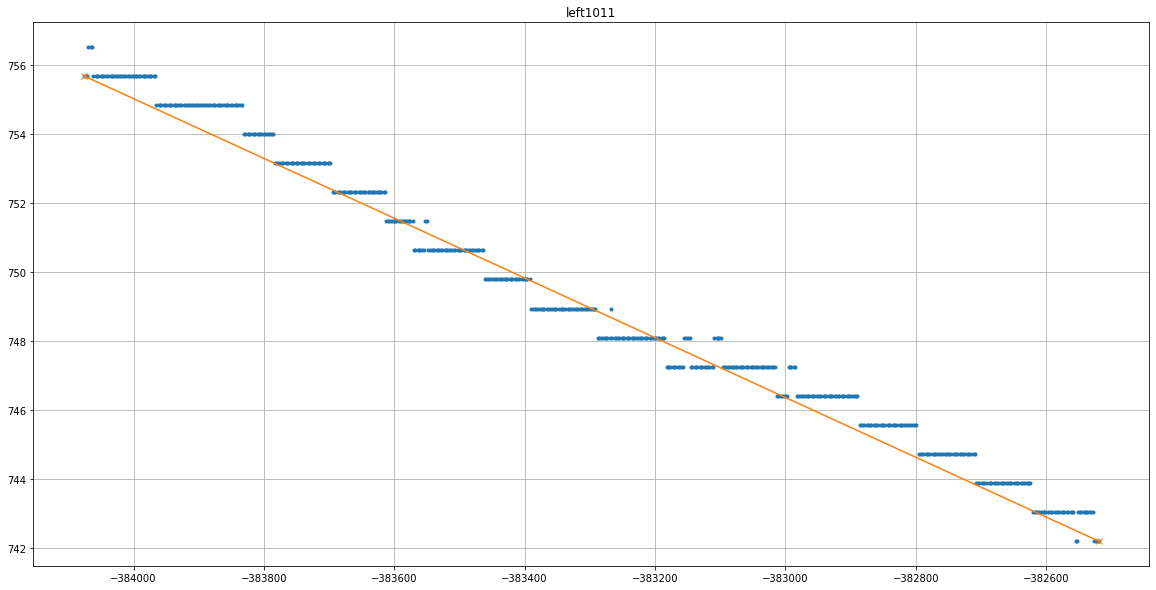

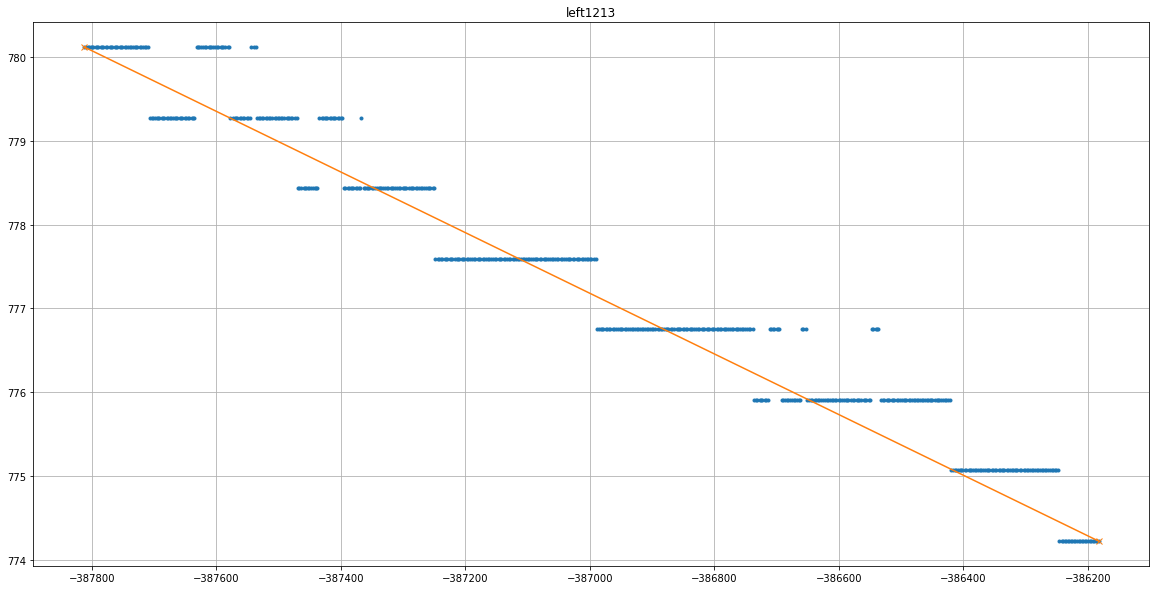

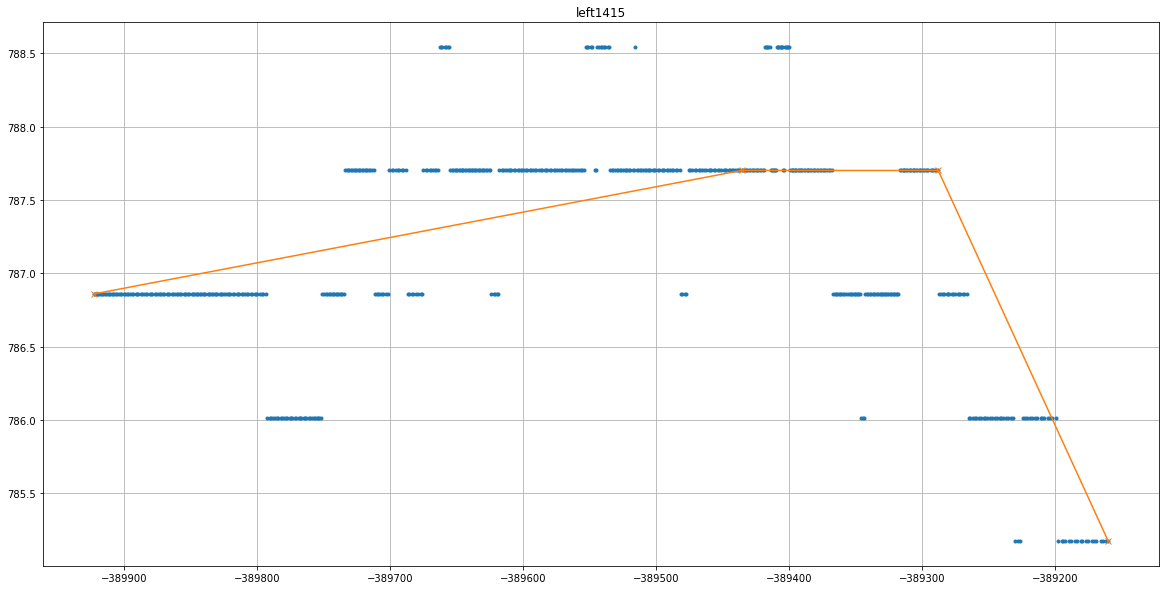

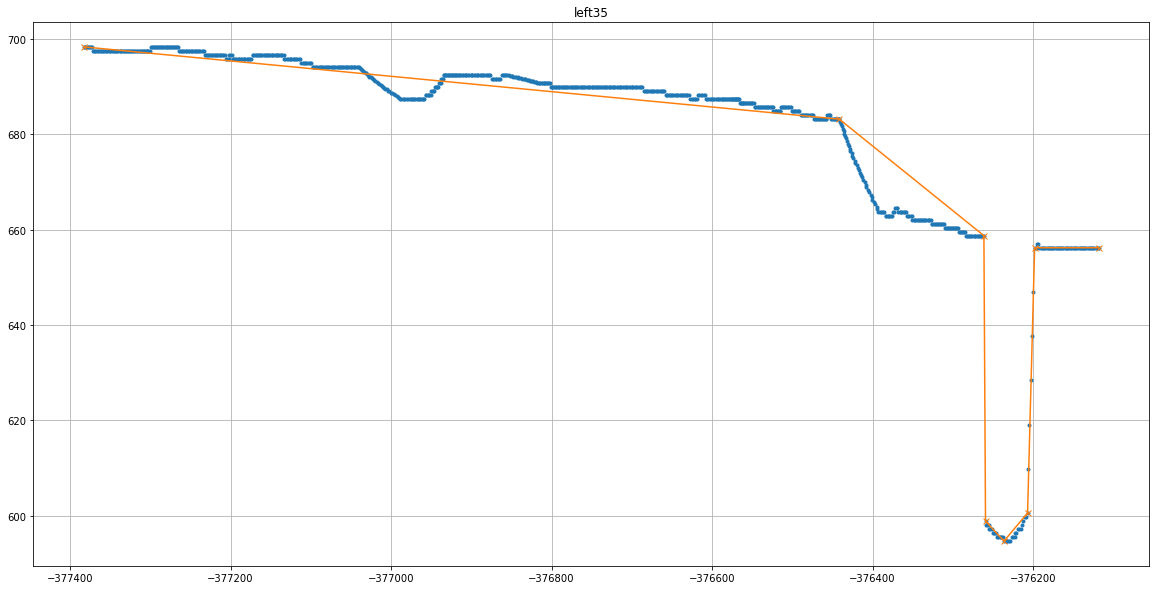

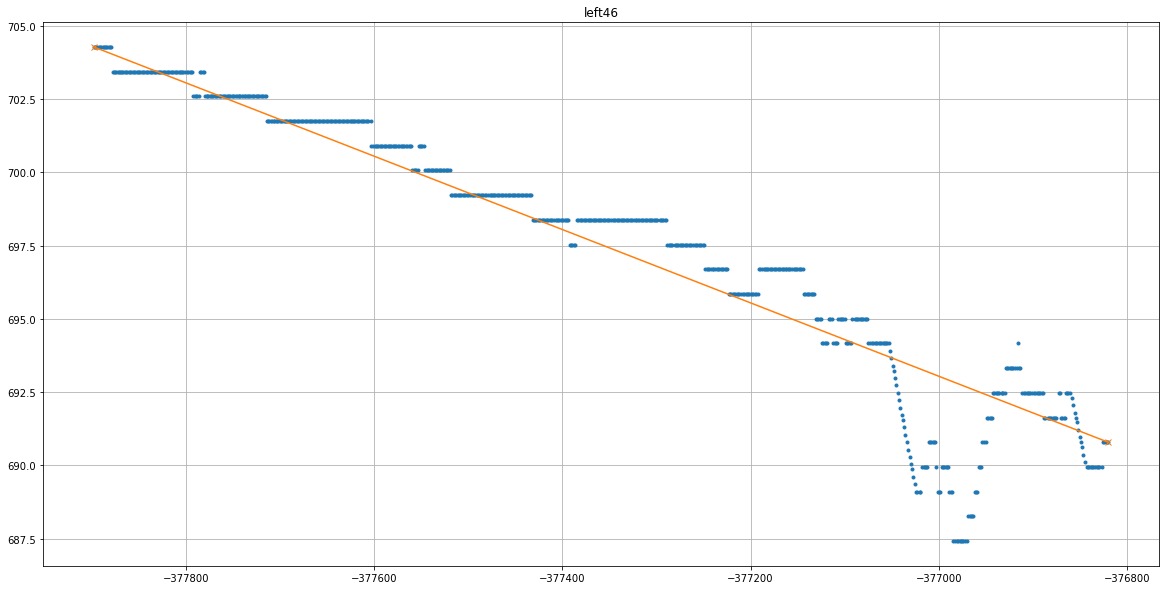

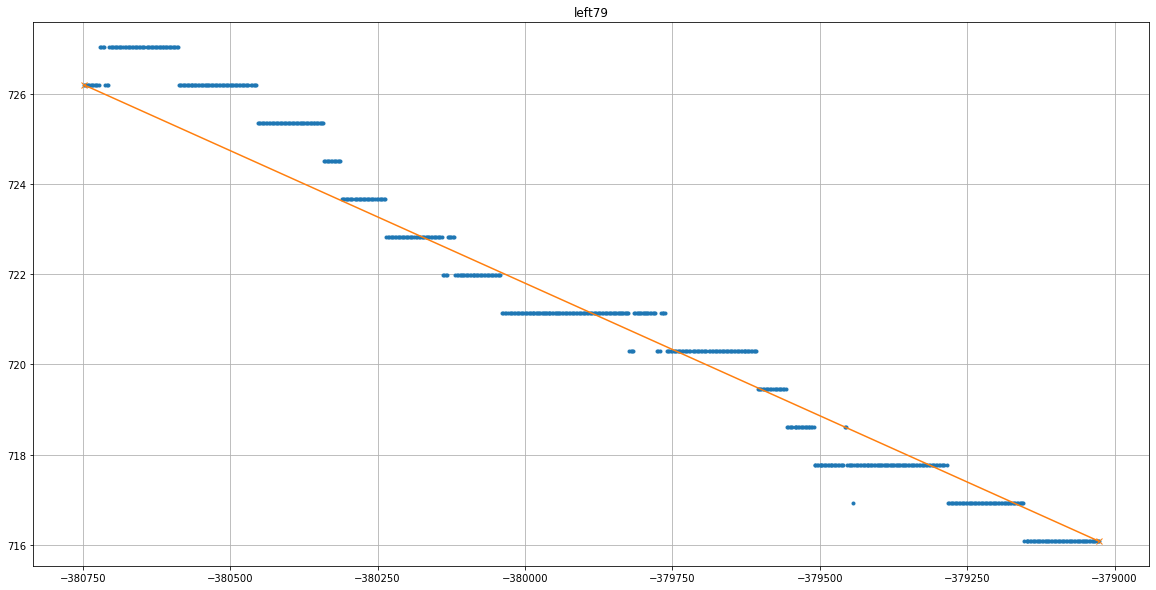

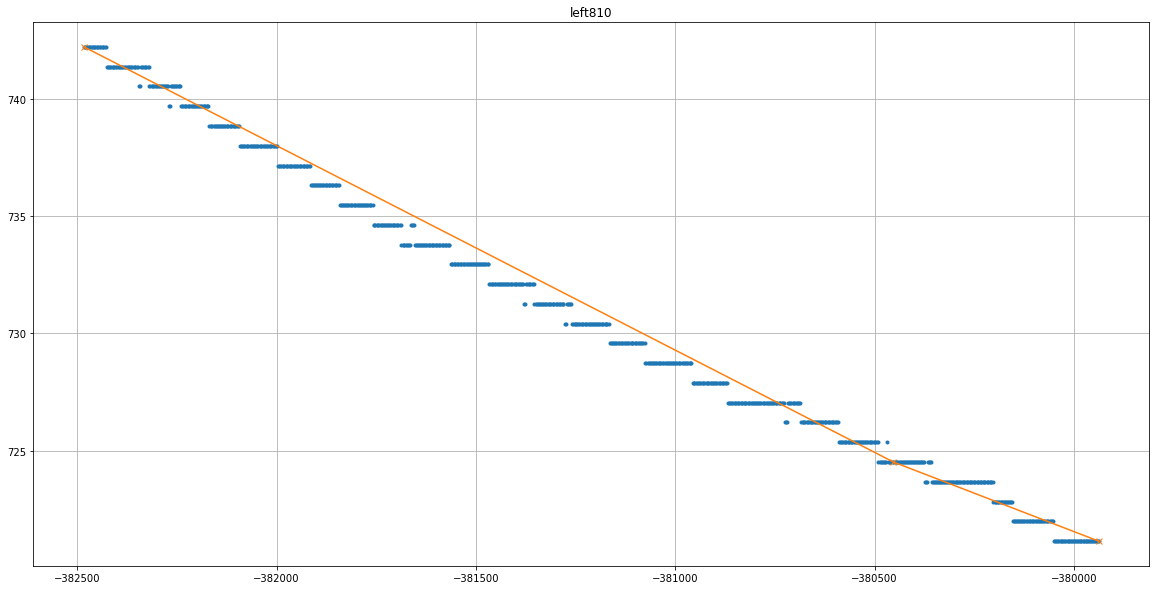

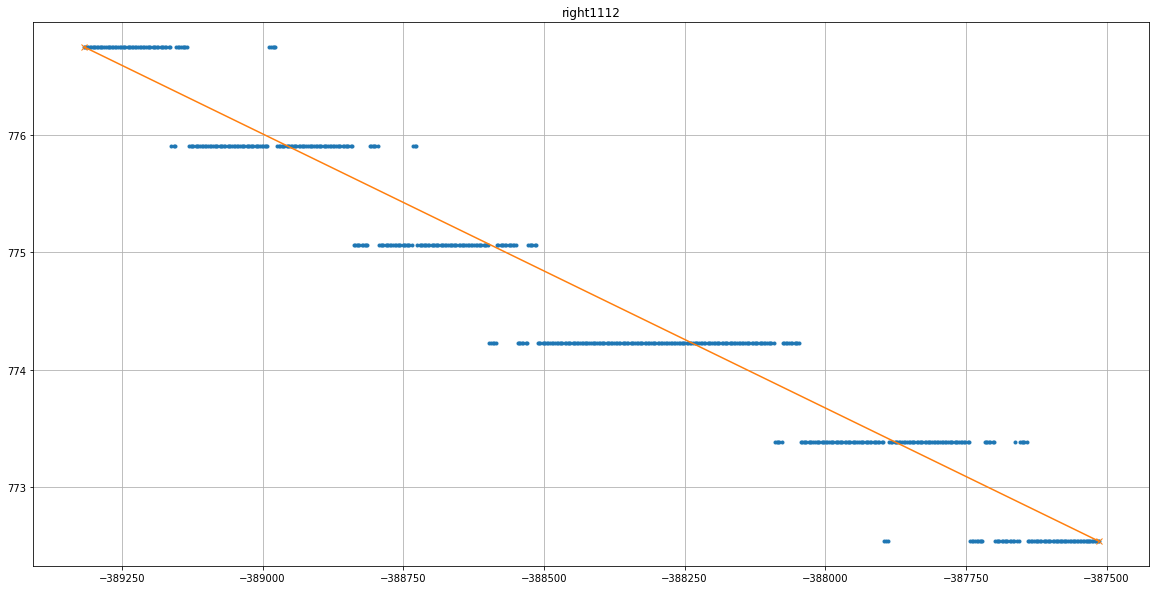

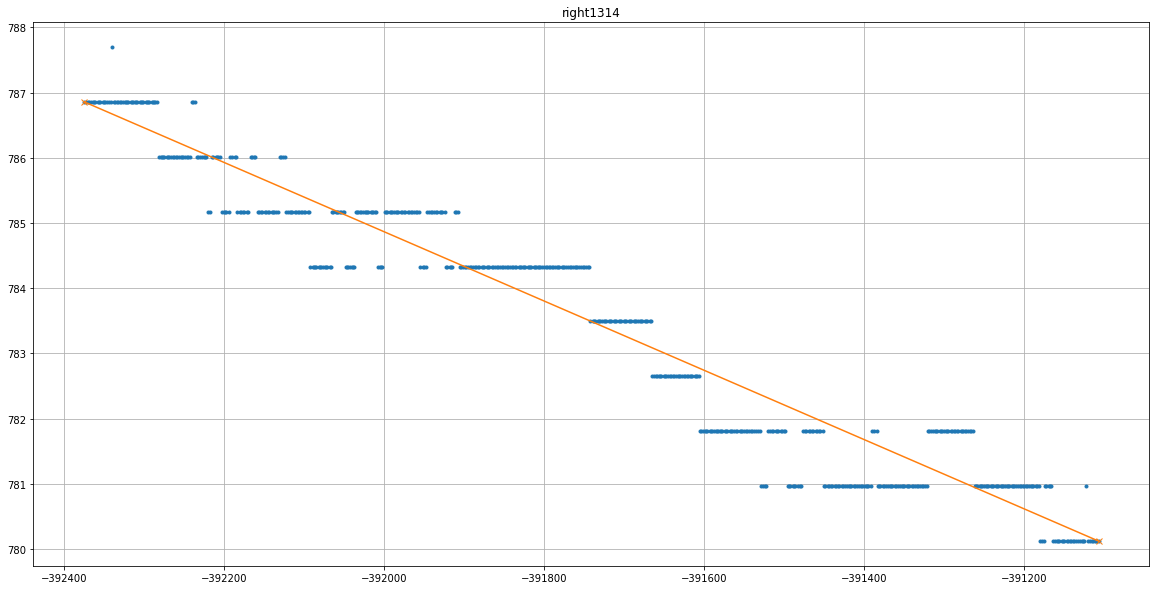

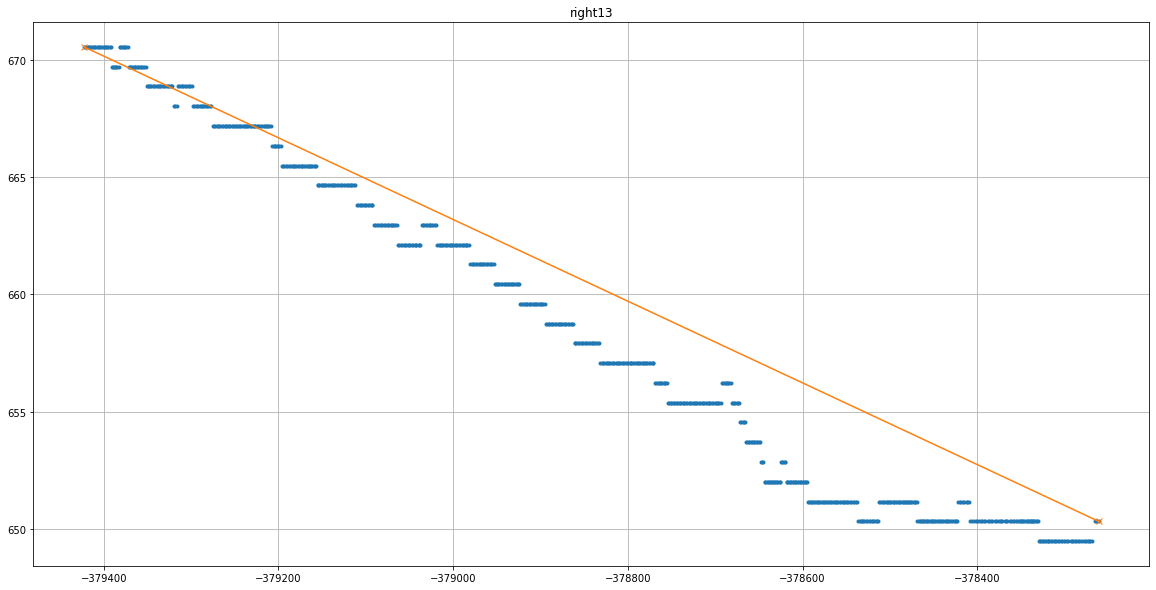

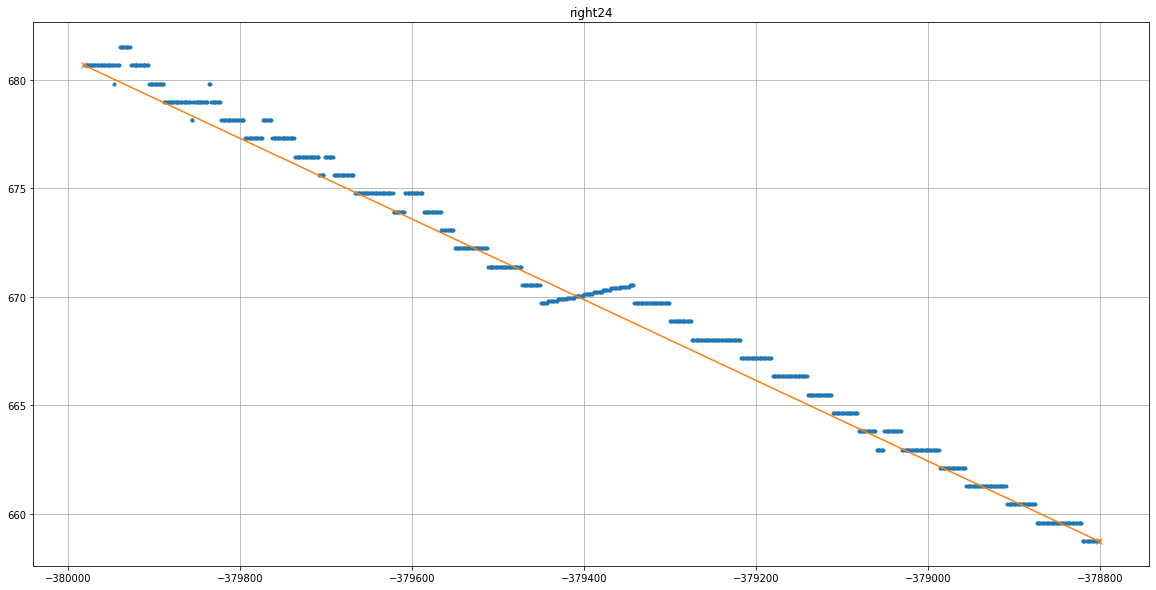

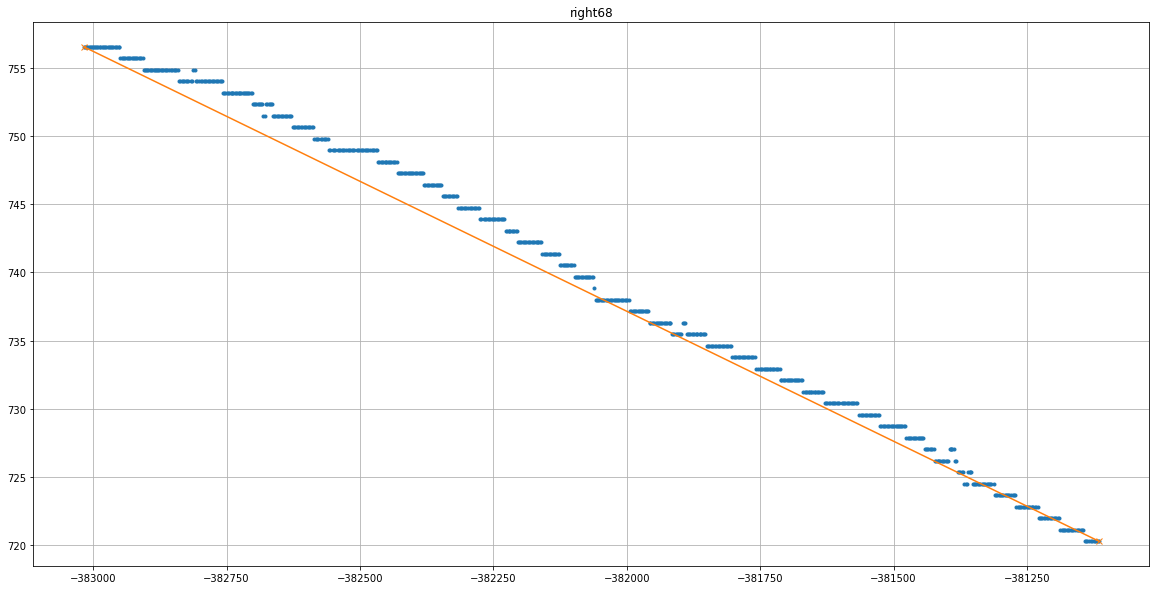

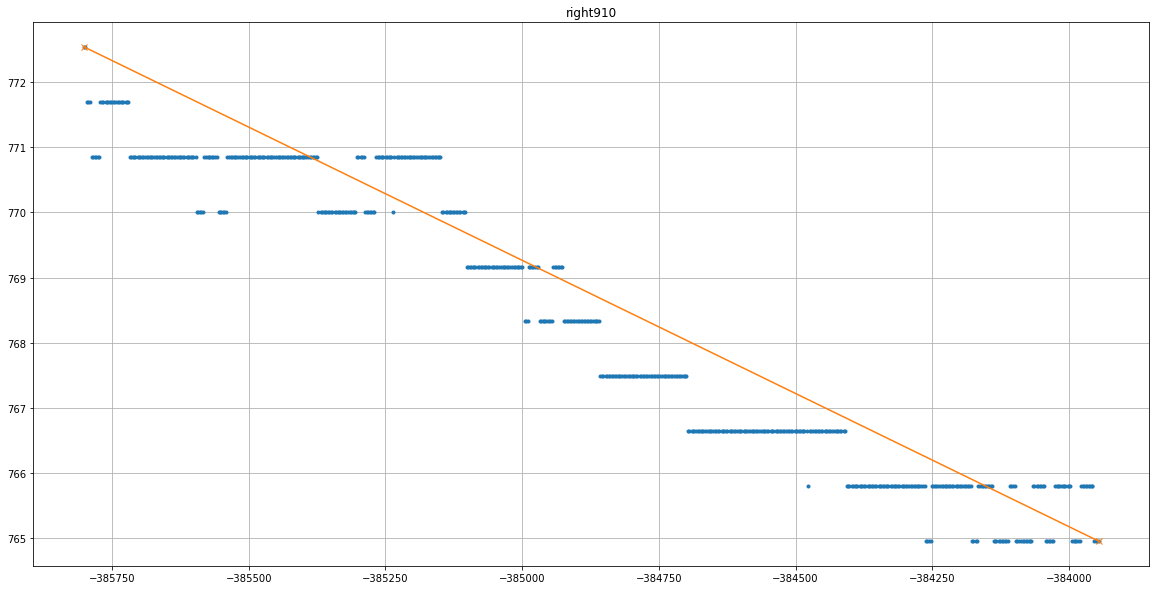

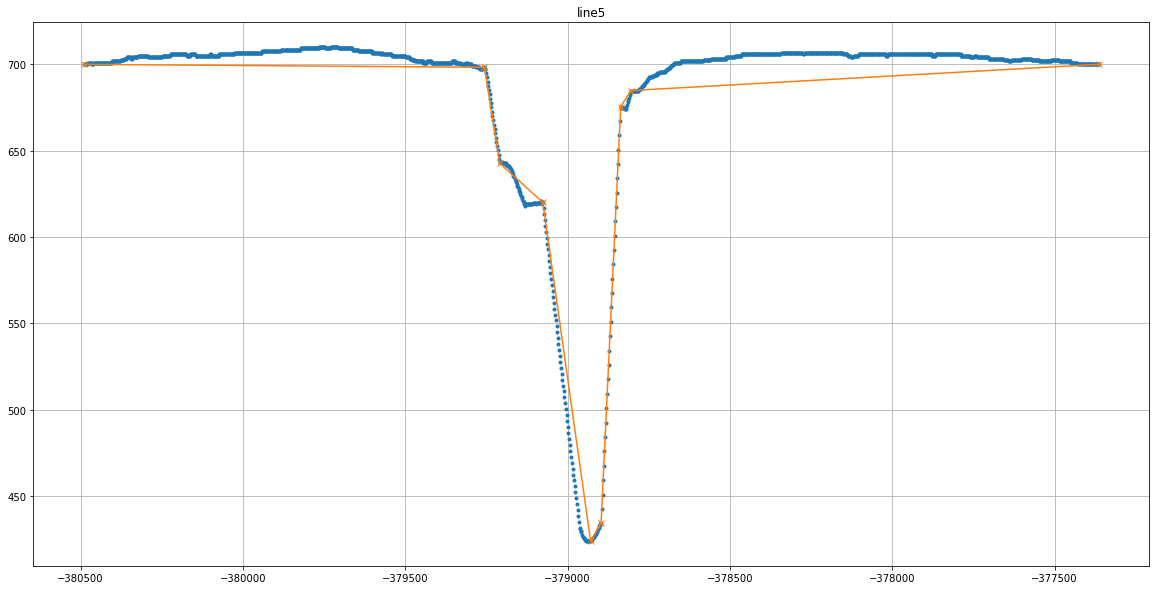

In [29]:
for line_name in ll.keys():
    plot_rdp(line_name,epsilon=30)

In [30]:
sl_list = [a for a in sl.values()]

In [31]:
simplified_lines_gdf = pd.concat(sl_list)
simplified_lines_gdf.reset_index(drop=True, inplace=True)
simplified_lines_gdf.to_file('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/simplified_lines_gdf.shp')


In [32]:
simplified_lines_gdf

x         y  ice_thickn                         geometry  \
0   -381564.6 -725999.7  743.049205  POINT (-381564.600 -725999.700)   
1   -380959.0 -725328.4  727.037987  POINT (-380959.000 -725328.400)   
2   -380957.7 -725327.1  460.216708  POINT (-380957.700 -725327.100)   
3   -380927.7 -725292.4  451.746014  POINT (-380927.700 -725292.400)   
4   -380855.4 -725207.5  468.684820  POINT (-380855.400 -725207.500)   
..        ...       ...         ...                              ...   
294 -379076.4 -726597.1  620.115790  POINT (-379076.400 -726597.100)   
295 -379209.1 -726741.2  642.725965  POINT (-379209.100 -726741.200)   
296 -379256.0 -726793.7  698.380423  POINT (-379256.000 -726793.700)   
297 -379833.3 -727455.8  708.495766  POINT (-379833.300 -727455.800)   
298 -380489.3 -728131.8  700.066385  POINT (-380489.300 -728131.800)   

             dx   distan_cum line_name  
0      0.000000     0.000000     line7  
1    904.099027   904.099027     line7  
2      1.838478   905.937504     line7  
3     45.870361   951.807865     line7  
4    111.513676  1063.321541     line7  
..          ...          ...       ...  
294  164.894663  2472.146686     line5  
295  195.893083  2668.039769     line5  
296   70.397869  2738.437638     line5  
297  878.437078  3616.874716     line5  
298  941.972399  4558.847115     line5  

[299 rows x 7 columns]

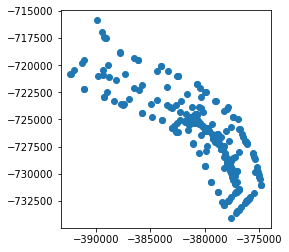

In [33]:
simplified_lines_gdf.plot()